
## Exploratory analysis for Google Ads + Navigation data

#### Run the following chunk to stablish GDrive connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import io
import os
import json
import pickle
import joblib
import datetime
import numpy as np
import pandas as pd
import datetime as dt
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from datetime import datetime, timedelta
import matplotlib.cm as cm
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

### Read in raw data

In [ ]:
# Read in parquet file
url = "/content/drive/MyDrive/UNR_2023/Background + data/data_NMV_GAds2.parquet"
df_parquet = pd.read_parquet(url)
#print(f'Rows: {df_parquet.shape[0]}\nColumns: {df_parquet.shape[1]}')

In [ ]:
df_raw = df_parquet[(df_parquet['date']>='2022-01-17')]

df_raw = df_raw[~df_raw['campaign'].isin(['Muebles', 'Dormitorio','Muebles_Y_Dormitorio'])]
df_raw = df_raw.drop(['budget_USD'], axis=1)
print(f'Rows: {df_raw.shape[0]}\nColumns: {df_raw.shape[1]}')

Rows: 7016
Columns: 19


In [ ]:
df_raw.head()

date  week_day  month_day  year_day  month_year  is_event  is_cyber  \
0 2022-01-17         1         17        17           1         0         0   
1 2022-01-18         2         18        18           1         0         0   
2 2022-01-19         3         19        19           1         0         0   
3 2022-01-20         4         20        20           1         0         0   
4 2022-01-21         5         21        21           1         0         0   

   previous_cyber_days    campaign    budget     cost  clicks  impressions  \
0                    0  Automotriz  199910.0    20917     354        39672   
1                    0  Automotriz  199910.0    82689    1254       109474   
2                    0  Automotriz  199910.0    88869    4344       124152   
3                    0  Automotriz  199910.0   586917    7231       413879   
4                    0  Automotriz  199910.0  1656293   34950      1170805   

       nmv  visitors  visitors_pur  visits  orders  total_units_net  
0    73731        42             3      44       3                6  
1   485092       763            11     840      10               14  
2   877092      1032            14    1216      14               32  
3  1844538      3120            38    3539      38               53  
4  2064439      8004            41    8728      40               77

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7016 entries, 0 to 7963
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 7016 non-null   datetime64[ns]
 1   week_day             7016 non-null   int64         
 2   month_day            7016 non-null   int64         
 3   year_day             7016 non-null   int64         
 4   month_year           7016 non-null   int64         
 5   is_event             7016 non-null   int64         
 6   is_cyber             7016 non-null   int64         
 7   previous_cyber_days  7016 non-null   int64         
 8   campaign             7016 non-null   object        
 9   budget               7016 non-null   float64       
 10  cost                 7016 non-null   int64         
 11  clicks               7016 non-null   int64         
 12  impressions          7016 non-null   int64         
 13  nmv                  7016 non-nul

#### Create weekend/no-weekend variables

In [ ]:
# Create WEEKEND - NO WEEKEND field
df_raw['is_week_day'] = df_raw['date'].apply(lambda x: int(x.dayofweek < 5))

print(df_raw[['date','is_week_day']])

           date  is_week_day
0    2022-01-17            1
1    2022-01-18            1
2    2022-01-19            1
3    2022-01-20            1
4    2022-01-21            1
...         ...          ...
7959 2023-08-18            1
7960 2023-08-19            0
7961 2023-08-20            0
7962 2023-08-21            1
7963 2023-08-22            1

[7016 rows x 2 columns]


In [ ]:
df_raw['is_cyber'].value_counts()

0    6908
1     108
Name: is_cyber, dtype: int64

#### Transform variables

#### Transform budget, cost and nmv to USD

In [ ]:
# Transform budget, cost and nmv to USD
df_raw['budget_USD'] = (df_raw['budget'] / 845.33).round(2)    # Use ".round(0).astype(int)" to get int values
df_raw['cost_USD'] = (df_raw['cost'] / 845.33).round(2)
df_raw['nmv_USD'] = (df_raw['nmv'] / 845.33).round(2)

df_raw[(df_raw.is_cyber==0)].groupby('campaign')['budget','budget_USD'].agg(['min','max','count','sum'])

budget                    \
                                              min         max count   
campaign                                                              
Automotriz                                  265.0   5506077.0   575   
Belleza_Bienestar                        170743.0  23401155.0   576   
Climatizacion                             10075.0  11445226.0   575   
Decoracion_Blanco                         60299.0  19680762.0   576   
Grandes_Electrodomesticos_Cocina          44003.0   9766091.0   576   
Grandes_Electrodomesticos_Lavado          16230.0  13713347.0   576   
Grandes_Electrodomesticos_Refrigeracion   29099.0  14196021.0   576   
Jardineria                                23718.0   6437827.0   576   
Mascotas                                   5936.0   2318507.0   576   
Menaje                                    39006.0   7956977.0   576   
Pequeños_Electrodomesticos               234598.0  32175420.0   575   
Telefonia                                 90066.0  24919224.0   575   

                                                     budget_USD            \
                                                 sum        min       max   
campaign                                                                    
Automotriz                               104815655.0       0.31   6513.52   
Belleza_Bienestar                        837876131.0     201.98  27682.86   
Climatizacion                            374967228.0      11.92  13539.36   
Decoracion_Blanco                        603356953.0      71.33  23281.75   
Grandes_Electrodomesticos_Cocina         211201561.0      52.05  11552.99   
Grandes_Electrodomesticos_Lavado         384660969.0      19.20  16222.48   
Grandes_Electrodomesticos_Refrigeracion  469614202.0      34.42  16793.47   
Jardineria                               183701028.0      28.06   7615.76   
Mascotas                                  77969415.0       7.02   2742.72   
Menaje                                   241152452.0      46.14   9412.86   
Pequeños_Electrodomesticos               836485286.0     277.52  38062.56   
Telefonia                                996253509.0     106.55  29478.69   

                                                           
                                        count         sum  
campaign                                                   
Automotriz                                575   123994.17  
Belleza_Bienestar                         576   991182.08  
Climatizacion                             575   443574.44  
Decoracion_Blanco                         576   713752.73  
Grandes_Electrodomesticos_Cocina          576   249846.23  
Grandes_Electrodomesticos_Lavado          576   455042.93  
Grandes_Electrodomesticos_Refrigeracion   576   555539.98  
Jardineria                                576   217312.79  
Mascotas                                  576    92235.10  
Menaje                                    576   285276.33  
Pequeños_Electrodomesticos                575   989536.46  
Telefonia                                 575  1178537.88

In [ ]:
df_raw = df_raw.drop(['budget','cost','nmv'], axis=1) # Remove CLP fields from dataset
#df_raw.info()

### Missing data review



In [ ]:
# from dataprep.eda import plot_missing

# plot_missing(df_raw)

### Duplicated values

**NOTE:** Los días 2023-07-24 y 2023-07-25 están duplicados para todas las campañas, se conversa con el Data Engineer del equipo que corrobora que hubo un error en el scheduler que itera sobre la tabla. Eliminar los registros

In [ ]:
df_raw = df_raw.drop_duplicates(keep='first')

#df_raw.info()

# Check dups removed
print(df_raw[df_raw.duplicated(keep=False)])

Empty DataFrame
Columns: [date, week_day, month_day, year_day, month_year, is_event, is_cyber, previous_cyber_days, campaign, clicks, impressions, visitors, visitors_pur, visits, orders, total_units_net, is_week_day, budget_USD, cost_USD, nmv_USD]
Index: []


**NOTE**: 12 campaigns in total

In [ ]:
df_raw['campaign'].value_counts()

Belleza_Bienestar                          583
Decoracion_Blanco                          583
Grandes_Electrodomesticos_Cocina           583
Grandes_Electrodomesticos_Lavado           583
Grandes_Electrodomesticos_Refrigeracion    583
Jardineria                                 583
Mascotas                                   583
Menaje                                     583
Automotriz                                 582
Climatizacion                              582
Pequeños_Electrodomesticos                 582
Telefonia                                  582
Name: campaign, dtype: int64

**NOTE**: These missing days are cyber days with not budget assigned in the Google Ads platform.

In [ ]:
# Find the count by 'campaign'
conteo_registros = df_raw['campaign'].value_counts()

# Filters campaigns with record count equal to 582
camp_faltantes = conteo_registros[conteo_registros == 582].index

# Create an auxiliary DataFrame with only the missing campaigns
df_faltantes = df_raw[df_raw['campaign'].isin(camp_faltantes)]

# Create a date window from the minimum to the maximum date for each campaign
fechas_rango = df_faltantes.groupby('campaign')['date'].agg([min, max])

# Iterate over missing campaigns
for camp in camp_faltantes:
    rango_fechas = pd.date_range(start=fechas_rango.loc[camp, 'min'], end=fechas_rango.loc[camp, 'max'])
    fechas_faltantes = rango_fechas.difference(df_faltantes[df_faltantes['campaign'] == camp]['date'])

    if not fechas_faltantes.empty:
        print(f"For campaign {camp}, missing date is: {fechas_faltantes}")


For campaign Automotriz, missing date is: DatetimeIndex(['2022-05-29'], dtype='datetime64[ns]', freq=None)
For campaign Climatizacion, missing date is: DatetimeIndex(['2022-05-29'], dtype='datetime64[ns]', freq=None)
For campaign Telefonia, missing date is: DatetimeIndex(['2022-05-29'], dtype='datetime64[ns]', freq=None)


In [ ]:
df_raw.groupby('campaign')['date'].agg(['min','max'])

min        max
campaign                                                     
Automotriz                              2022-01-17 2023-08-22
Belleza_Bienestar                       2022-01-17 2023-08-22
Climatizacion                           2022-01-17 2023-08-22
Decoracion_Blanco                       2022-01-17 2023-08-22
Grandes_Electrodomesticos_Cocina        2022-01-17 2023-08-22
Grandes_Electrodomesticos_Lavado        2022-01-17 2023-08-22
Grandes_Electrodomesticos_Refrigeracion 2022-01-17 2023-08-22
Jardineria                              2022-01-17 2023-08-22
Mascotas                                2022-01-17 2023-08-22
Menaje                                  2022-01-17 2023-08-22
Pequeños_Electrodomesticos              2022-01-18 2023-08-22
Telefonia                               2022-01-17 2023-08-22

**NOTE**: Telefonia has the highest NMV during this time period for no-cyber days; during cyber days Belleza_Bienestar brings the highest NMV. In terms of budget, Telefonia has the highest investment.

In [ ]:
df_raw[(df_raw.is_cyber==0)].groupby('campaign')['nmv_USD','budget_USD'].agg(['min','max','count','sum'])

nmv_USD                   \
                                             min        max count   
campaign                                                            
Automotriz                                 87.22   35110.81   573   
Belleza_Bienestar                        2578.70  302501.54   574   
Climatizacion                             754.09   81905.89   573   
Decoracion_Blanco                        2043.69  128485.66   574   
Grandes_Electrodomesticos_Cocina          515.75   27686.87   574   
Grandes_Electrodomesticos_Lavado         1027.85   44857.97   574   
Grandes_Electrodomesticos_Refrigeracion  2134.92   76289.51   574   
Jardineria                                392.79   88346.43   574   
Mascotas                                   44.22   21819.21   574   
Menaje                                    334.28   57975.02   574   
Pequeños_Electrodomesticos               1839.30  140559.01   573   
Telefonia                                7169.46  313674.14   573   

                                                     budget_USD            \
                                                 sum        min       max   
campaign                                                                    
Automotriz                                3734710.64       0.31   6513.52   
Belleza_Bienestar                        29736593.43     201.98  27682.86   
Climatizacion                             9369817.94      11.92  13539.36   
Decoracion_Blanco                        14848030.91      71.33  23281.75   
Grandes_Electrodomesticos_Cocina          5724611.49      52.05  11552.99   
Grandes_Electrodomesticos_Lavado          7699465.31      19.20  16222.48   
Grandes_Electrodomesticos_Refrigeracion  10367107.36      34.42  16793.47   
Jardineria                                5243853.63      28.06   7615.76   
Mascotas                                  2627094.60       7.02   2742.72   
Menaje                                    7432910.23      46.14   9412.86   
Pequeños_Electrodomesticos               19245642.20     277.52  38062.56   
Telefonia                                24899782.52     106.55  29478.69   

                                                           
                                        count         sum  
campaign                                                   
Automotriz                                573   123688.97  
Belleza_Bienestar                         574   989415.91  
Climatizacion                             573   441920.65  
Decoracion_Blanco                         574   713008.64  
Grandes_Electrodomesticos_Cocina          574   248918.78  
Grandes_Electrodomesticos_Lavado          574   454385.20  
Grandes_Electrodomesticos_Refrigeracion   574   554734.38  
Jardineria                                574   216942.52  
Mascotas                                  574    91896.77  
Menaje                                    574   284739.26  
Pequeños_Electrodomesticos                573   987505.30  
Telefonia                                 573  1175502.38

#### Set 'date' as the dataframe index

In [ ]:
df_raw = df_raw.set_index('date')
df_raw.index = pd.to_datetime(df_raw.index)

Describe dataframe variables

In [ ]:
# Statistics for num variables
df_raw.drop(['is_event', 'is_cyber', 'week_day','month_day','year_day','month_year','is_week_day',\
             'previous_cyber_days'], axis=1).describe()

clicks   impressions       visitors  visitors_pur  \
count    6992.000000  6.992000e+03    6992.000000   6992.000000   
mean    14111.150029  1.032426e+06   11711.888730    310.859554   
std     15376.046486  1.233059e+06   12479.031394    554.481067   
min         3.000000  1.820000e+02      42.000000      1.000000   
25%      3954.500000  3.057592e+05    3736.750000     76.000000   
50%      8459.500000  6.090660e+05    7072.500000    152.000000   
75%     19541.250000  1.335617e+06   15720.750000    374.000000   
max    203857.000000  2.251760e+07  146420.000000  14848.000000   

              visits        orders  total_units_net    budget_USD  \
count    6992.000000   6992.000000      6992.000000   6992.000000   
mean    15595.783324    306.137586       578.572368    986.972819   
std     17395.921136    548.692255      1102.027026   1774.681985   
min        44.000000      1.000000         1.000000      0.310000   
25%      4818.750000     74.750000       135.000000    302.200000   
50%      9182.500000    149.000000       283.000000    598.165000   
75%     20827.000000    368.000000       673.000000   1326.472500   
max    238770.000000  14772.000000     32941.000000  68612.260000   

           cost_USD        nmv_USD  
count   6992.000000    6992.000000  
mean    1039.020705   23992.271899  
std     2310.793766   42620.934230  
min        0.090000      44.220000  
25%      265.617500    7077.490000  
50%      611.770000   14267.305000  
75%     1205.200000   28838.295000  
max    69710.350000  981317.470000

### Distributions

#### Dataframe analysis (box-plots)

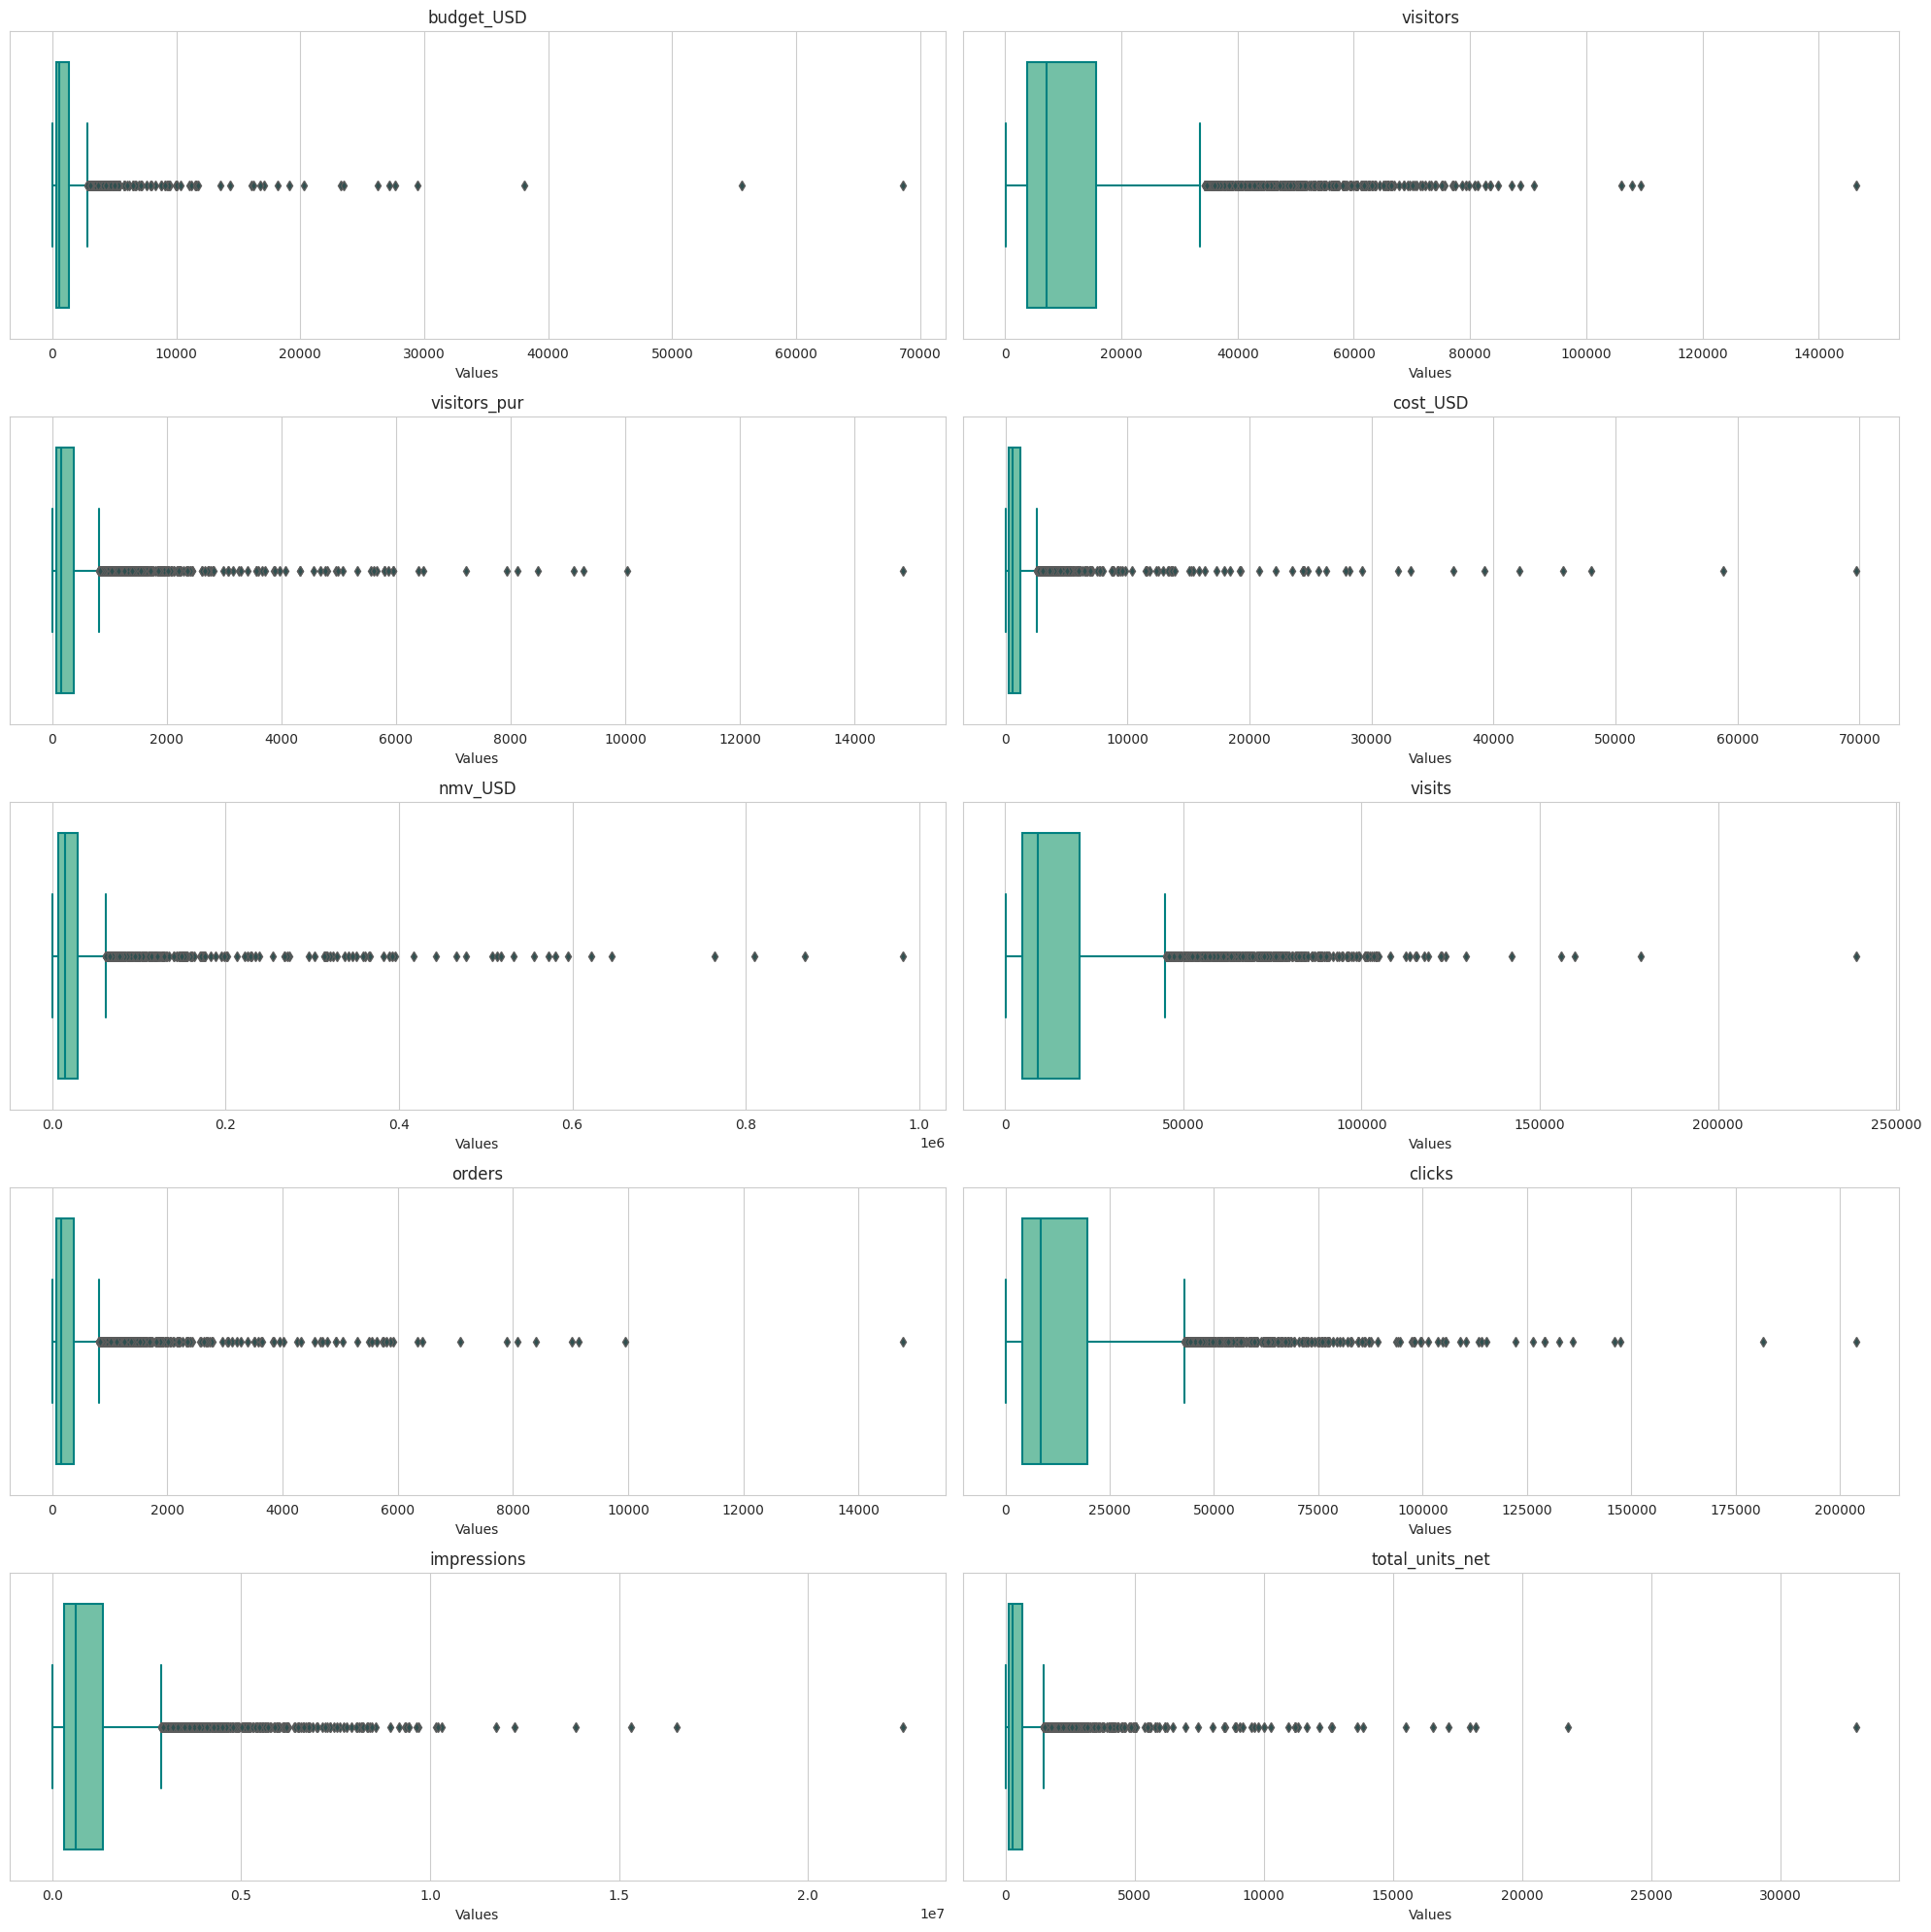

In [ ]:
# Variables to plot
variables = ['budget_USD','cost_USD','nmv_USD','clicks','impressions','visitors','visitors_pur','visits','orders','total_units_net']

# Set the style of seaborn for a white grid
sns.set_style('whitegrid')

# Create a grid of subplots
fig, axs = plt.subplots(5, 2, figsize=(20, 20))

# Iterate through each variable and plot the box plot in the corresponding subplot
for i, var in enumerate(variables):
    j = i%(5)
    k = i%(2)
    sns.boxplot(x=df_raw[var], ax=axs[j,k], color='mediumaquamarine',
                boxprops=dict(edgecolor='teal'),
                whiskerprops=dict(color='teal'),
                capprops=dict(color='teal'),
                medianprops=dict(color='teal'),
                flierprops=dict(markerfacecolor='darkslategray'))

    # Set labels and title for the subplot
    axs[j,k].set_xlabel('Values')
    axs[j,k].set_title(var)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

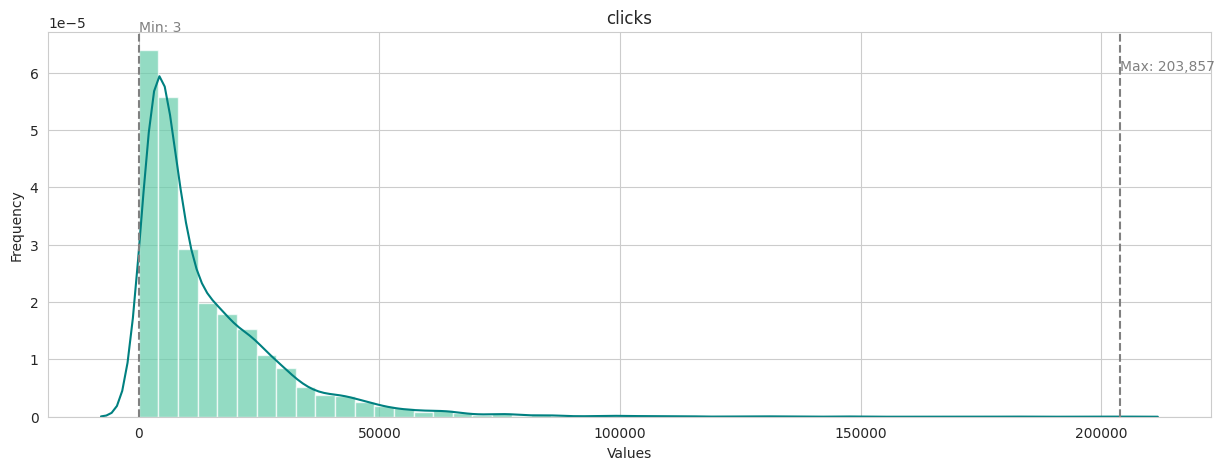

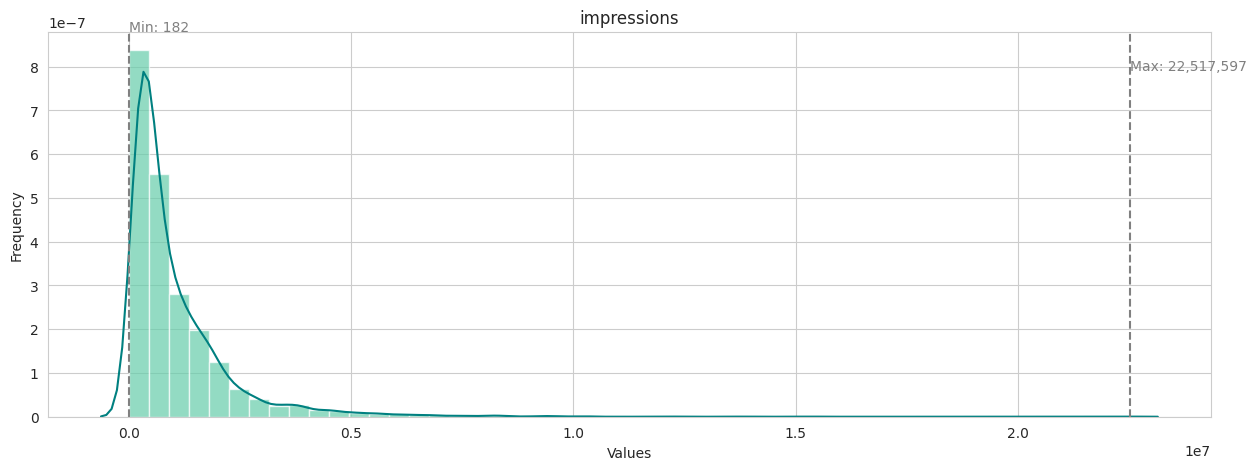

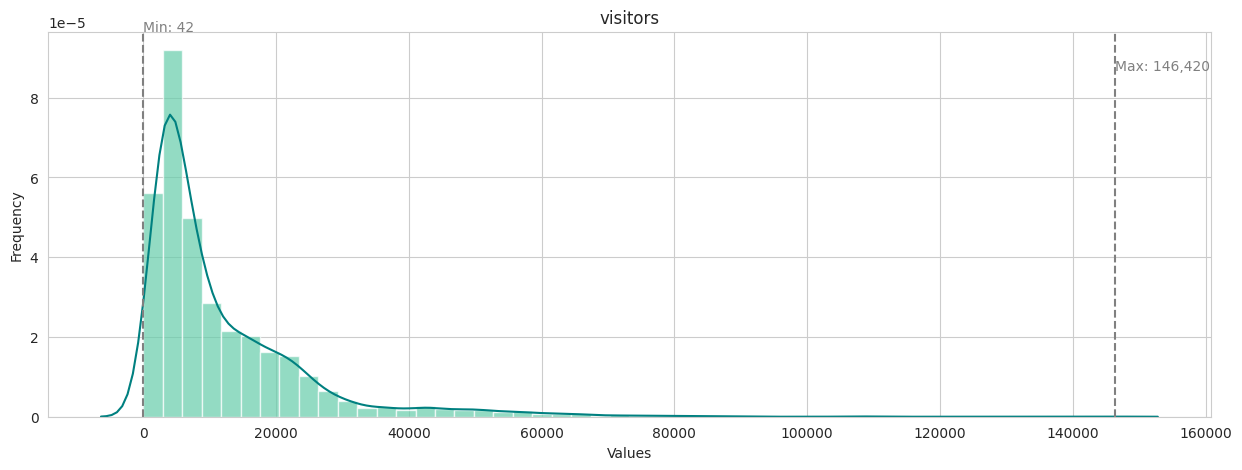

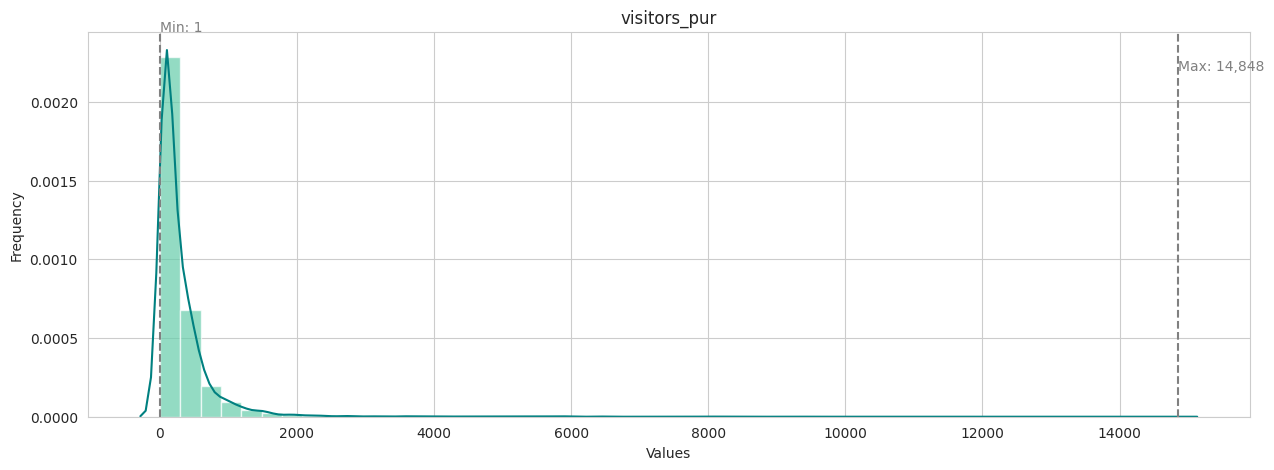

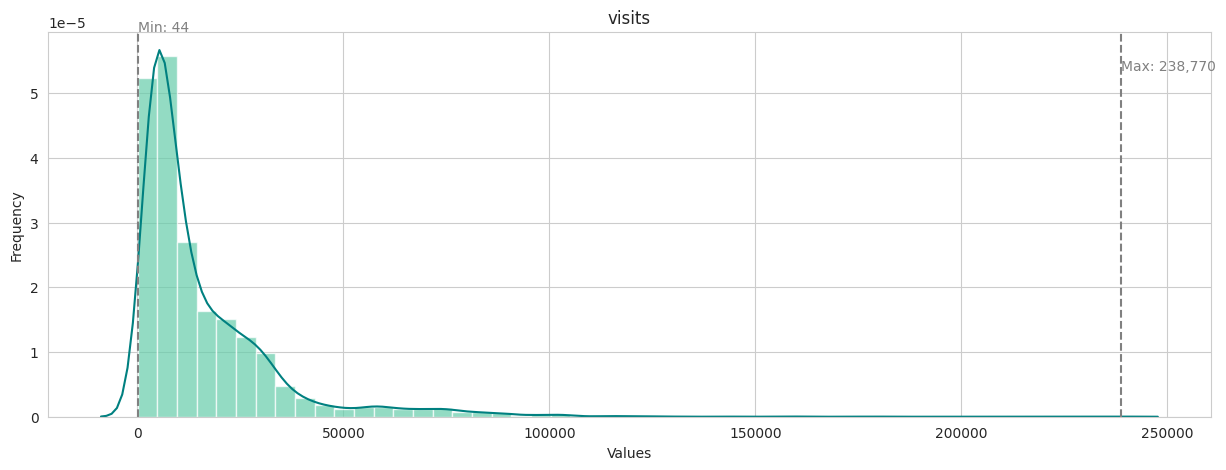

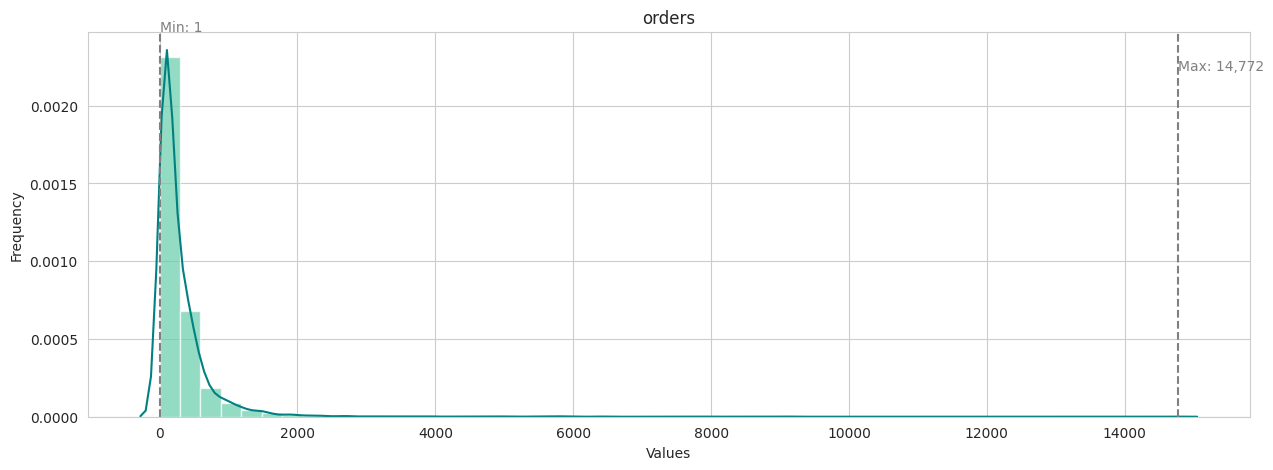

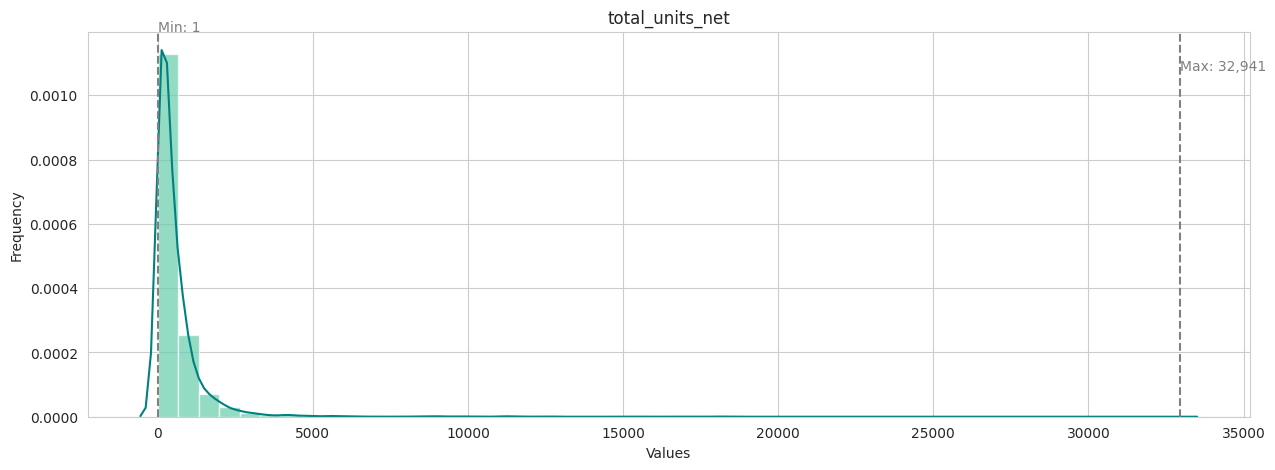

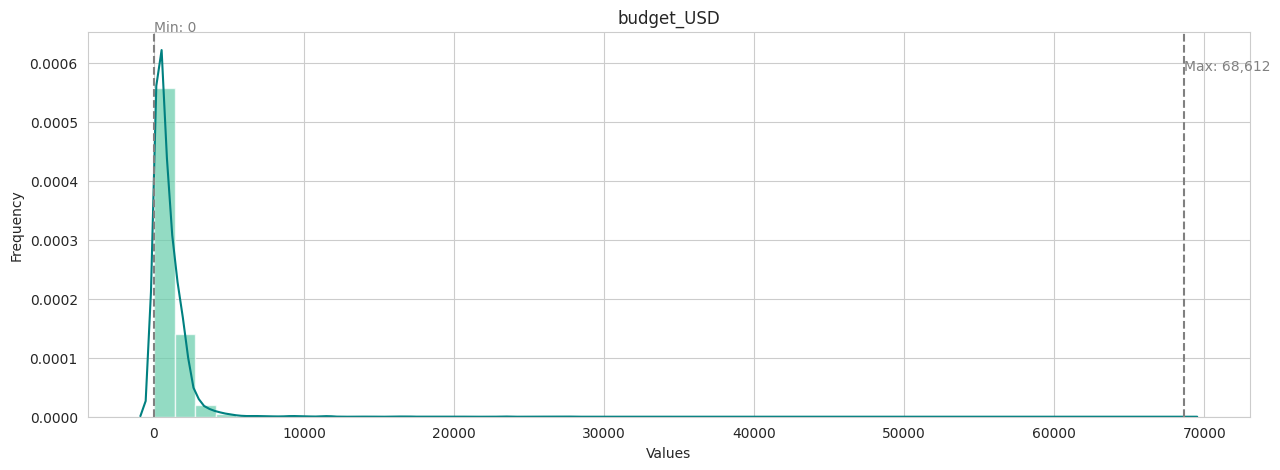

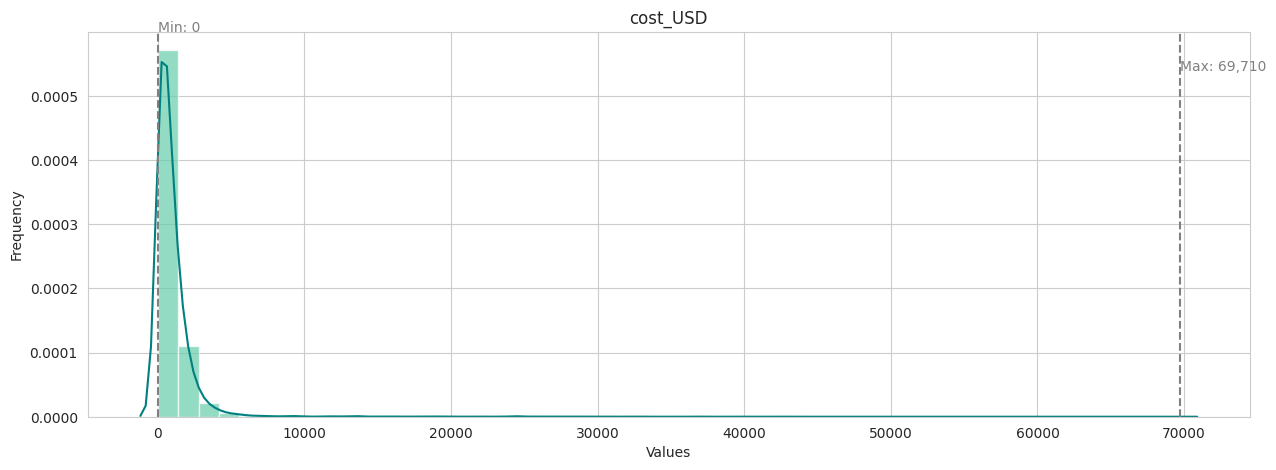

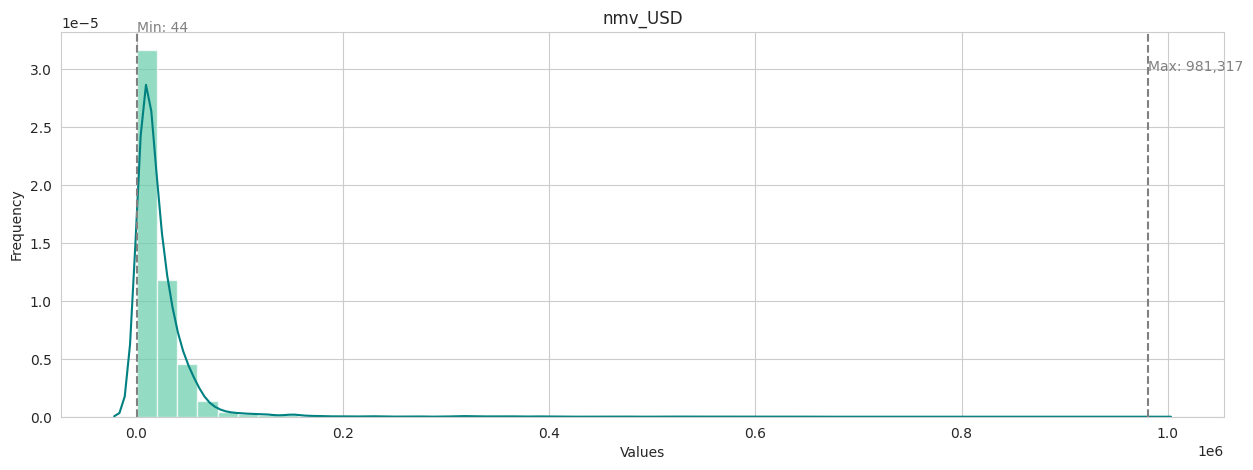

In [ ]:
# Variables to plot
variables = ['clicks','impressions','visitors','visitors_pur','visits','orders','total_units_net','budget_USD','cost_USD','nmv_USD']

# Set the style of seaborn for a white grid
sns.set_style('whitegrid')

# Calculate minimum and maximum for each variable
min_max_values = df_raw[variables].agg(['min', 'max'])

for var in variables:
    plt.figure(figsize=(15, 5))
    # Plot histogram
    plt.hist(df_raw[var], bins=50, alpha=0.7, color='mediumaquamarine', density=True, label=f'Histogram of {var}')

    # Plot KDE (Kernel Density Estimation) line
    sns.kdeplot(df_raw[var], color='teal', label=f'KDE of {var}')

    # Annotate min and max values above the points
    plt.axvline(min_max_values.loc['min', var], color='gray', linestyle='--')
    plt.text(min_max_values.loc['min', var], plt.ylim()[1]*1, f'Min: {min_max_values.loc["min", var]:,.0f}', color='gray')

    plt.axvline(min_max_values.loc['max', var], color='gray', linestyle='--')
    plt.text(min_max_values.loc['max', var], plt.ylim()[1]*0.90, f'Max: {min_max_values.loc["max", var]:,.0f}', color='gray')

    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(var)

    # Show the plot
    plt.show()

#### Variable distribution by campaign

In [ ]:
# Get unique campaigns
unique_campaigns = df_raw['campaign'].unique()

# Set the style of seaborn for a white grid
sns.set_style('whitegrid')

for i, var in enumerate(variables):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(20, 5))

    # Iterate over each campaign and plot its visits
    for i, campaign in enumerate(unique_campaigns):
        df = df_raw[df_raw['campaign'] == campaign]
        df.reset_index(inplace=True)

        # Set the color palette
        palette = 'viridis'

        ax.plot(df['date'], np.log10(1.0 + df[var]), label=campaign, color=sns.color_palette(palette, 15)[i])  # Each campaign in a different color

    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel(f'log {var}')

    # Add legend to distinguish the campaigns
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=0.5)


    # Show the plot
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### NMV distribution over time by campaign - _Format matrix_

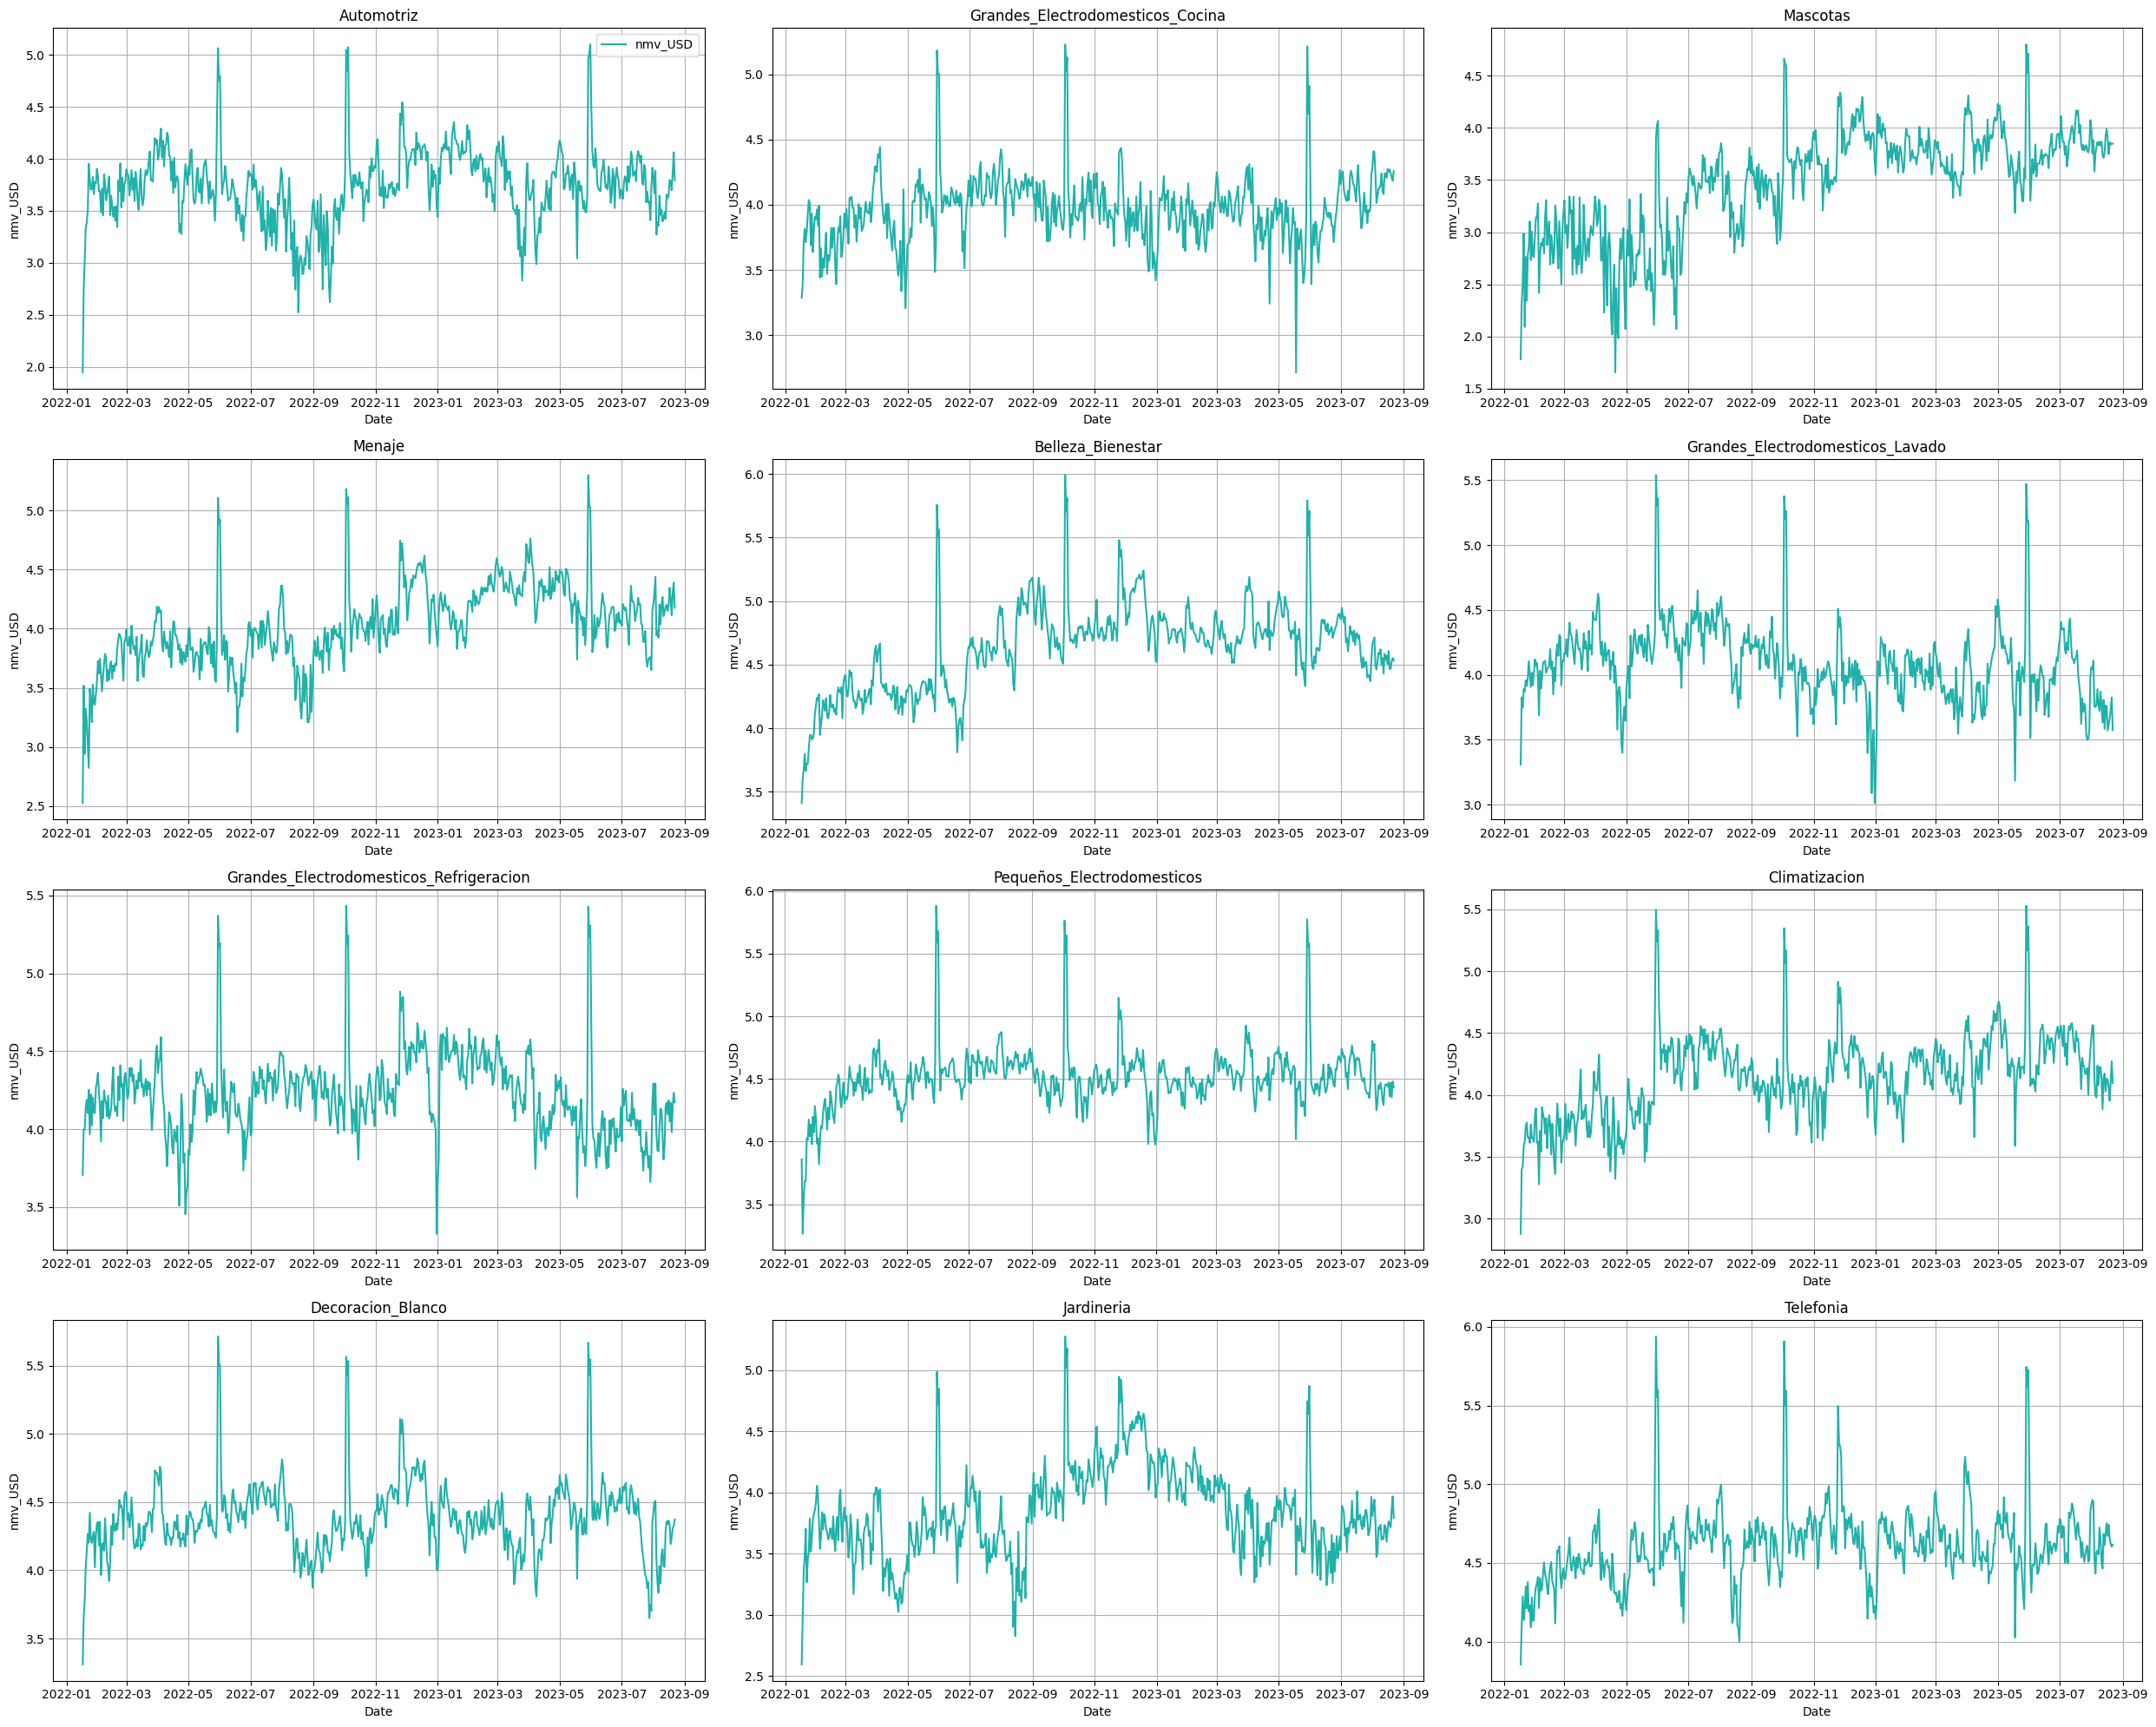

In [ ]:
# Define variable to plot
x_='nmv_USD'

cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(25,20))

for i, campaign in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df = df_raw[(df_raw['campaign']==campaign)]
    #df.reset_index(inplace=True)

    axs[j,k].set_title(campaign)
    # I want the legend only in the 1rst graph
    if (j==0)&(k==0):
        axs[j,k].plot(df.index, np.log10(1.0+df[x_]), label= f'{x_}', color='lightseagreen')
        axs[j,k].legend()
    else:
        axs[j,k].plot(df.index, np.log10(1.0+df[x_]), color='lightseagreen')

    axs[j,k].set_xlabel('Date')
    axs[j,k].set_ylabel(f'{x_}')
    axs[j,k].grid(True)

plt.tight_layout()

#### Campaign NMV by day of the week

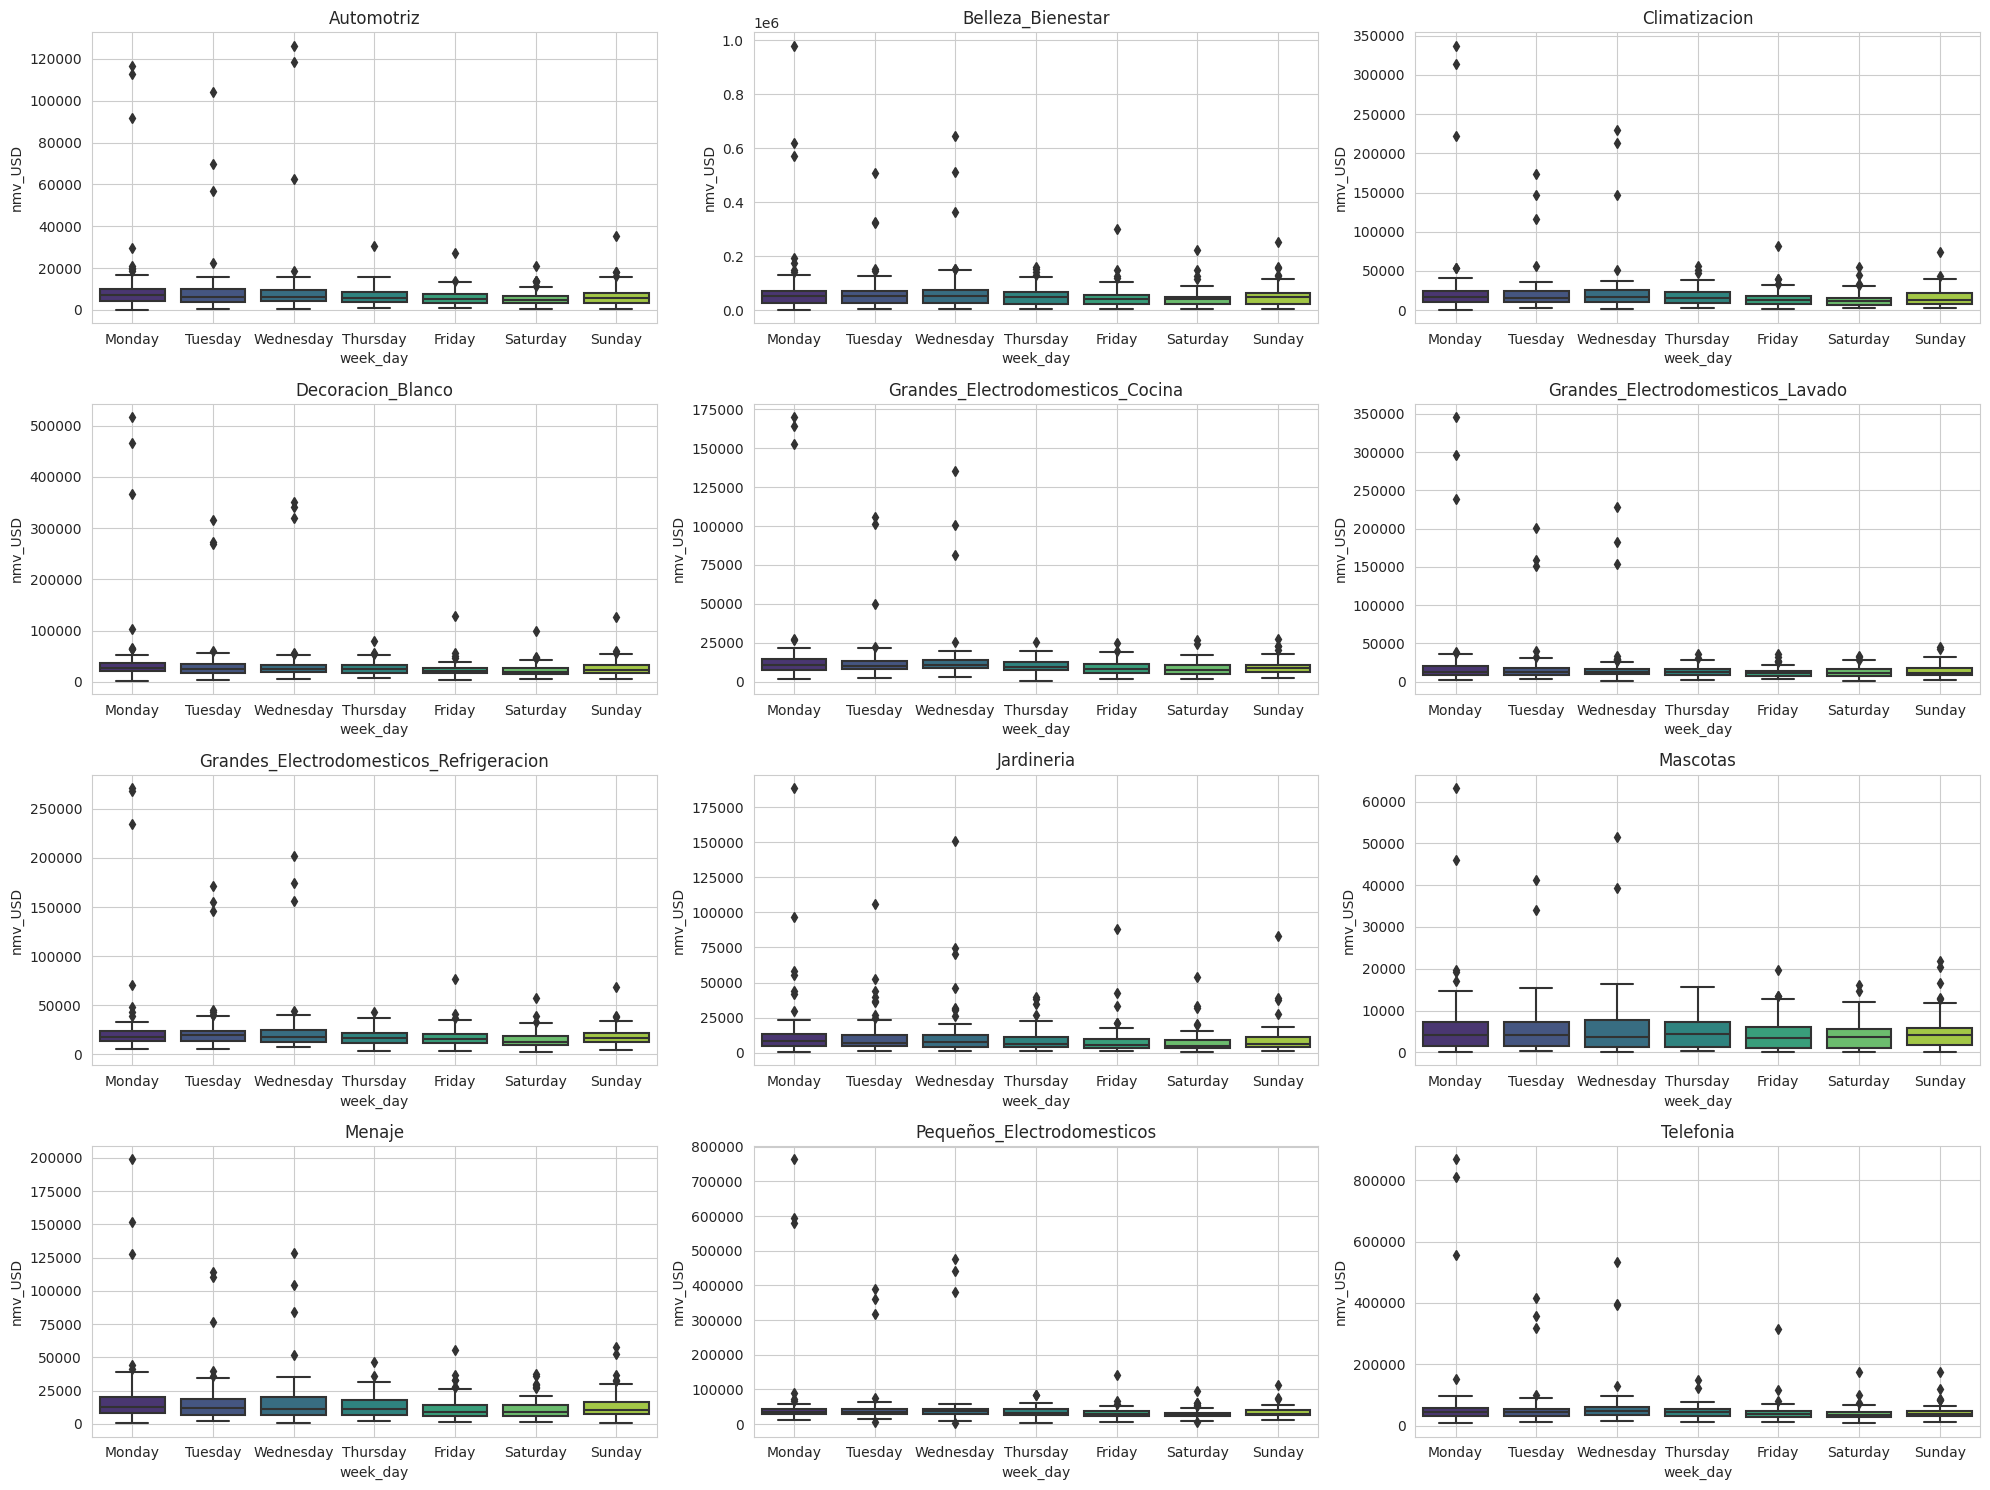

In [ ]:
import calendar

day_names = list(calendar.day_name)

# Define the variable to graph
x_ = 'nmv_USD'

campaigns = df_raw['campaign'].unique()
cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(20, 15))   #figsize=(35, 30)

for i, campaign in enumerate(campaigns):
    j = i // cols
    k = i % cols

    df = df_raw[df_raw['campaign'] == campaign]

    palette = sns.color_palette("viridis", n_colors=len(df['week_day'].unique()))

    axs[j, k].set_title(campaign)
    sns.boxplot(data=df, x='week_day', y=x_, palette=palette, ax=axs[j, k])
    axs[j, k].set_xticklabels(day_names)
    axs[j, k].set_ylabel(f'{x_}')
    axs[j, k].grid(True)

# Adjust the layout to avoid overlaps
plt.tight_layout()

# Show the graphs
plt.show()


#### NMV by day of the month

*Matrix format*

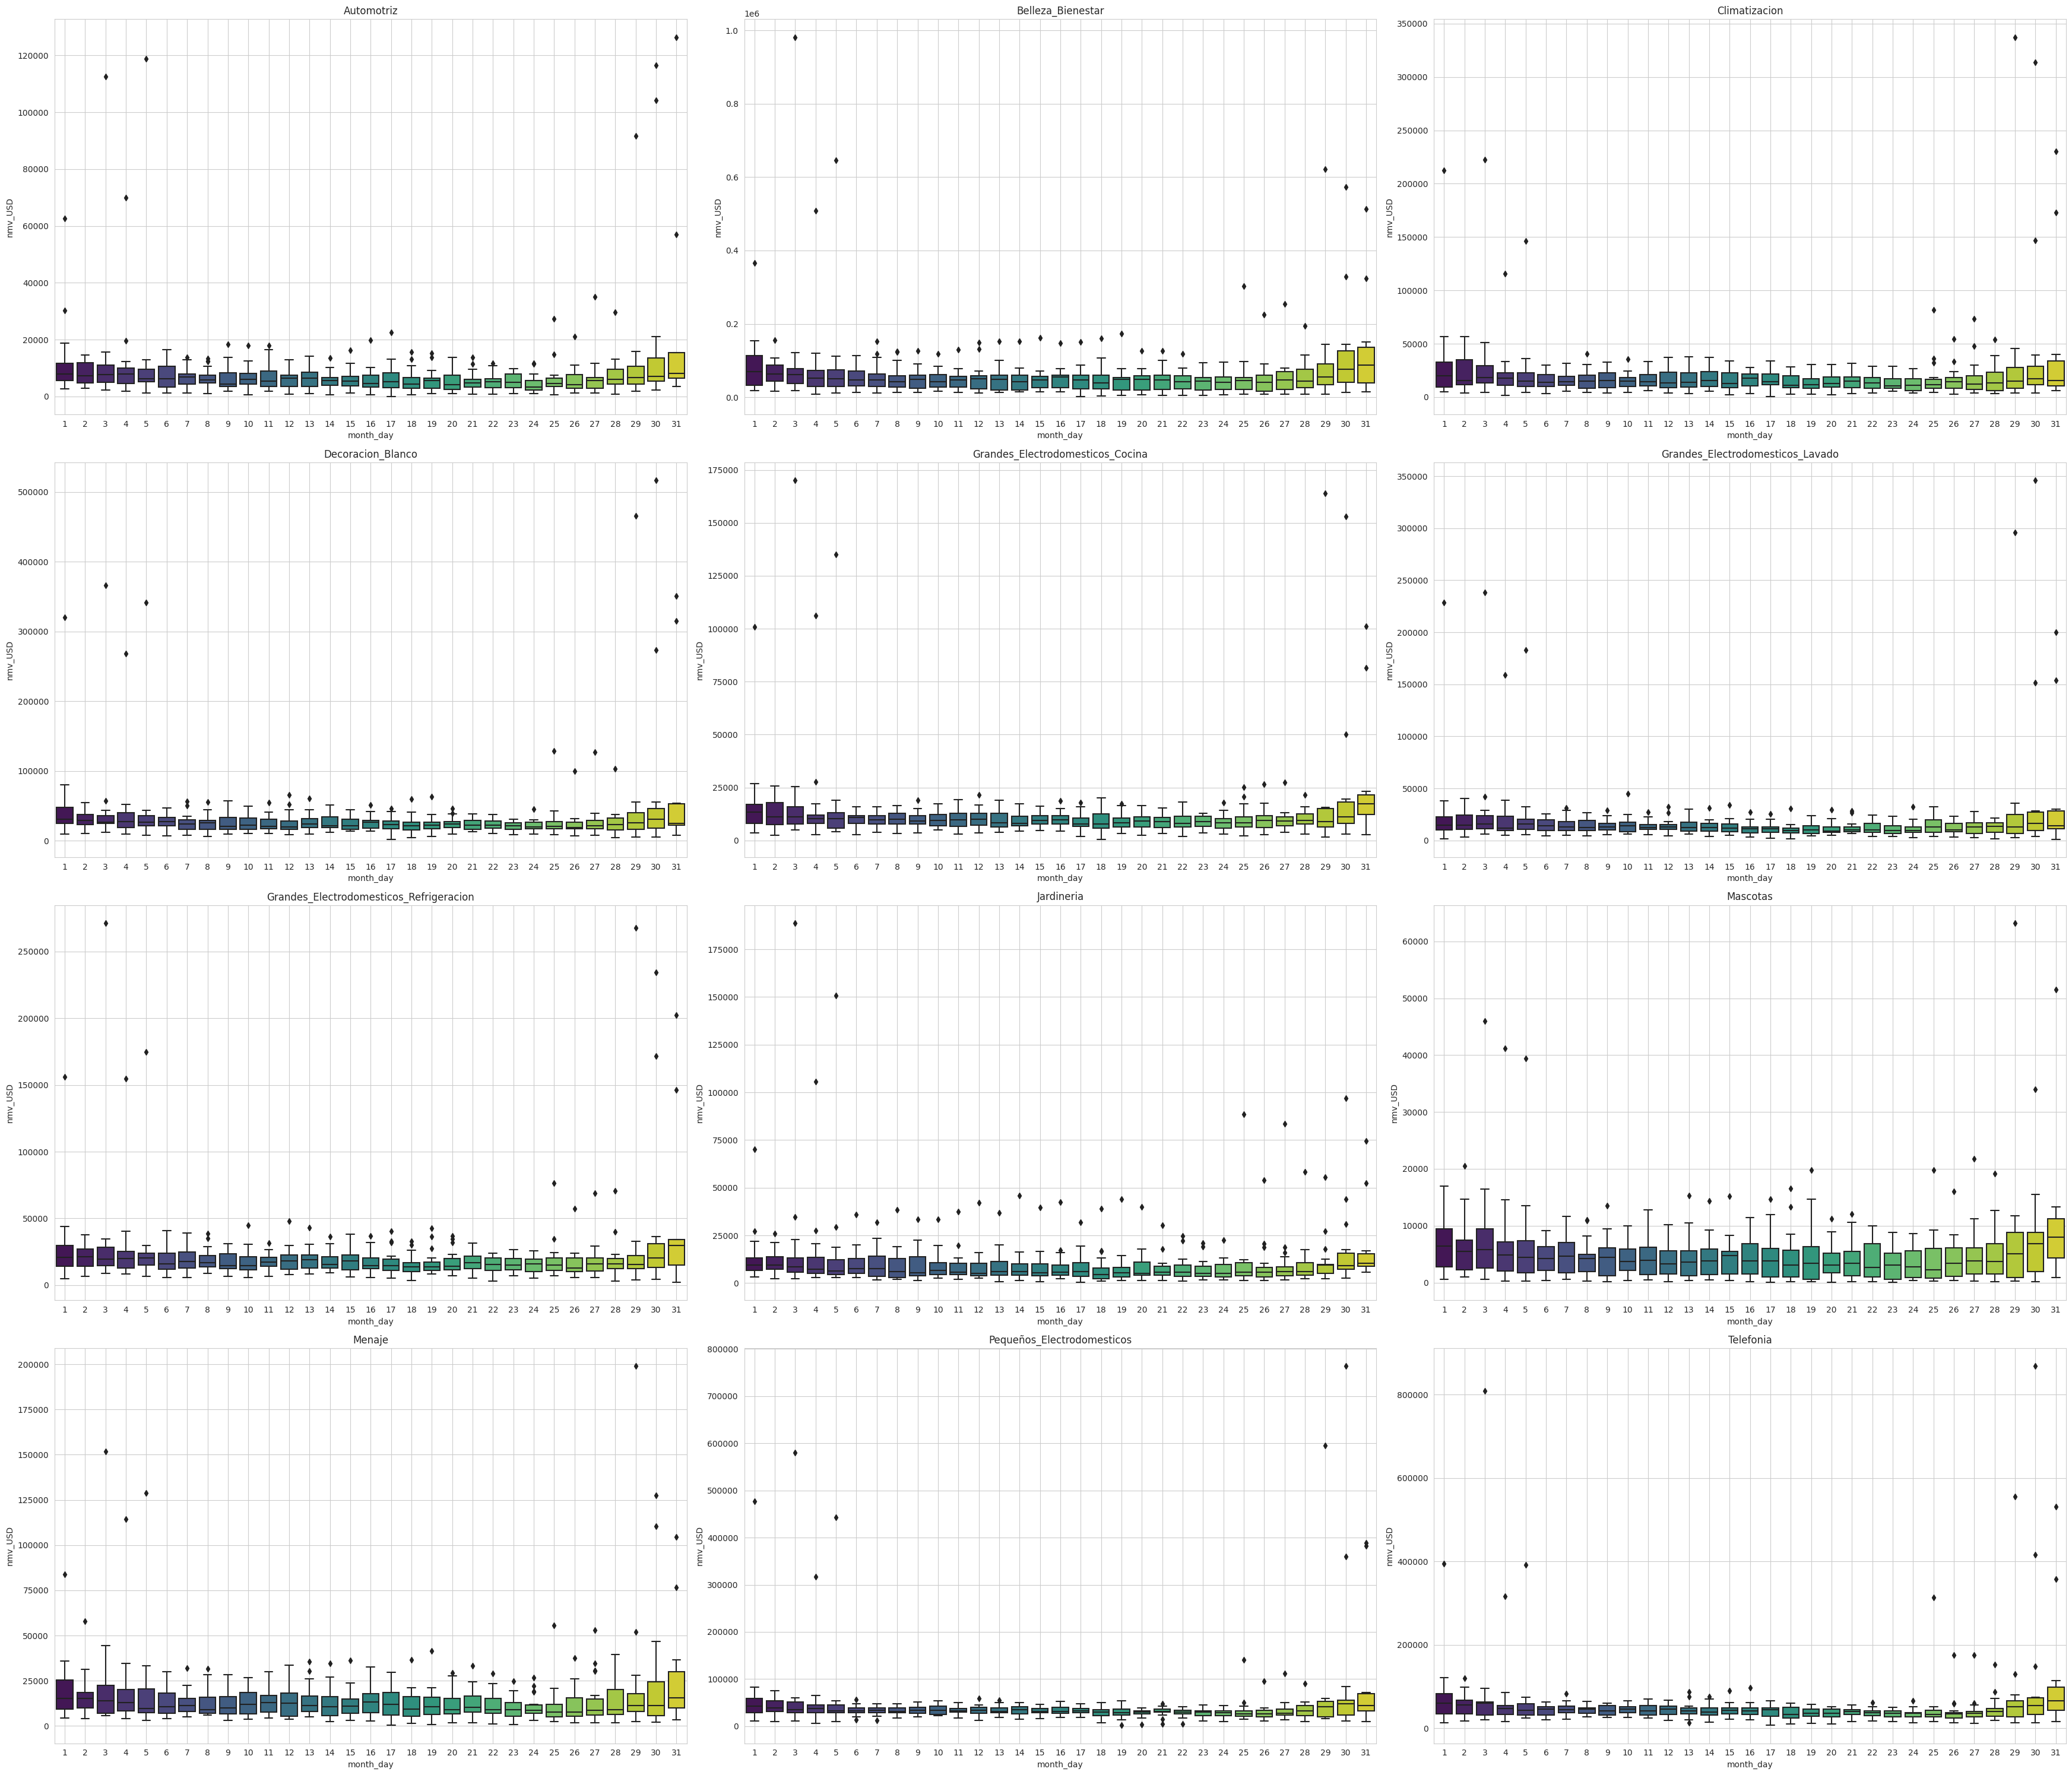

In [ ]:
# Define the variable to graph
x_ = 'nmv_USD'

campaigns = df_raw['campaign'].unique()
cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(35, 30))

for i, campaign in enumerate(campaigns):
    j = i // cols
    k = i % cols

    df = df_raw[df_raw['campaign'] == campaign]

    palette = sns.color_palette("viridis", n_colors=len(df['month_day'].unique()))

    axs[j, k].set_title(campaign)
    sns.boxplot(data=df, x='month_day', y=x_, palette=palette, ax=axs[j, k])
    axs[j, k].set_ylabel(f'{x_}')
    axs[j, k].grid(True)

# Adjust the layout to avoid overlaps
plt.tight_layout()

# Show the graphs
plt.show()


*List format*

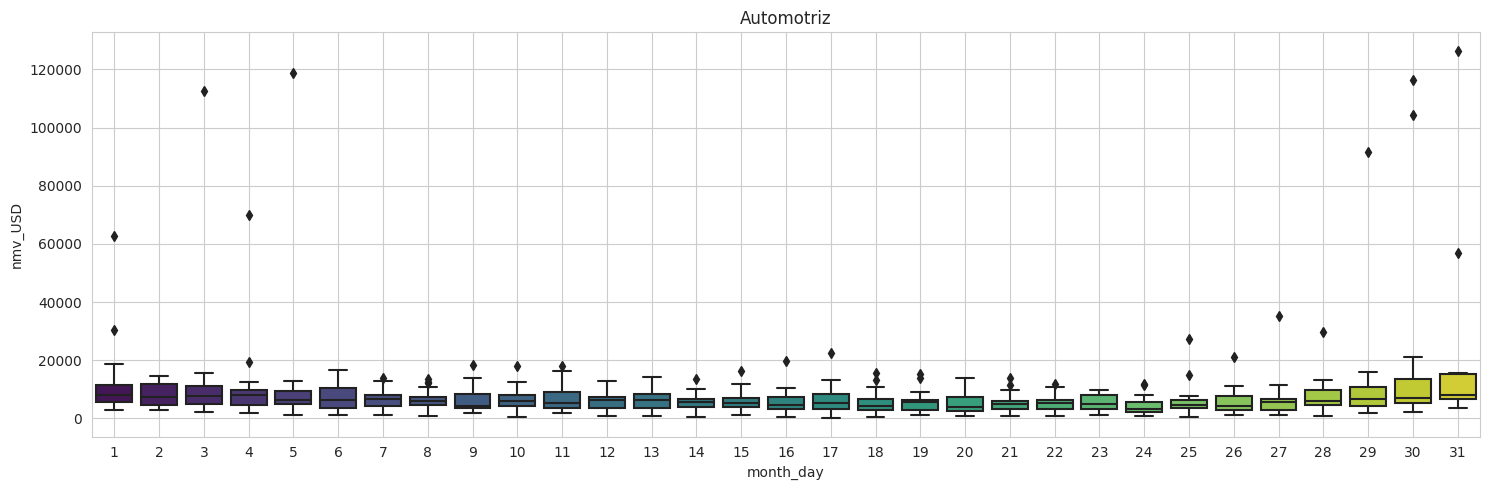

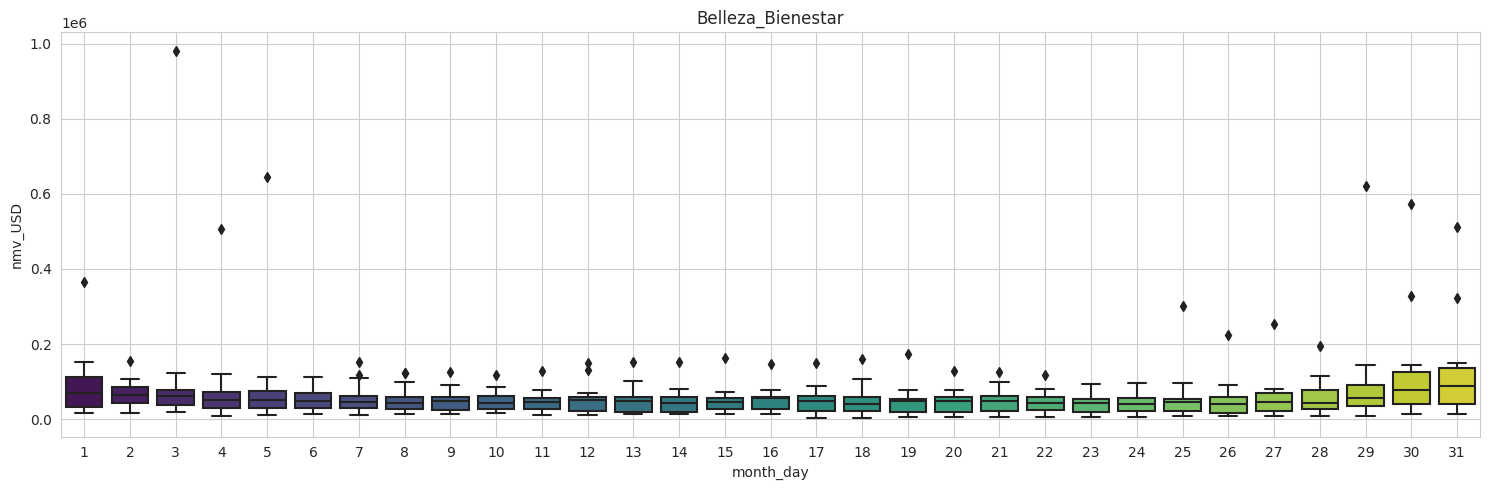

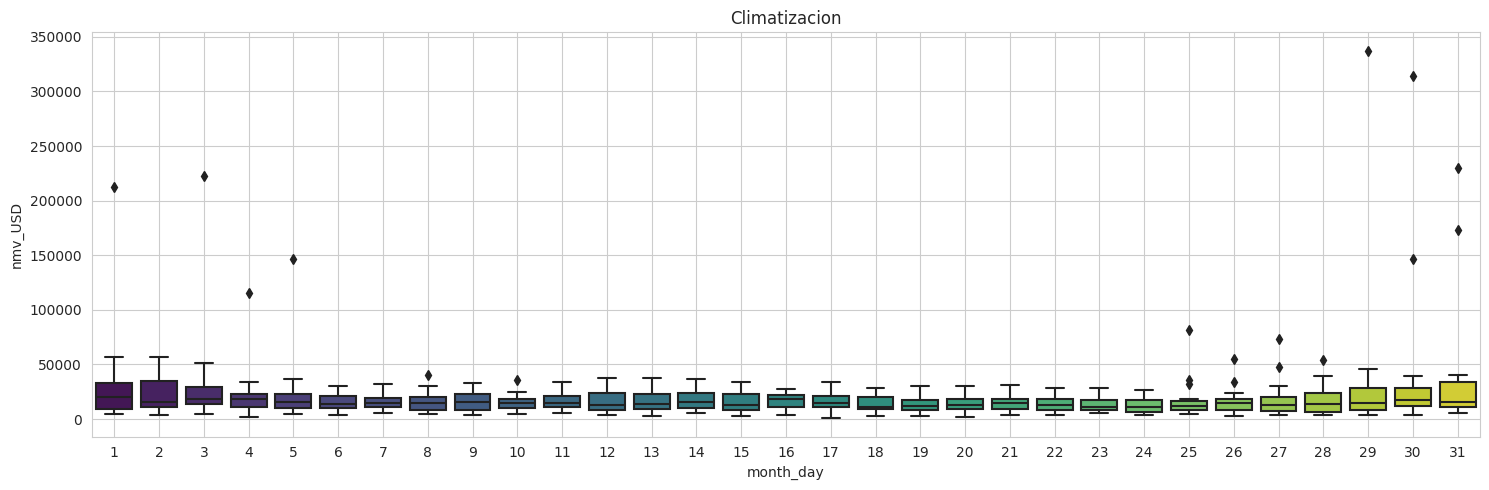

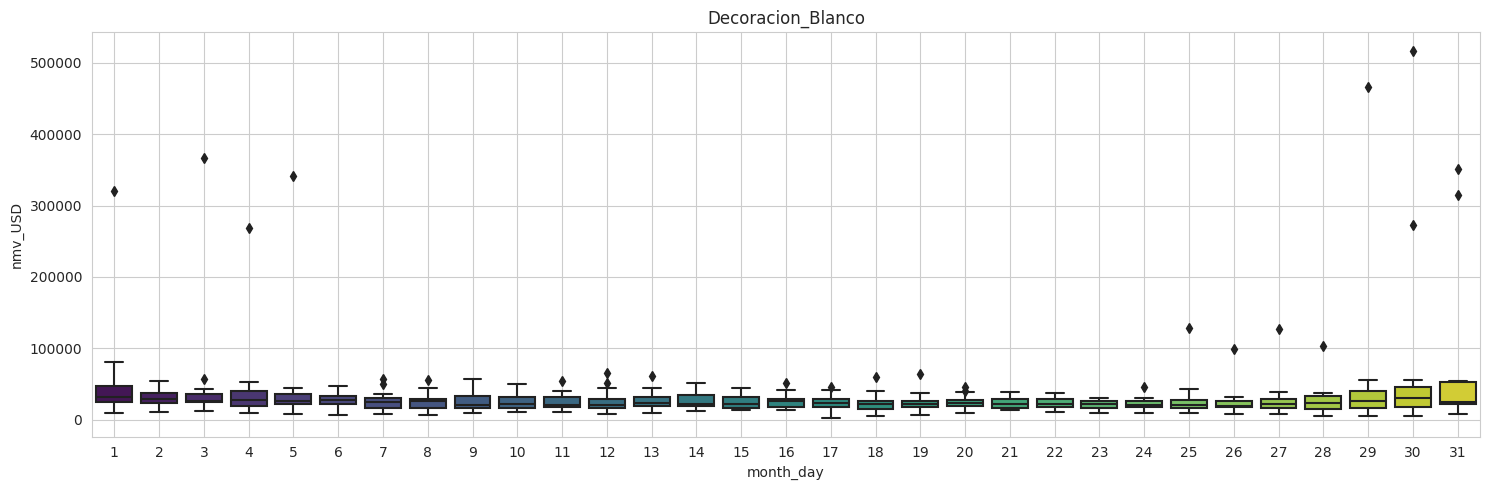

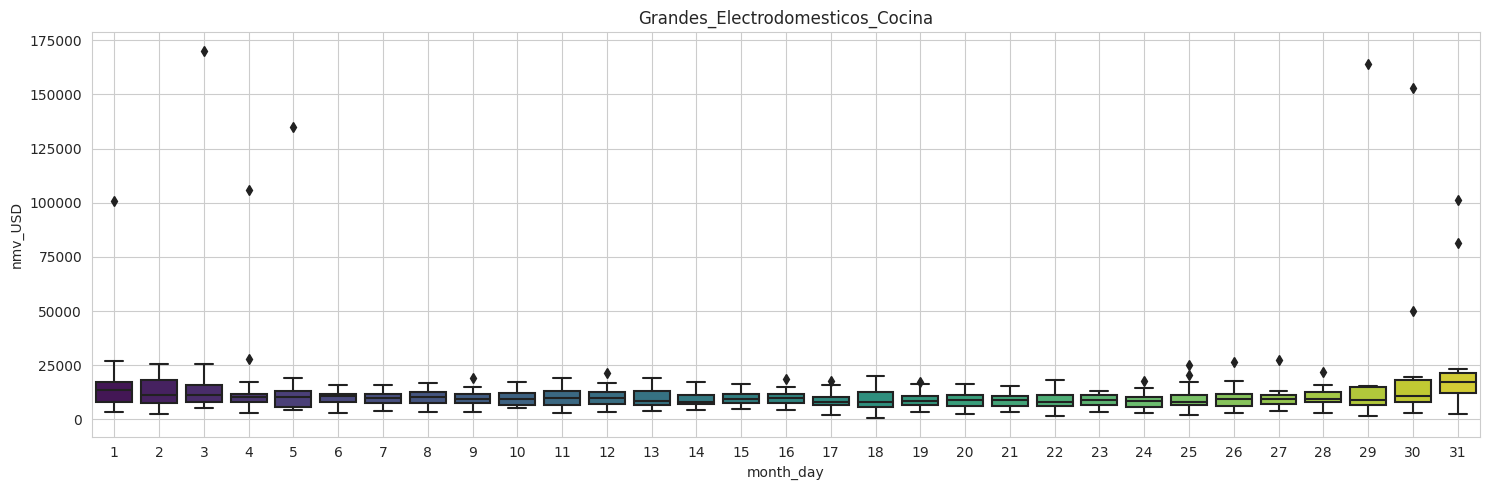

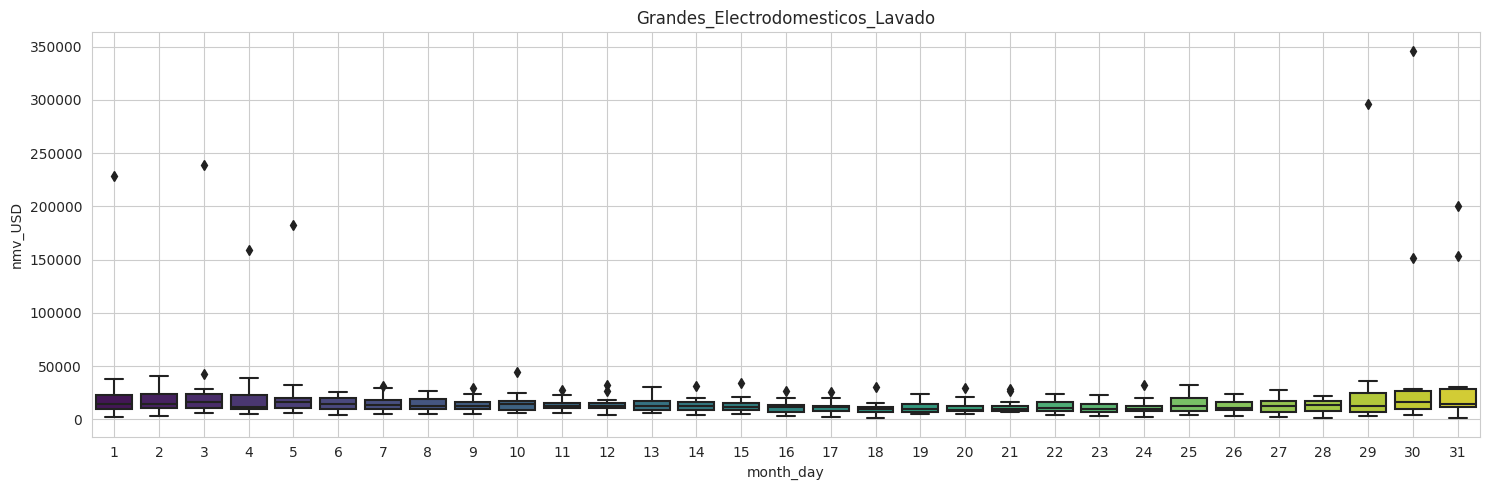

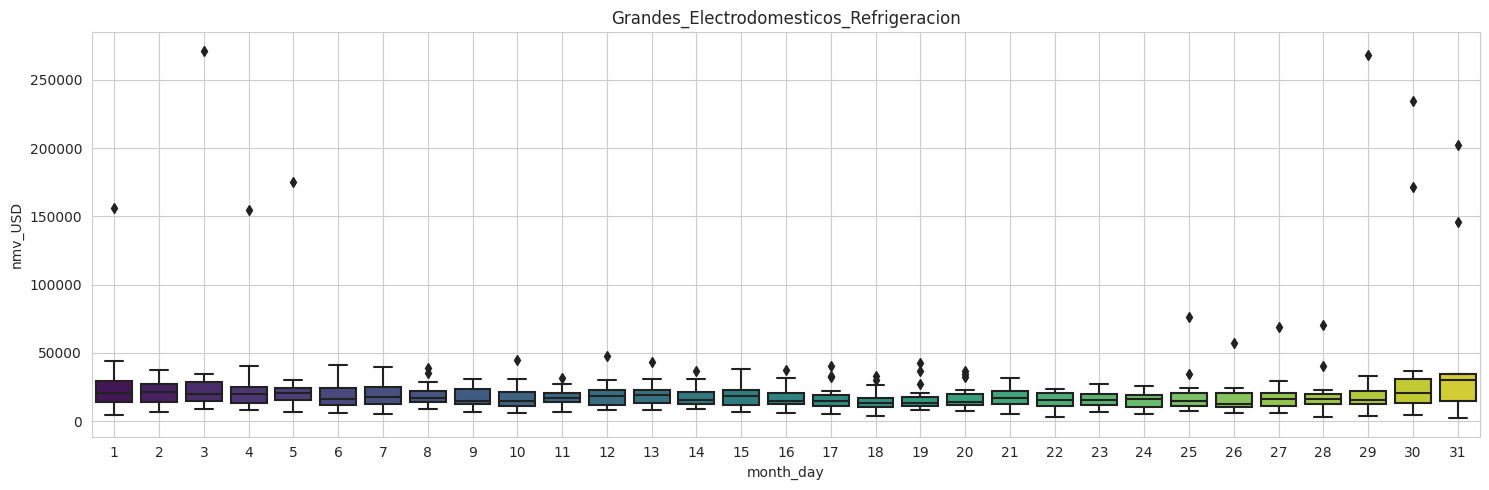

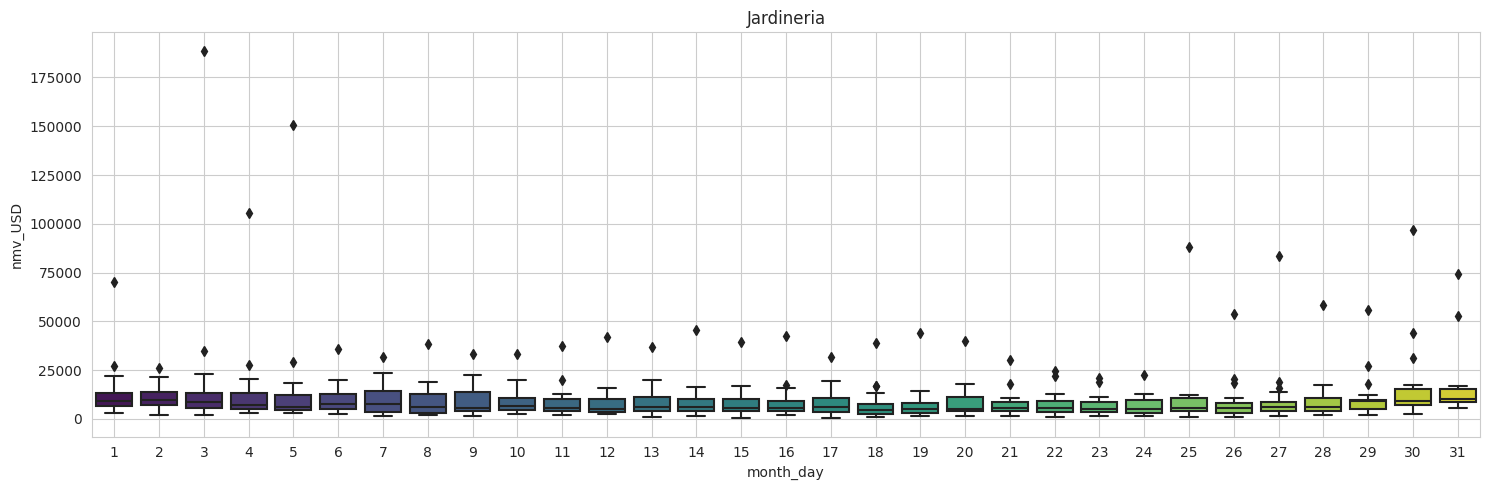

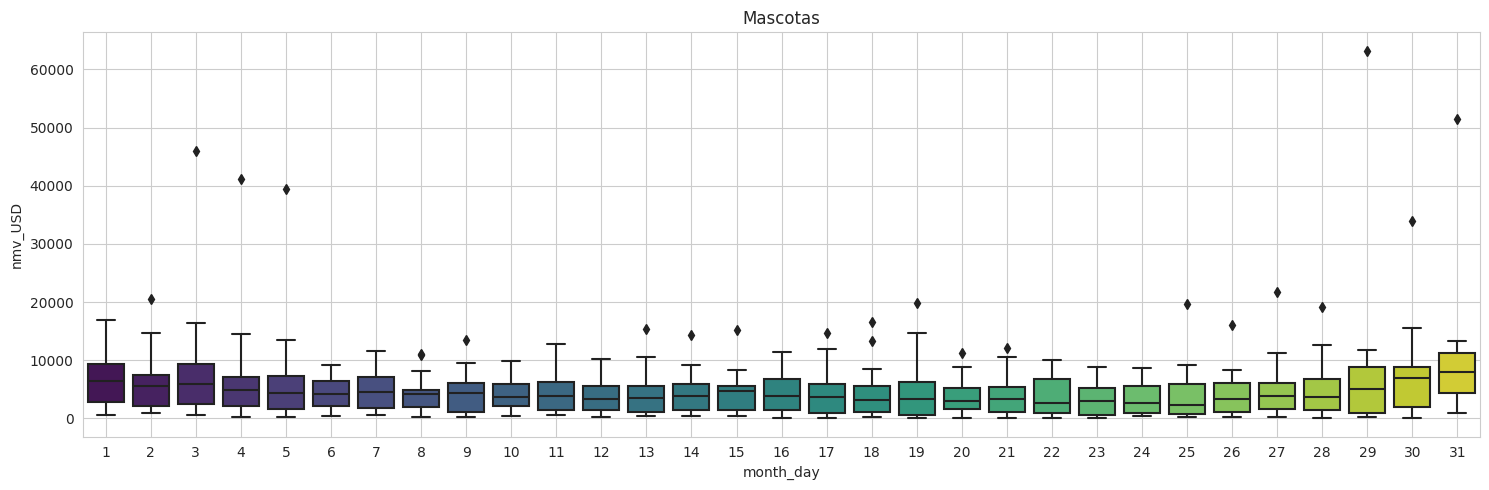

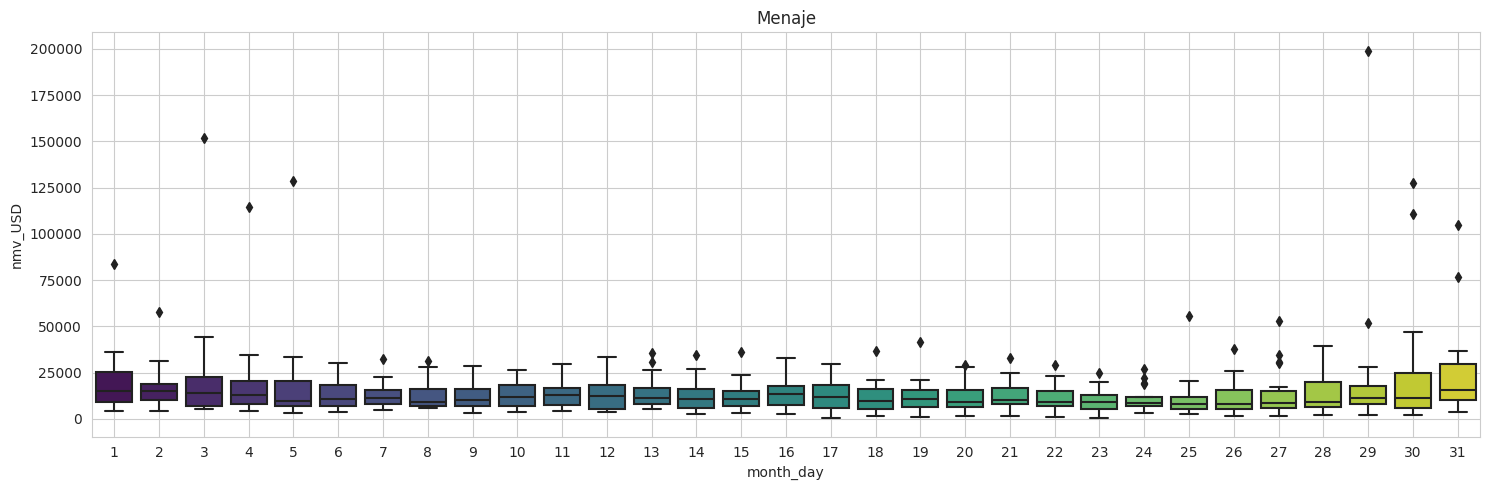

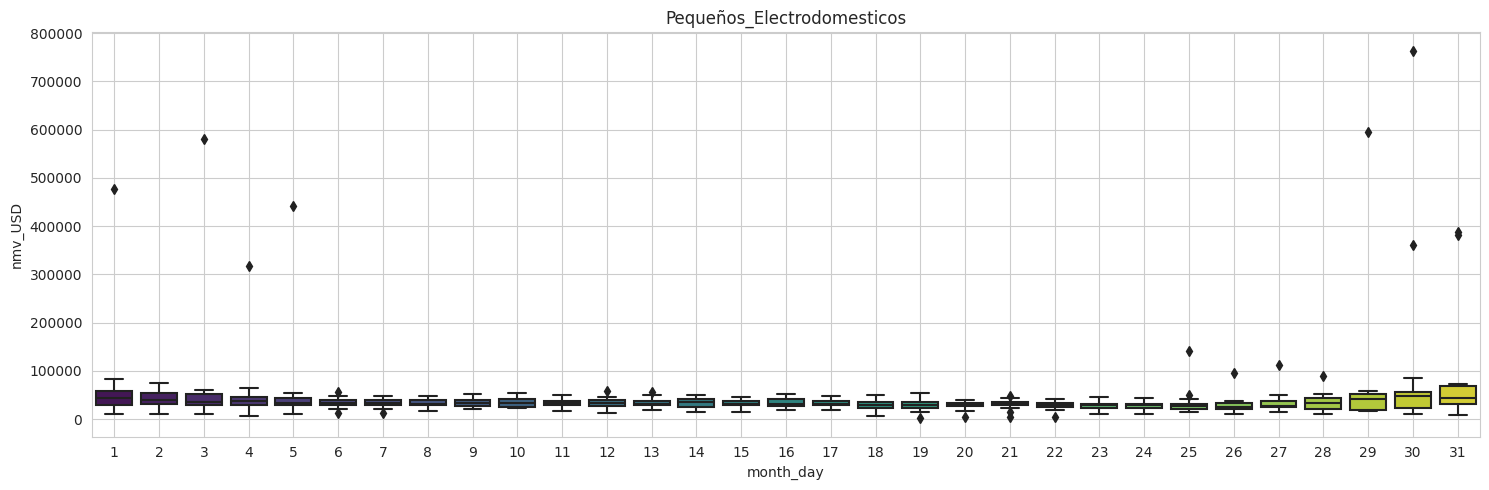

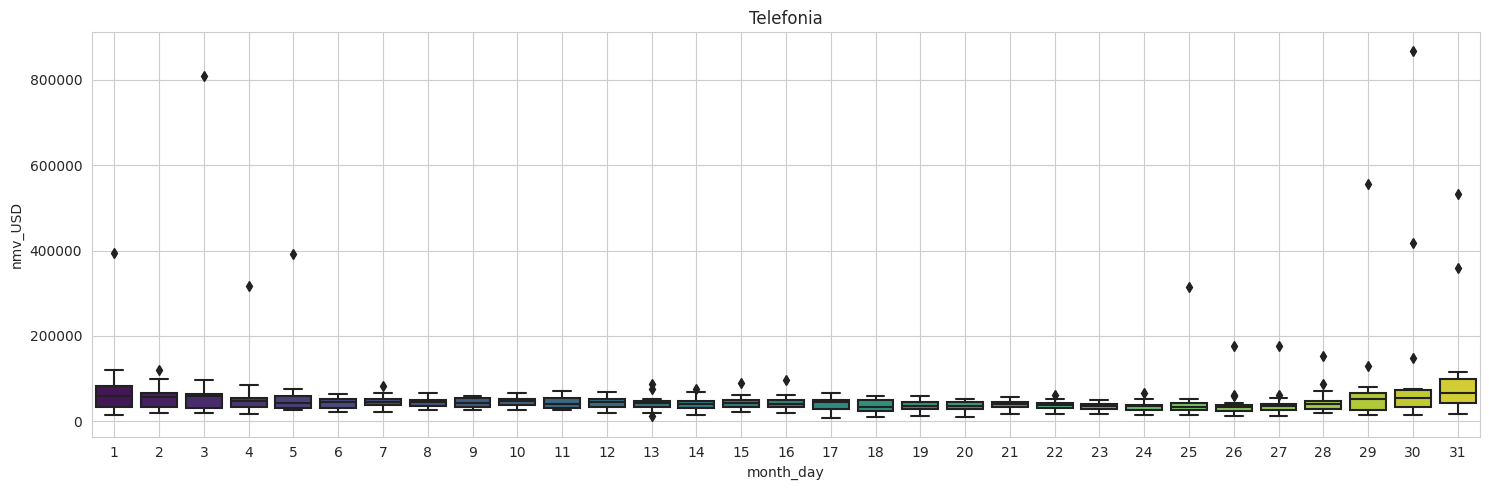

In [ ]:
# Define the variable to graph
x_ = 'nmv_USD'

campaigns = df_raw['campaign'].unique()

for i, campaign in enumerate(campaigns):
    fig, axs = plt.subplots(1, 1, figsize=(15,5))

    df = df_raw[df_raw['campaign'] == campaign]

    palette = sns.color_palette("viridis", n_colors=len(df['month_day'].unique()))

    axs.set_title(campaign)
    sns.boxplot(data=df, x='month_day', y=x_, palette=palette)
    axs.set_ylabel(f'{x_}')
    axs.grid(True)

  # Adjust the layout to avoid overlaps
    plt.tight_layout()

  # Show the graphs
    plt.show()

#### Events/No-event/Cyber days over the time by campaign

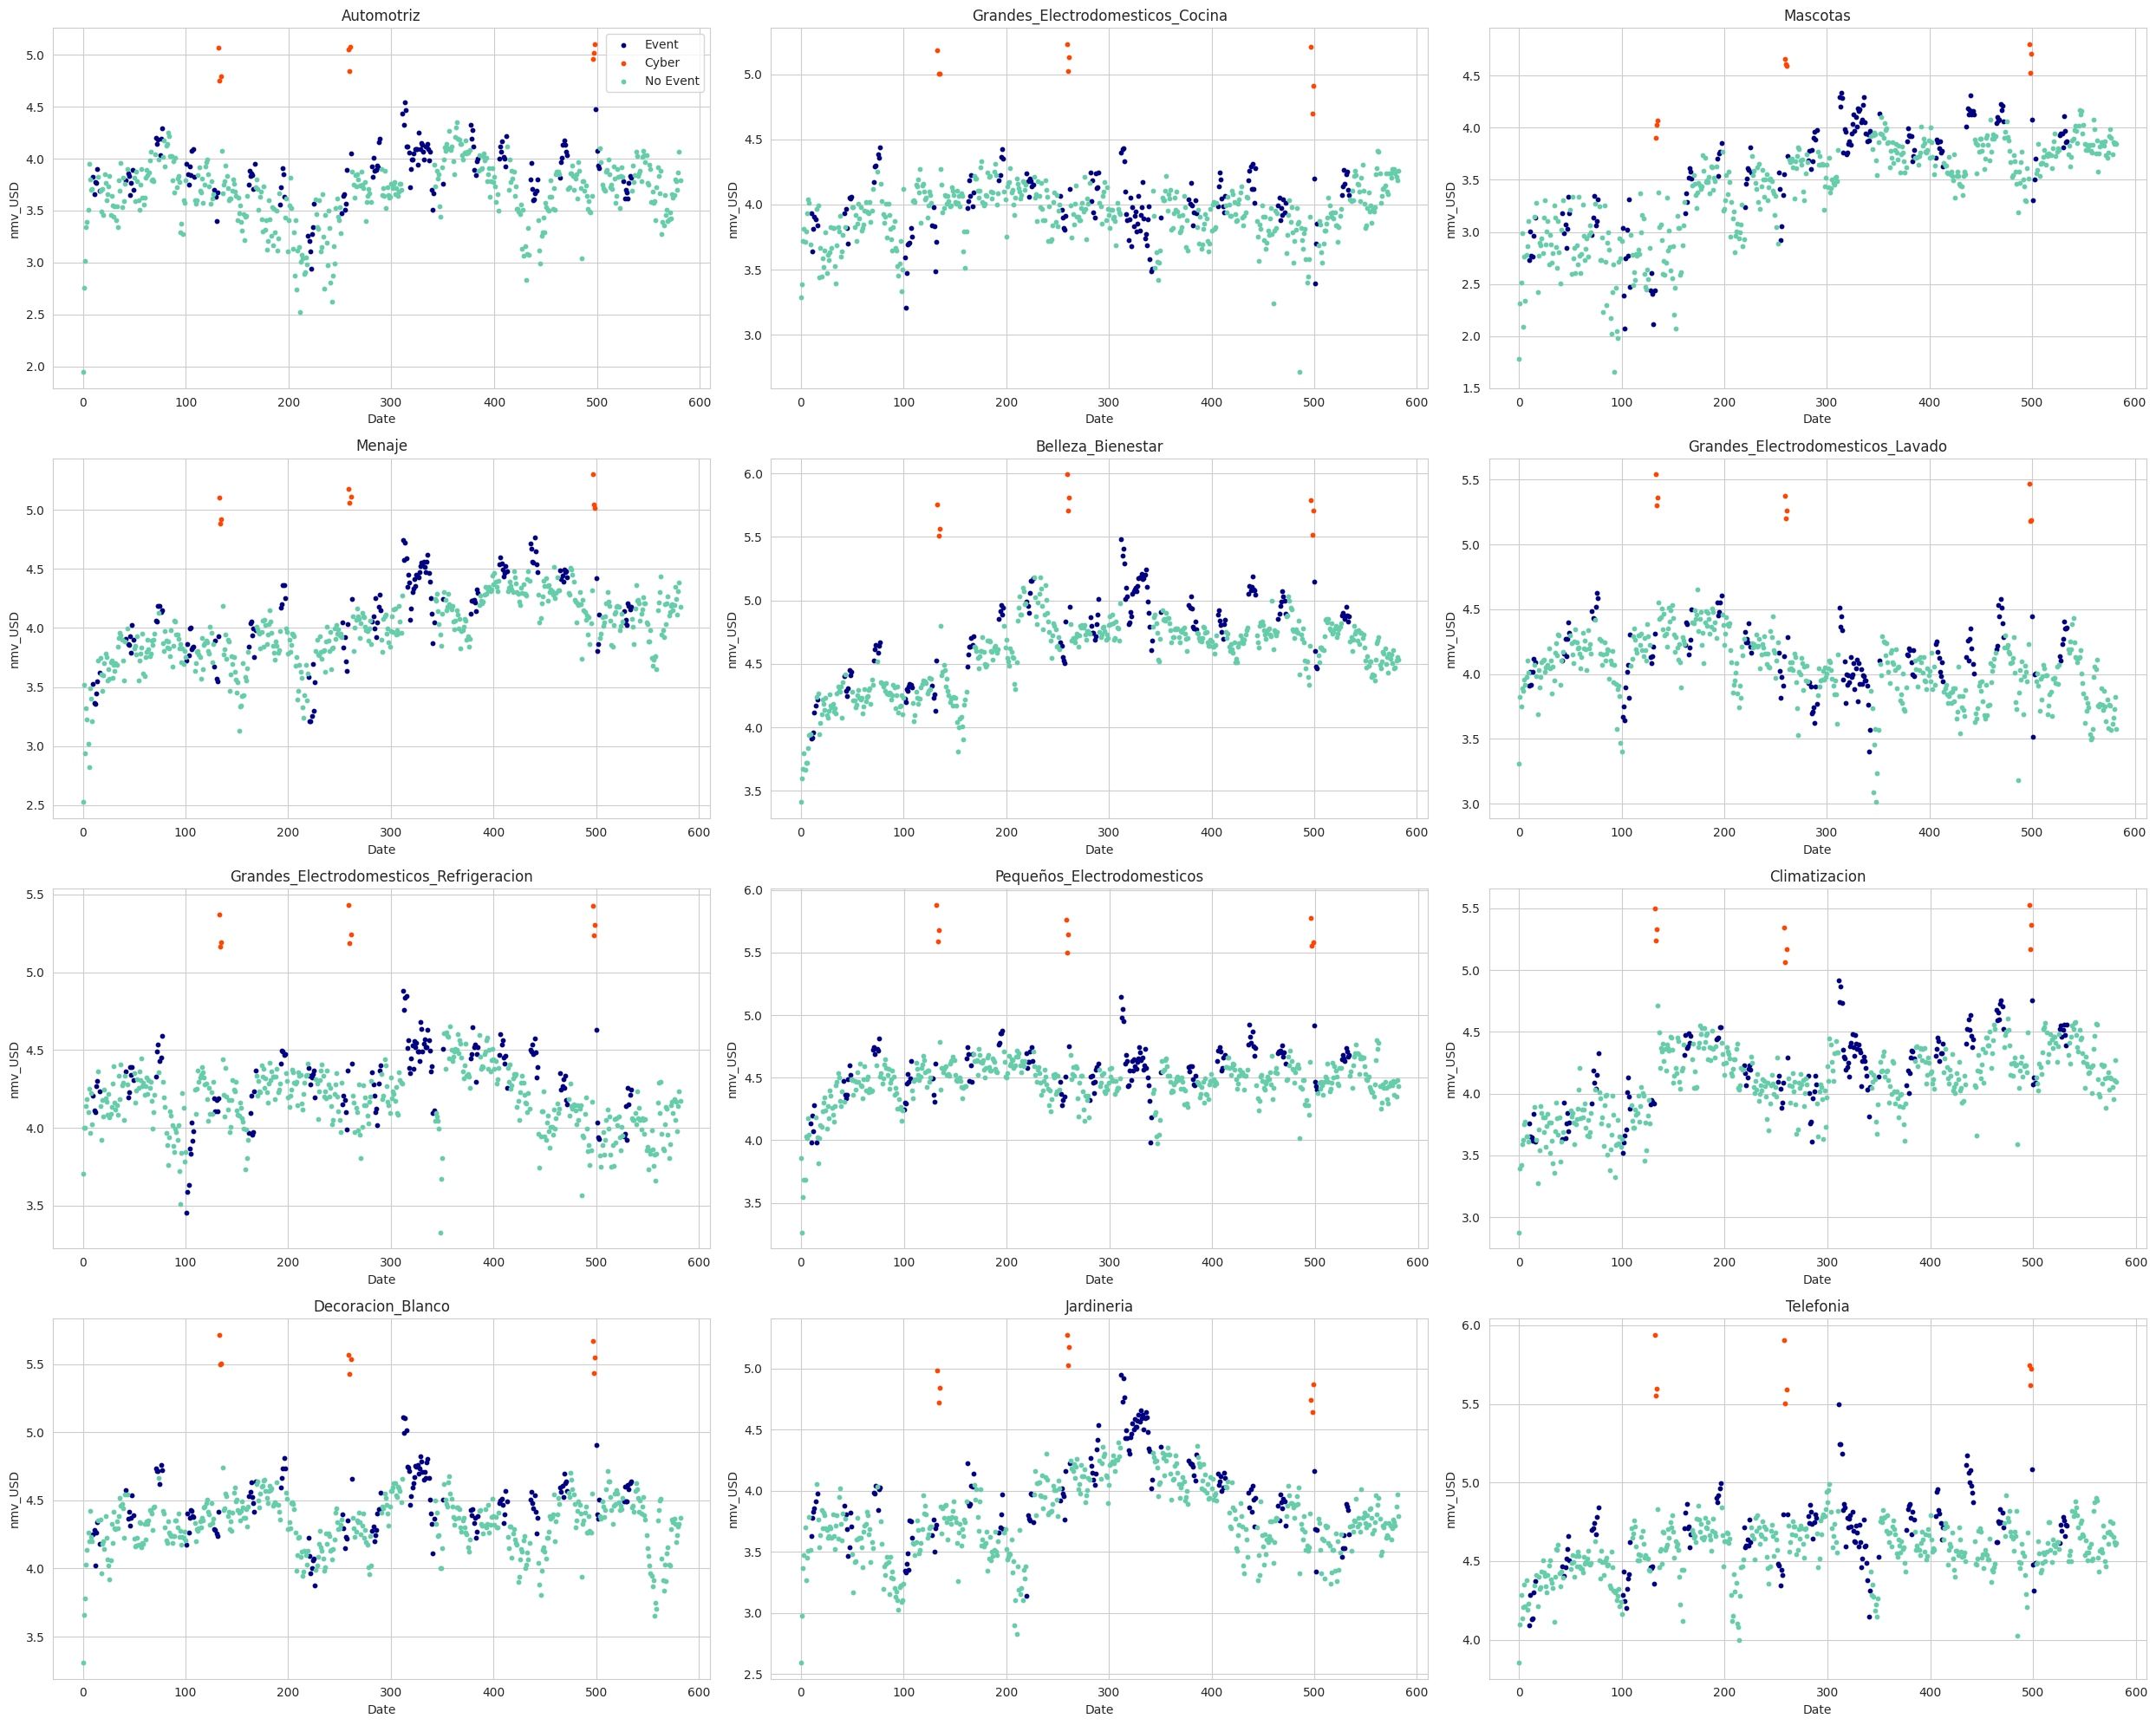

In [ ]:
# Define the variable to graph
y_ = 'nmv_USD'

cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(25,20))
sns.set_style('whitegrid')

for i, campaign in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df = df_raw[(df_raw['campaign']==campaign)]
    df.reset_index(inplace=True)

    dfev=df[(df.is_event==1)&(df.is_cyber==0)]
    dfcy=df[df.is_cyber==1]
    dfne=df[df.is_event==0]

    axs[j,k].set_title(campaign)
    if (j==0)&(k==0):
        axs[j,k].scatter(dfev.index, np.log10(1.0 + dfev[y_]), s=10, color='navy', label='Event')
        axs[j,k].scatter(dfcy.index, np.log10(1.0 + dfcy[y_]), s=10, color='orangered', label='Cyber')
        axs[j,k].scatter(dfne.index, np.log10(1.0 + dfne[y_]), s=10, color='mediumaquamarine', label='No Event') #'cadetblue'
        axs[j,k].legend()
    else:
        if (j==0)&(k==1):
            axs[j,k].scatter(dfev.index, np.log10(1.0 + dfev[y_]), s=10, color='navy')
            axs[j,k].scatter(dfcy.index, np.log10(1.0 + dfcy[y_]), s=10, color='orangered')
            axs[j,k].scatter(dfne.index, np.log10(1.0 + dfne[y_]), s=10, color='mediumaquamarine')
        else:
            axs[j,k].scatter(dfev.index, np.log10(1.0 + dfev[y_]), s=10, color='navy')
            axs[j,k].scatter(dfcy.index, np.log10(1.0 + dfcy[y_]), s=10, color='orangered')
            axs[j,k].scatter(dfne.index, np.log10(1.0 + dfne[y_]), s=10, color='mediumaquamarine')
    axs[j,k].set_xlabel('Date')
    axs[j,k].set_ylabel(f'{y_}')
    axs[j,k].grid(True)
plt.tight_layout()

#### NMV distribution by campaign distinguishing by WEEKEND / WEEK day

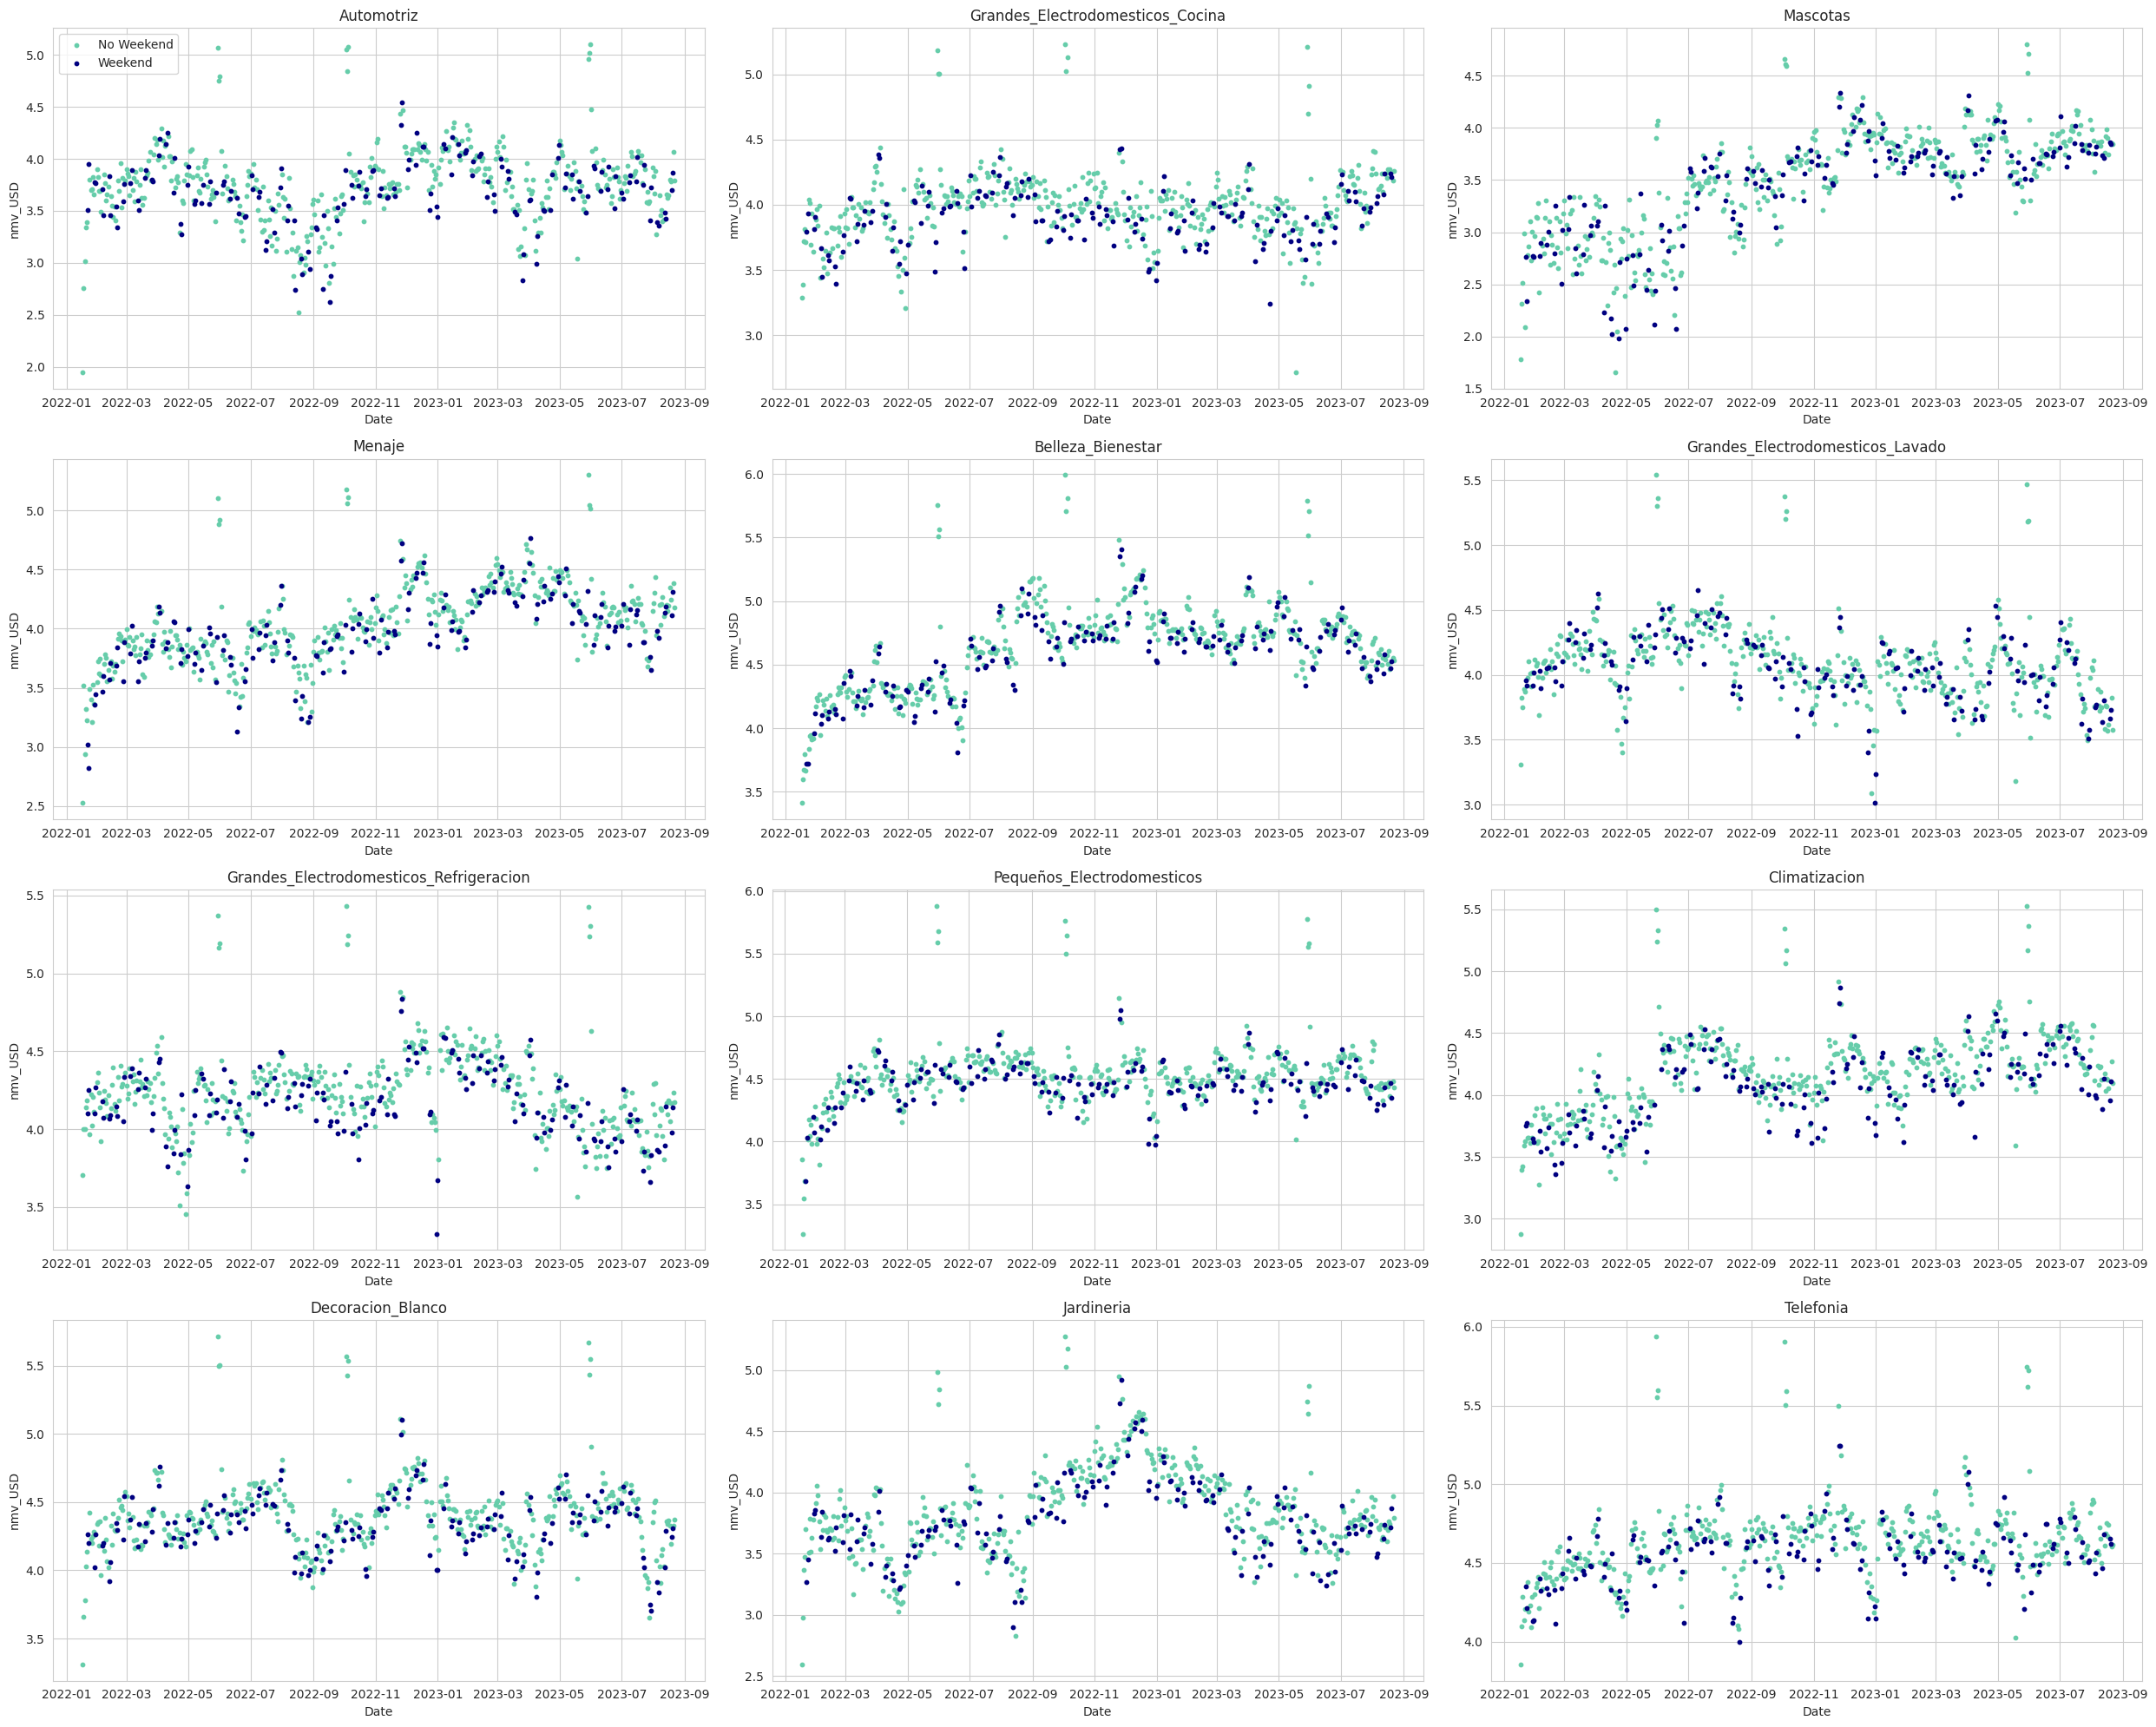

In [ ]:
# Define the variable to graph
y_ = 'nmv_USD'

cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(25,20))
sns.set_style('whitegrid')

for i, campaign in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    #df = df_raw[(df_raw['campaign']==campaign)&(df_raw['is_cyber']==0)&(df_raw['cost']>0)]
    df = df_raw[(df_raw['campaign']==campaign)]
    #df.reset_index(inplace=True)

    dfnw=df[(df.is_week_day==1)]   #& (df.is_cyber==0)
    dfw=df[df.is_week_day==0 & (df.is_cyber==0)] # 0 -> weekend

    axs[j,k].set_title(campaign)
    if (j==0)&(k==0):
        axs[j,k].scatter(dfnw.index, np.log10(1.0 + dfnw[y_]), s=10, color='mediumaquamarine', label='No Weekend')
        axs[j,k].scatter(dfw.index, np.log10(1.0 + dfw[y_]), s=10, color='navy', label='Weekend')
        axs[j,k].legend()
    else:
        if (j==0)&(k==1):
            axs[j,k].scatter(dfnw.index, np.log10(1.0 + dfnw[y_]), s=10, color='mediumaquamarine')
            axs[j,k].scatter(dfw.index, np.log10(1.0 + dfw[y_]), s=10, color='navy')
        else:
            axs[j,k].scatter(dfnw.index, np.log10(1.0 + dfnw[y_]), s=10, color='mediumaquamarine') #'skyblue'
            axs[j,k].scatter(dfw.index, np.log10(1.0 + dfw[y_]), s=10, color='navy')

    axs[j,k].set_xlabel('Date')
    axs[j,k].set_ylabel(f'{y_}')
    axs[j,k].grid(True)
plt.tight_layout()

#### Events/No-event/Cyber days NMV distribution by campaign

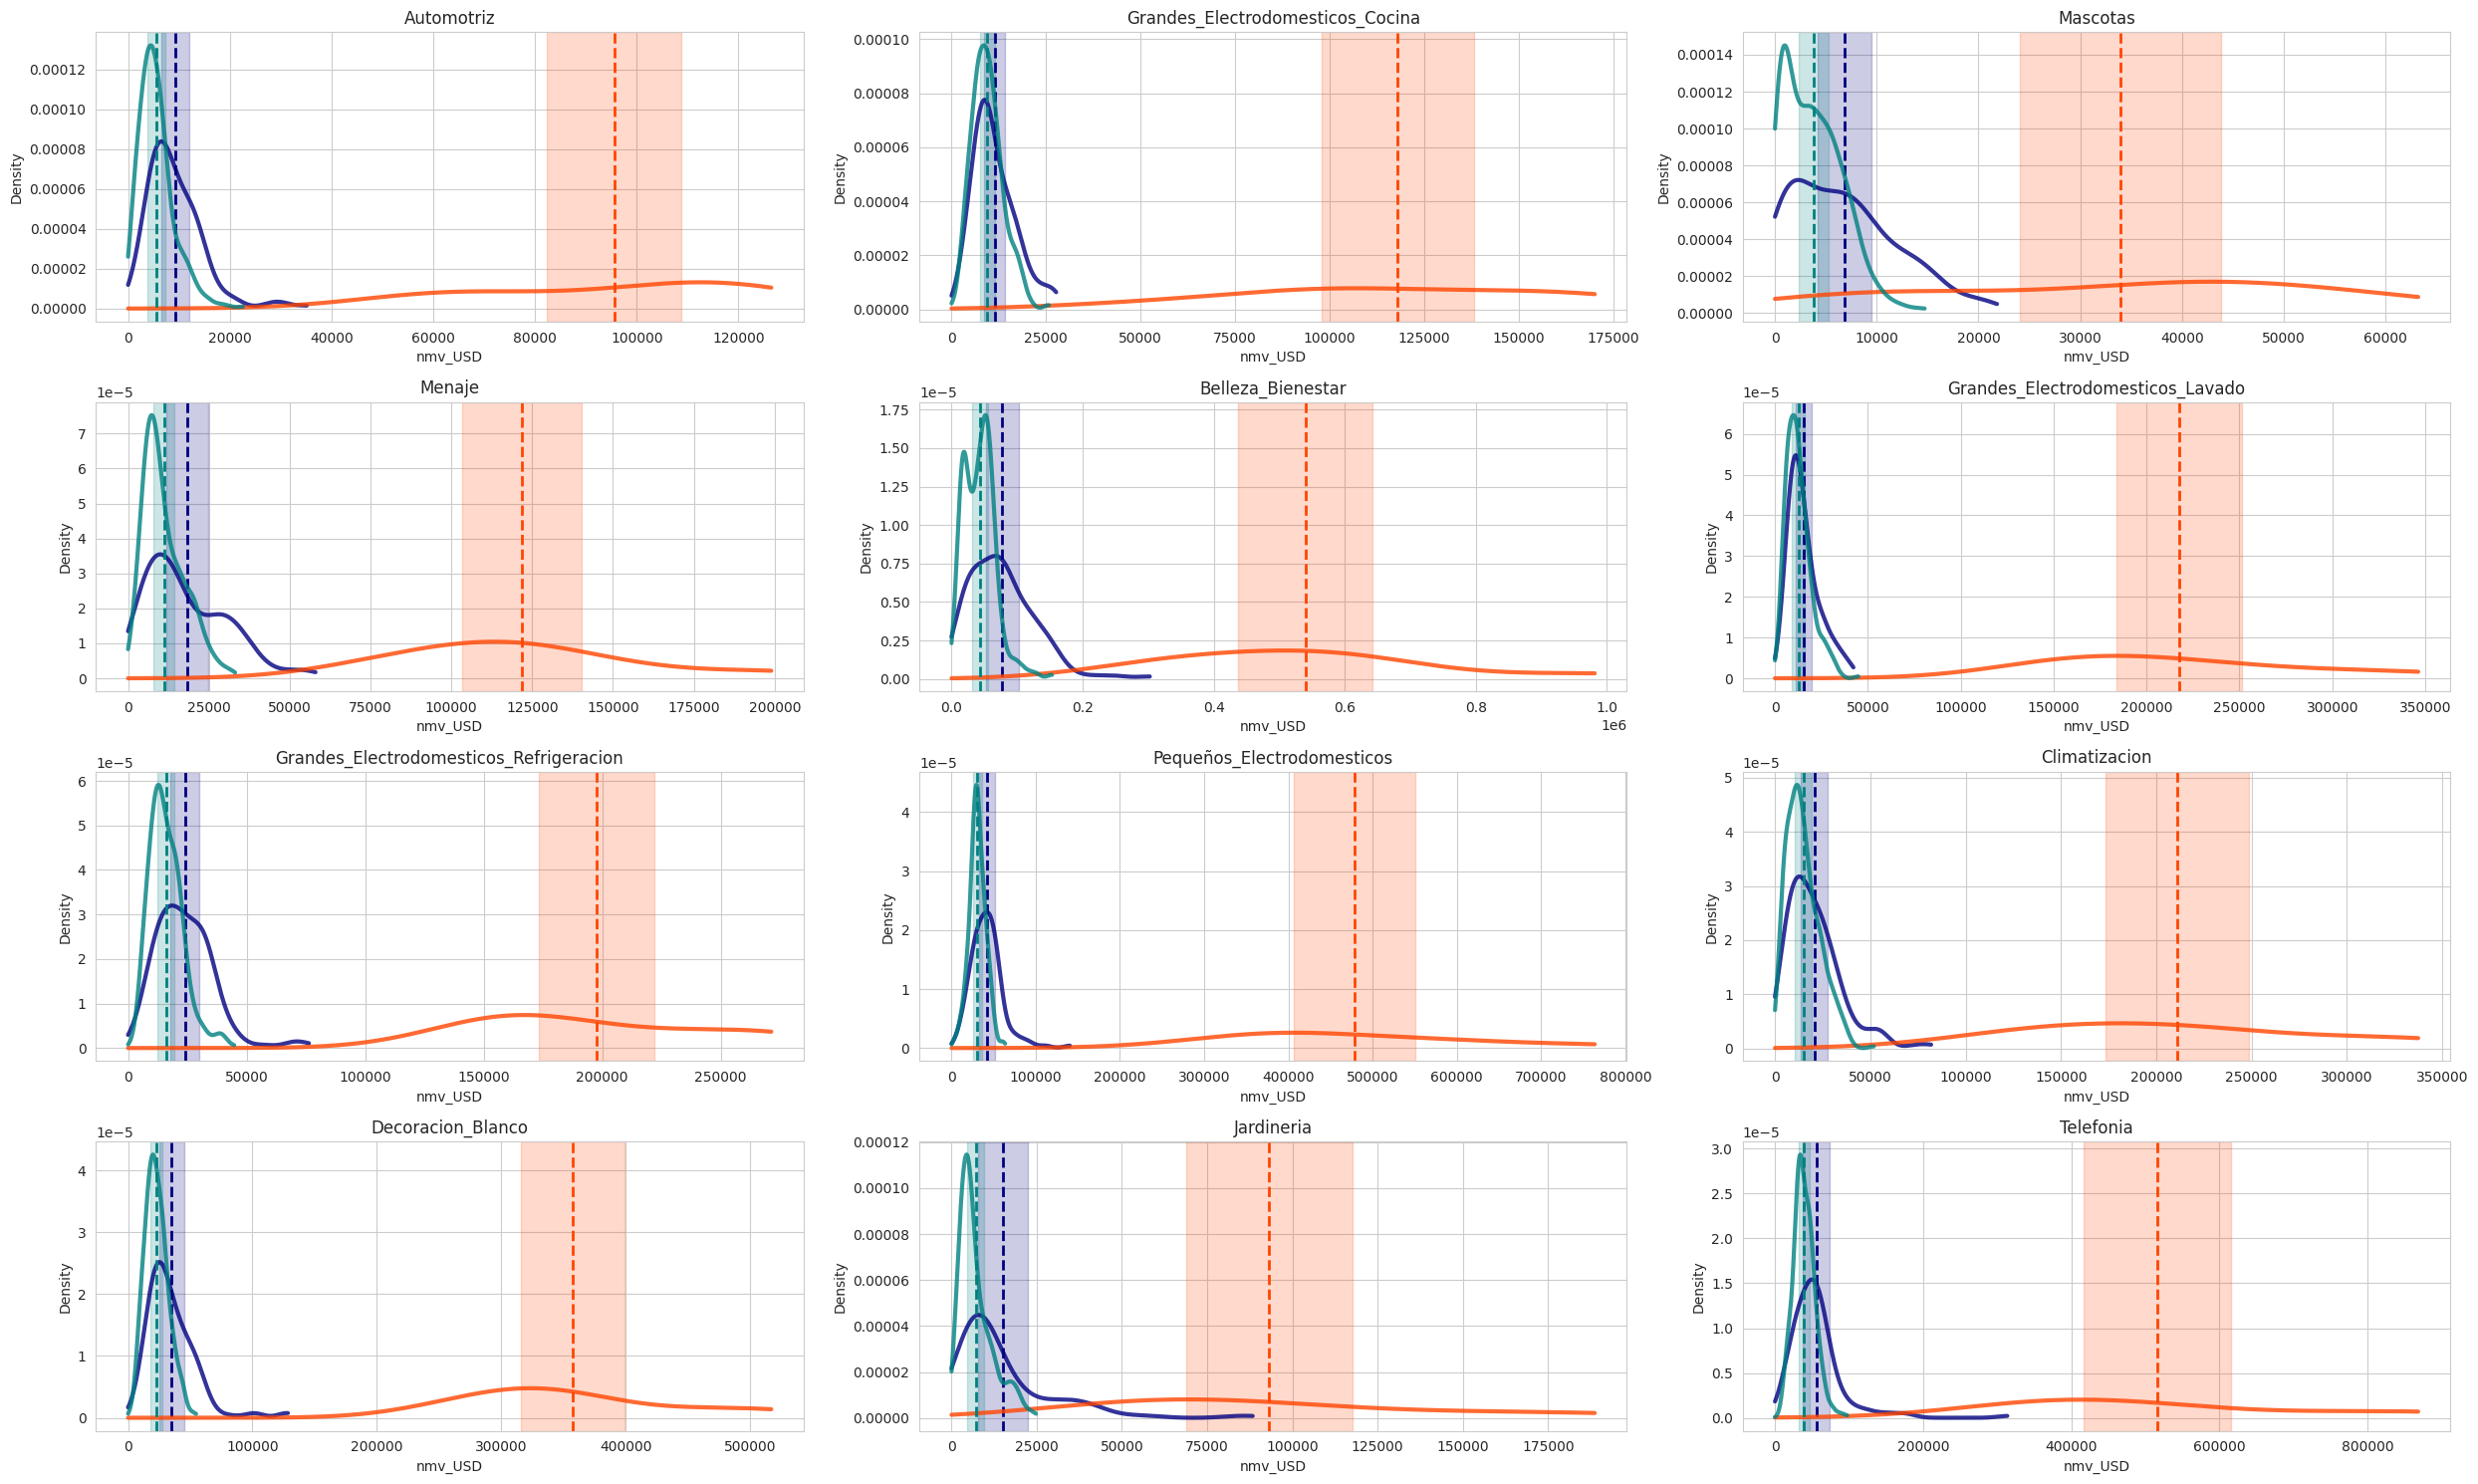

In [ ]:
x_ = 'nmv_USD'

cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(25,15))
sns.set_style('whitegrid')

for i, campaign in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)
    df = df_raw[(df_raw['campaign']==campaign)]

    dfev=df[(df.is_event==1)&(df.is_cyber==0)]
    dfcy=df[df.is_cyber==1]
    dfne=df[df.is_event==0]

    axs[j,k].set_title(campaign)
    if (j==0)&(k==0):
        v = dfev[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='navy', linewidth=3, alpha=0.8, label='Event')
        axs[j,k].axvline(v.mean(), color='navy', linestyle='--', linewidth=2, label='Mean')
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='navy', label='Std.')

        v = dfcy[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='orangered', linewidth=3, alpha=0.8, label='Cyber')
        axs[j,k].axvline(v.mean(), color='orangered', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='orangered')

        v = dfne[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='teal', linewidth=3, alpha=0.8, label='No Event')
        axs[j,k].axvline(v.mean(), color='teal', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='teal')
        #axs[j,k].legend()
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=0.5)
    else:
        v = dfev[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='navy', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='navy', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='navy')

        v = dfcy[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='orangered', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='orangered', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='orangered')

        v = dfne[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='teal', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='teal', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='teal')

    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel('Density')
    axs[j,k].grid(True)
plt.tight_layout()

#### Events/No-event/Cyber days Budget distribution by campaign

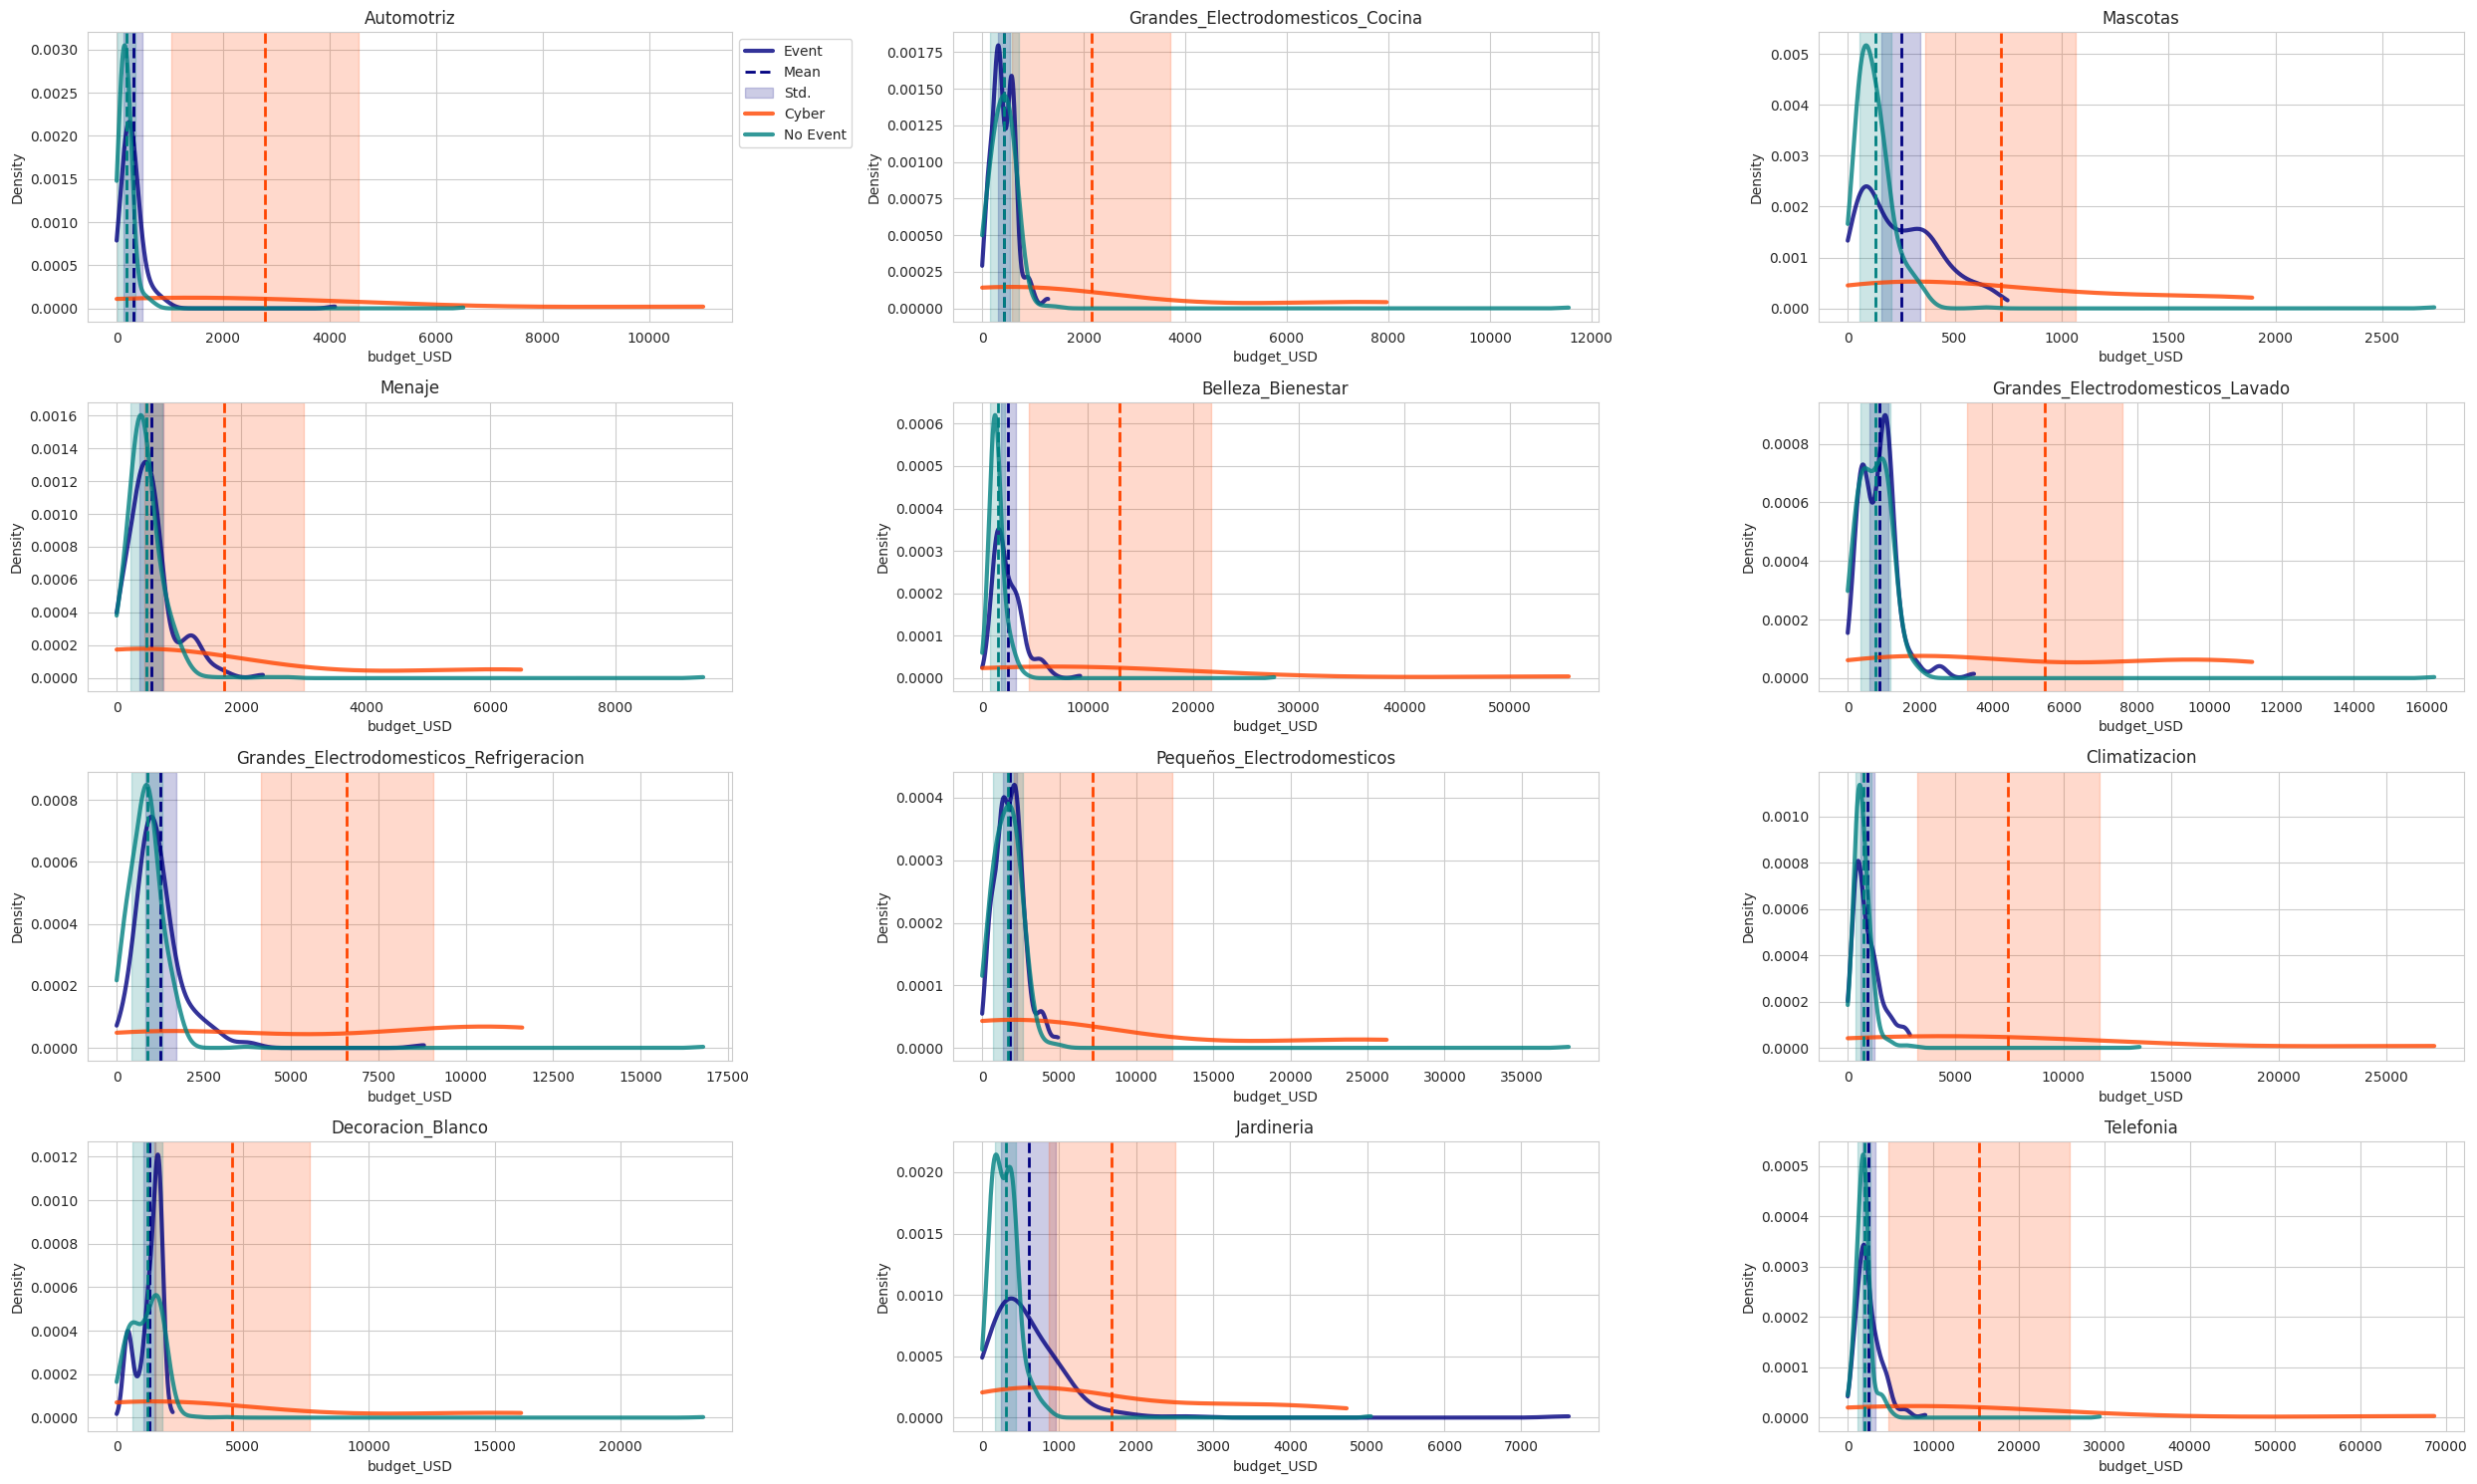

In [ ]:
x_ = 'budget_USD'

cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(25,15))
sns.set_style('whitegrid')

for i, campaign in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)
    df = df_raw[(df_raw['campaign']==campaign)]

    dfev=df[(df.is_event==1)&(df.is_cyber==0)]
    dfcy=df[df.is_cyber==1]
    dfne=df[df.is_event==0]

    axs[j,k].set_title(campaign)
    if (j==0)&(k==0):
        v = dfev[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='navy', linewidth=3, alpha=0.8, label='Event')
        axs[j,k].axvline(v.mean(), color='navy', linestyle='--', linewidth=2, label='Mean')
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='navy', label='Std.')

        v = dfcy[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='orangered', linewidth=3, alpha=0.8, label='Cyber')
        axs[j,k].axvline(v.mean(), color='orangered', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='orangered')

        v = dfne[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='teal', linewidth=3, alpha=0.8, label='No Event')
        axs[j,k].axvline(v.mean(), color='teal', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='teal')
        #axs[j,k].legend()
        axs[j,k].legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=0.5)
    else:
        v = dfev[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='navy', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='navy', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='navy')

        v = dfcy[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='orangered', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='orangered', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='orangered')

        v = dfne[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='teal', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='teal', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='teal')

    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel('Density')
    axs[j,k].grid(True)
plt.tight_layout()

Using the following we can review the ROAS:
x_='nmv_USD'
y_='budget_USD'

(For C/V add "*100")

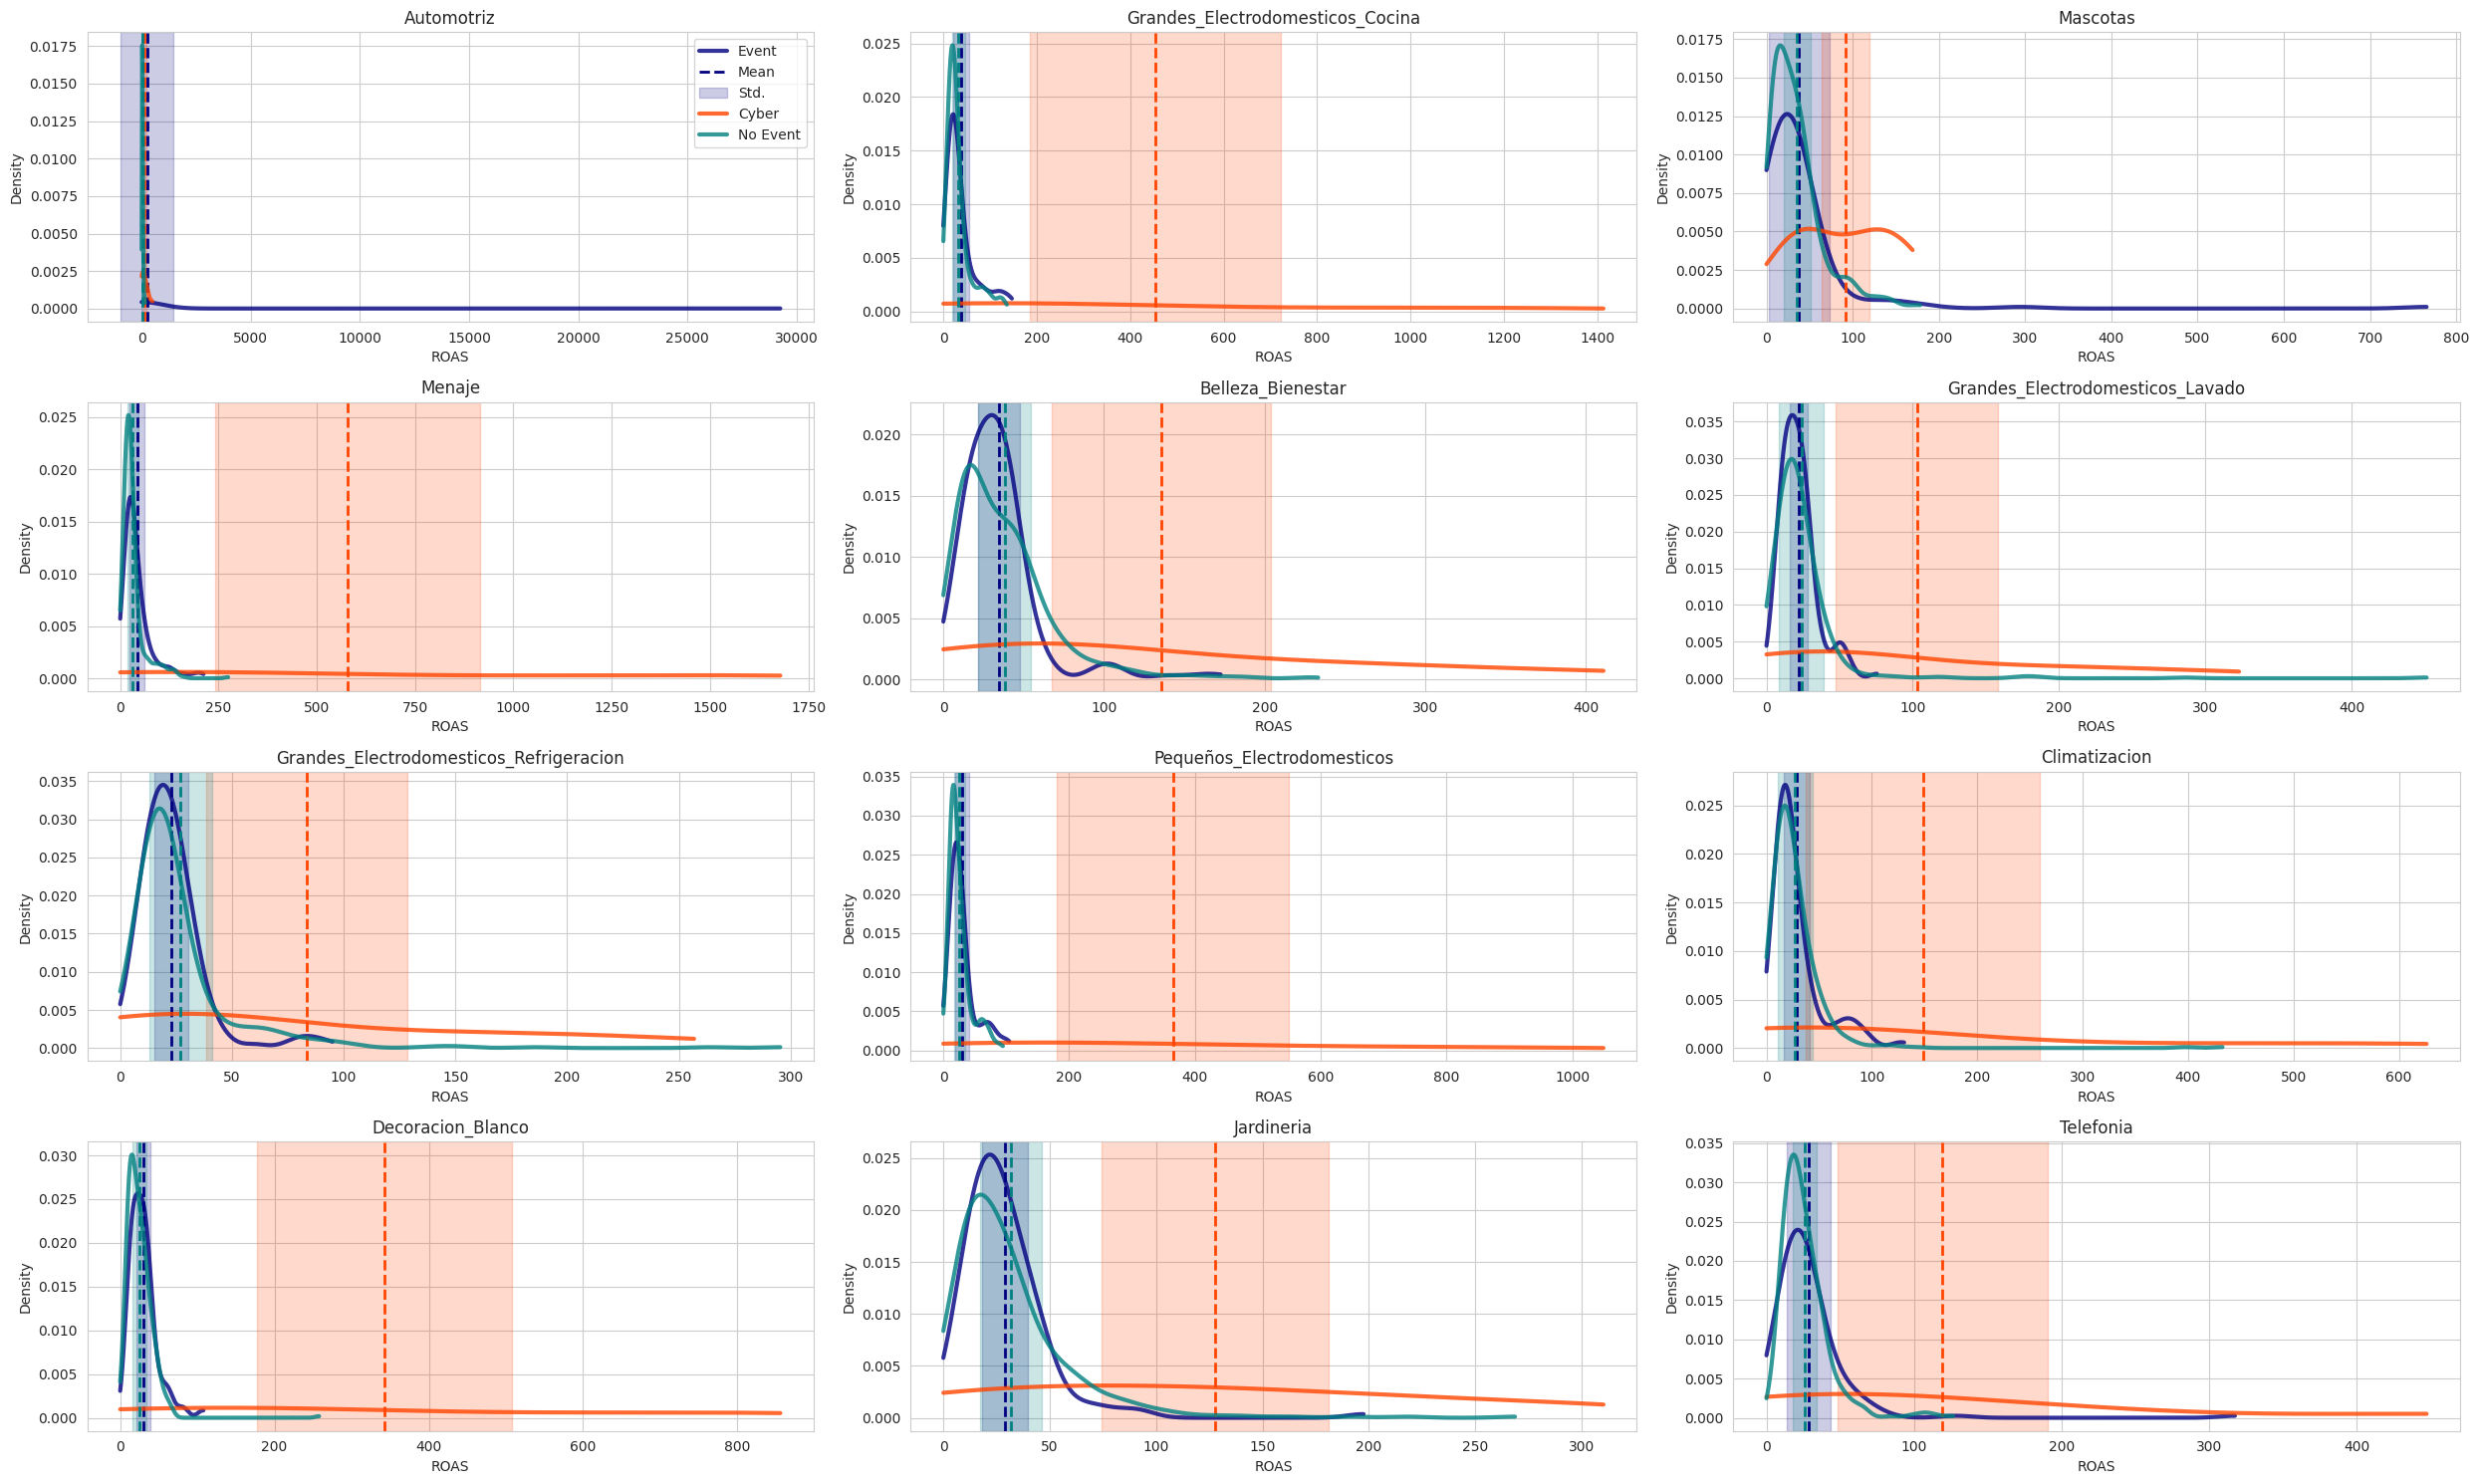

In [ ]:
x_='nmv_USD'
y_='budget_USD'

cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(25,15))
sns.set_style('whitegrid')

for i, campaign in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)
    df = df_raw[(df_raw['campaign']==campaign)]

    dfev=df[(df.is_event==1)&(df.is_cyber==0)]
    dfcy=df[df.is_cyber==1]
    dfne=df[df.is_event==0]

    axs[j,k].set_title(campaign)
    if (j==0)&(k==0):
        v = (dfev[x_]/dfev[y_])
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='navy', linewidth=3, alpha=0.8, label='Event')
        axs[j,k].axvline(v.mean(), color='navy', linestyle='--', linewidth=2, label='Mean')
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='navy', label='Std.')

        v = (dfcy[x_]/dfcy[y_])
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='orangered', linewidth=3, alpha=0.8, label='Cyber')
        axs[j,k].axvline(v.mean(), color='orangered', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='orangered')

        v = (dfne[x_]/dfne[y_])
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='teal', linewidth=3, alpha=0.8, label='No Event')
        axs[j,k].axvline(v.mean(), color='teal', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='teal')
        axs[j,k].legend()
        #axs[j,k].legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=0.5)
    else:
        v = (dfev[x_]/dfev[y_])
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='navy', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='navy', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='navy')

        v = (dfcy[x_]/dfcy[y_])
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='orangered', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='orangered', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='orangered')

        v = (dfne[x_]/dfne[y_])
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='teal', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='teal', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.2, color='teal')

    axs[j,k].set_xlabel('ROAS')
    axs[j,k].set_ylabel('Density')
    axs[j,k].grid(True)
plt.tight_layout()

#### NMV distribution by campaigns on Weekend/No-weekend distribution

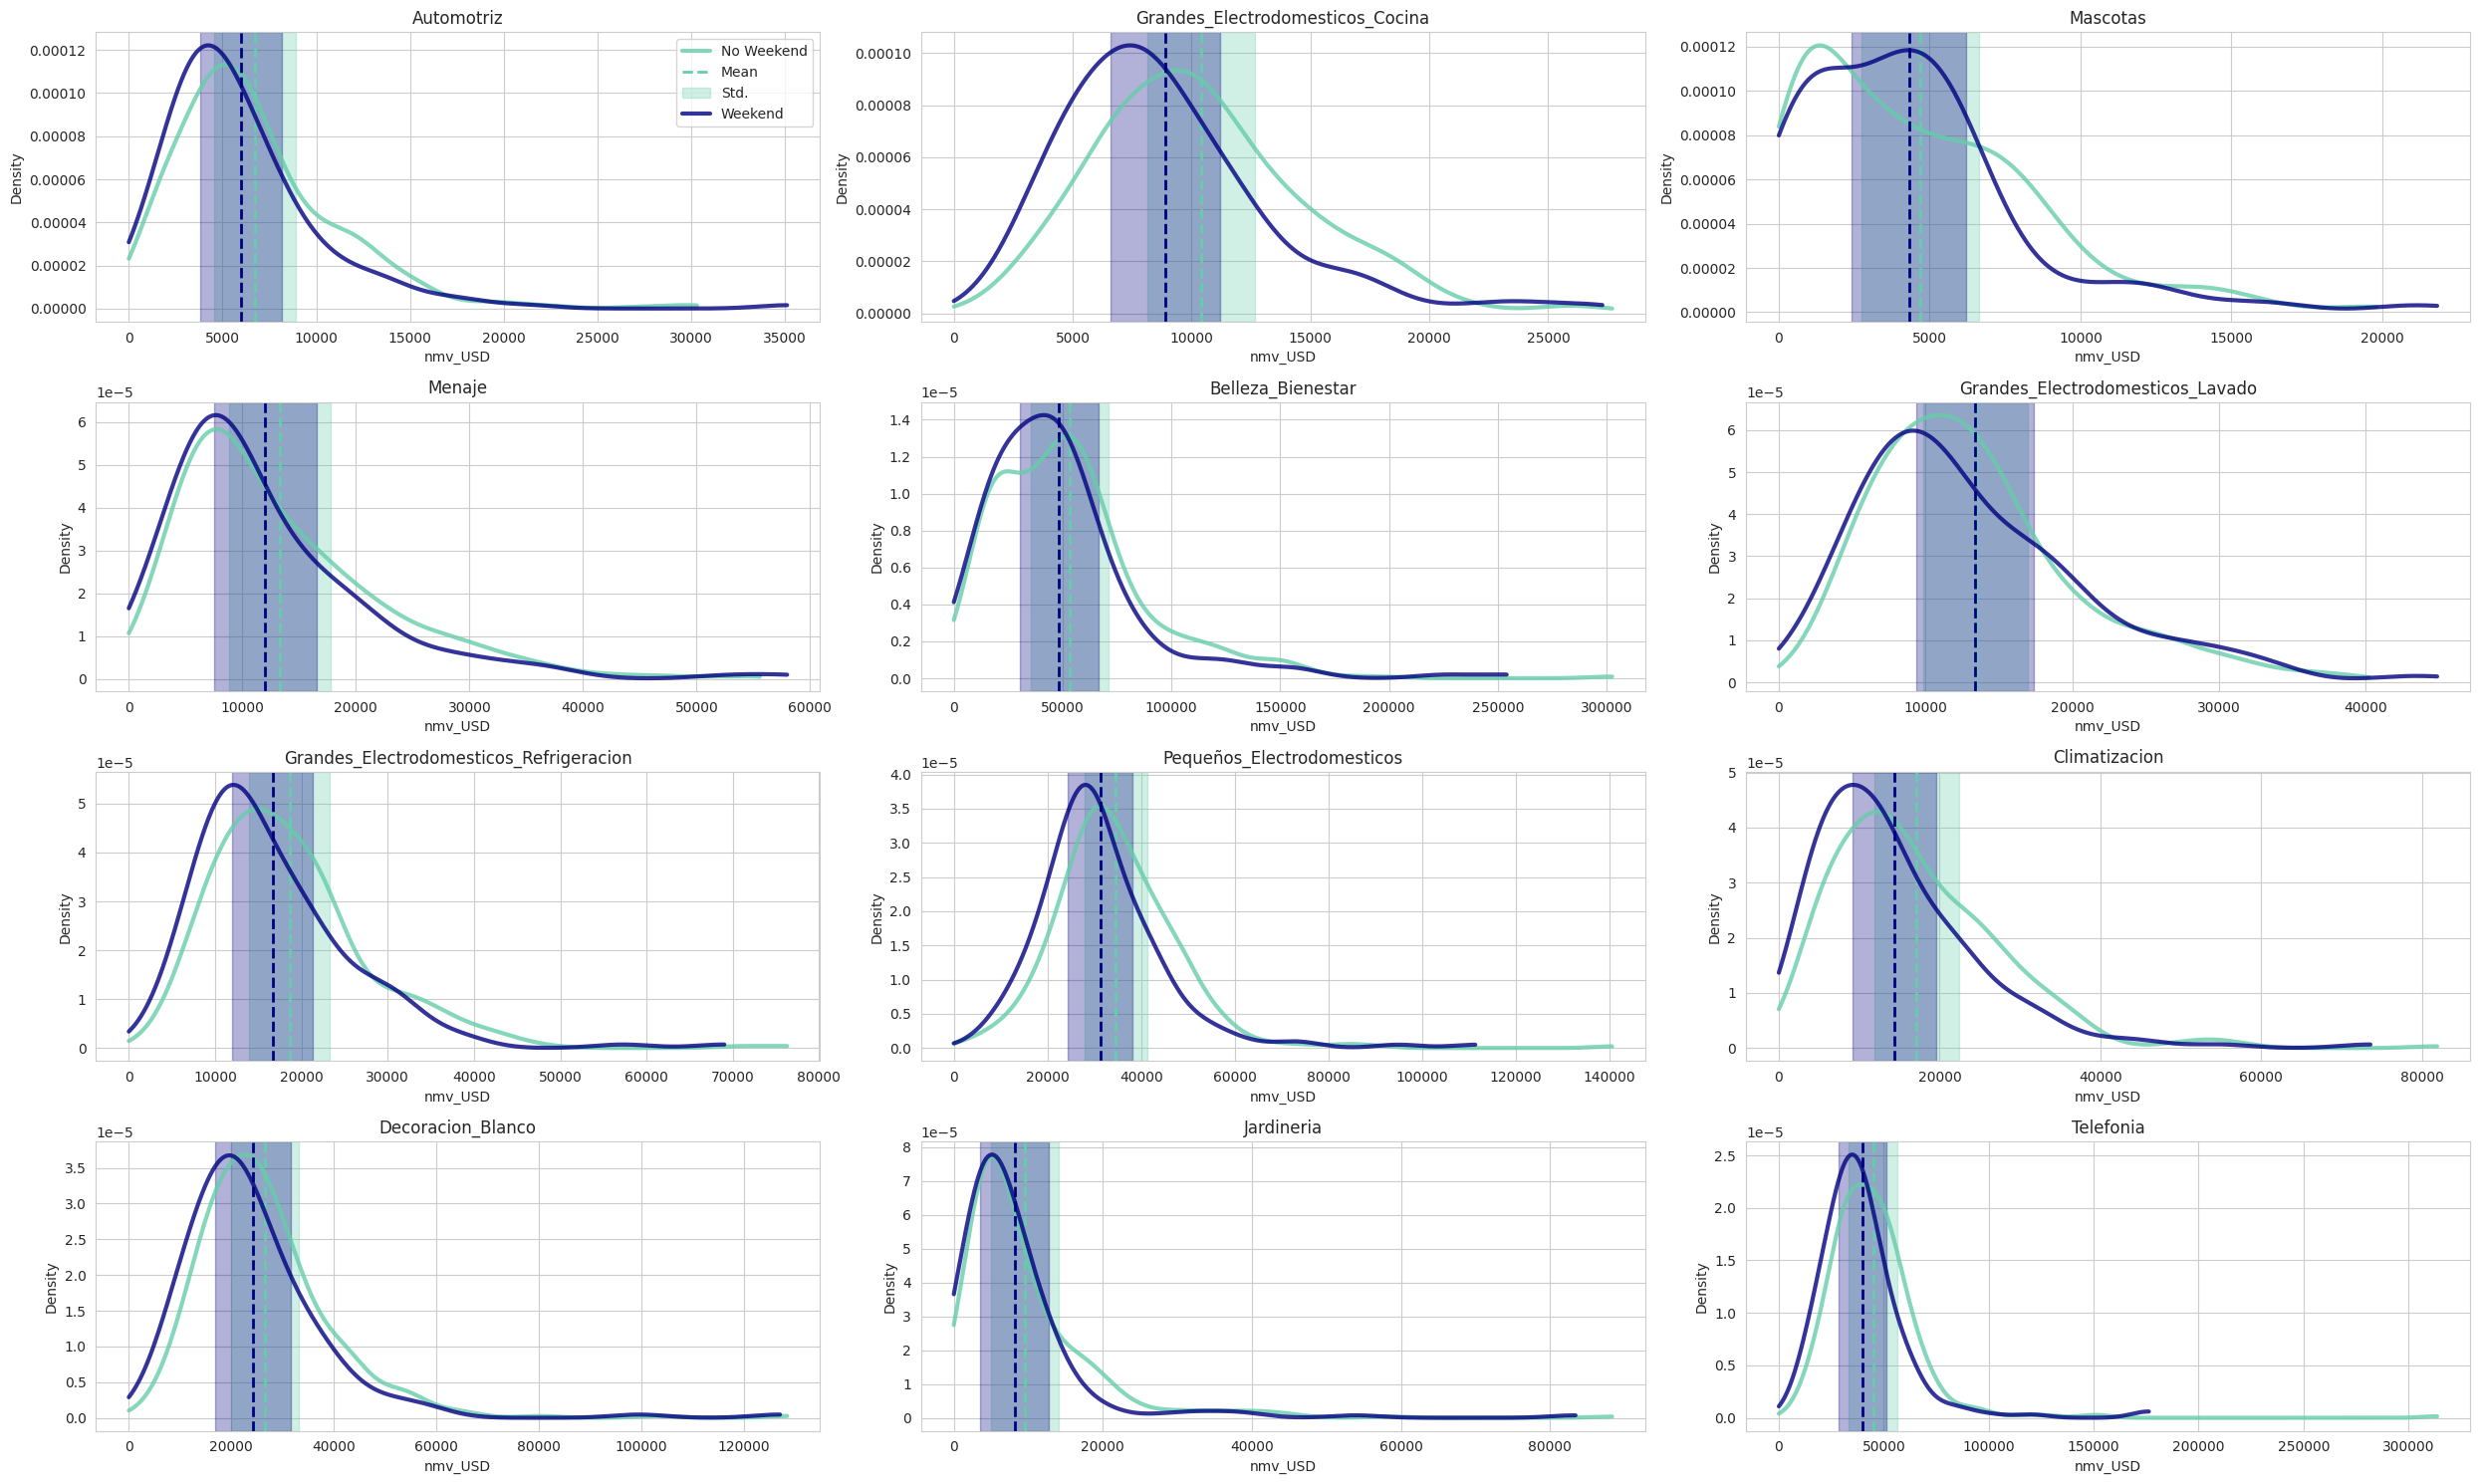

In [ ]:
x_='nmv_USD'

cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(25,15))
fig.patch.set_facecolor('white')

for i, category in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df = df_raw[(df_raw['campaign']==category)]
    dfwd=df[(df.is_week_day==1)&(df.is_cyber==0)]  # week day
    dfw=df[(df.is_week_day==0)&(df.is_cyber==0)]   # weekend
    #df.reset_index(inplace=True)

    axs[j,k].set_title(category)
    if (j==0)&(k==0):
        v = dfwd[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='mediumaquamarine', linewidth=3, alpha=0.8, label='No Weekend')
        axs[j,k].axvline(v.mean(), color='mediumaquamarine', linestyle='--', linewidth=2, label='Mean')
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.3, color='mediumaquamarine', label='Std.')

        v = dfw[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='navy', linewidth=3, alpha=0.8, label='Weekend')
        axs[j,k].axvline(v.mean(), color='navy', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.3, color='navy')
        axs[j,k].legend()
    else:
        v = dfwd[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='mediumaquamarine', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='mediumaquamarine', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.3, color='mediumaquamarine') #'skyblue'
        v = dfw[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='navy', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='navy', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.3, color='navy')

    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel('Density')
    axs[j,k].grid(True)
plt.tight_layout()

#### Budget distribution by campaigns on Weekend/No-weekend distribution

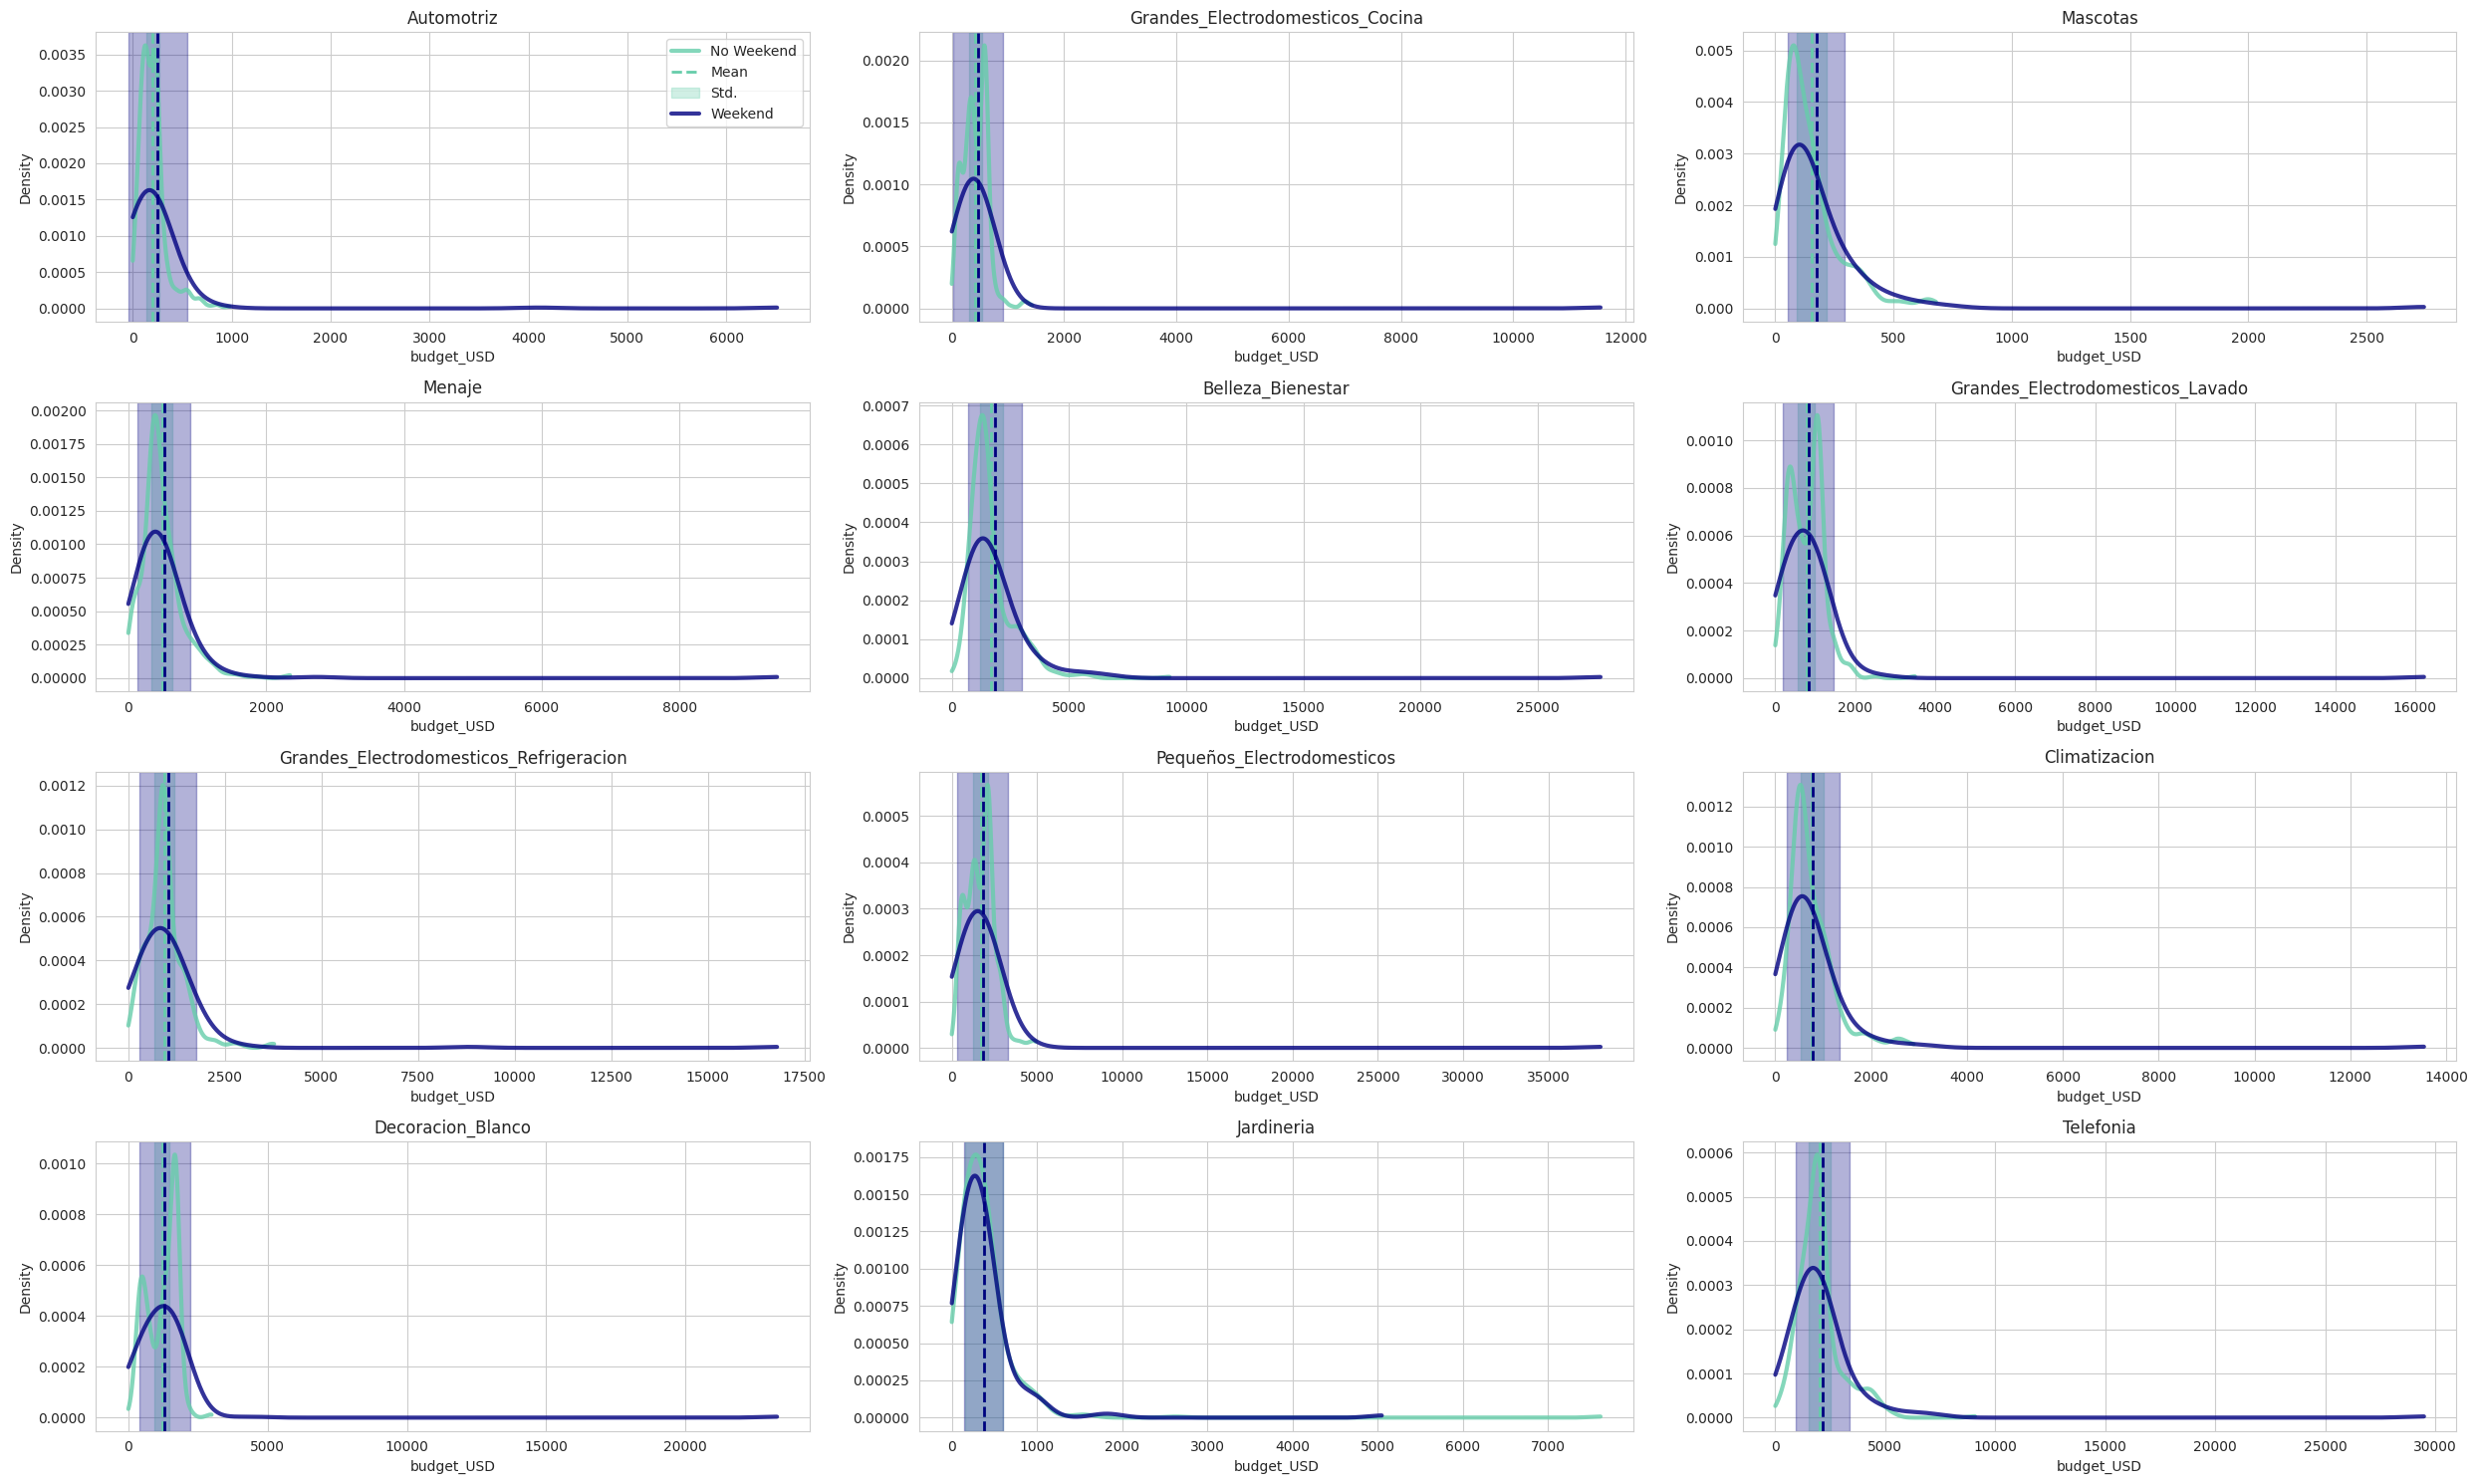

In [ ]:
x_='budget_USD'

cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(25,15))
fig.patch.set_facecolor('white')

for i, category in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df = df_raw[(df_raw['campaign']==category)]
    dfwd=df[(df.is_week_day==1)&(df.is_cyber==0)]  # week day
    dfw=df[(df.is_week_day==0)&(df.is_cyber==0)]   # weekend
    #df.reset_index(inplace=True)

    axs[j,k].set_title(category)
    if (j==0)&(k==0):
        v = dfwd[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='mediumaquamarine', linewidth=3, alpha=0.8, label='No Weekend')
        axs[j,k].axvline(v.mean(), color='mediumaquamarine', linestyle='--', linewidth=2, label='Mean')
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.3, color='mediumaquamarine', label='Std.')

        v = dfw[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='navy', linewidth=3, alpha=0.8, label='Weekend')
        axs[j,k].axvline(v.mean(), color='navy', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.3, color='navy')
        axs[j,k].legend()
    else:
        v = dfwd[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='mediumaquamarine', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='mediumaquamarine', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.3, color='mediumaquamarine') #'skyblue'
        v = dfw[x_]
        kde = stats.gaussian_kde(v.values)
        xx = np.linspace(0, max(v), 1000)
        _ = axs[j,k].plot(xx, kde(xx), color='navy', linewidth=3, alpha=0.8)
        axs[j,k].axvline(v.mean(), color='navy', linestyle='--', linewidth=2)
        axs[j,k].axvspan(v.mean()-v.std()/2, v.mean()+v.std()/2, alpha=0.3, color='navy')

    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel('Density')
    axs[j,k].grid(True)
plt.tight_layout()

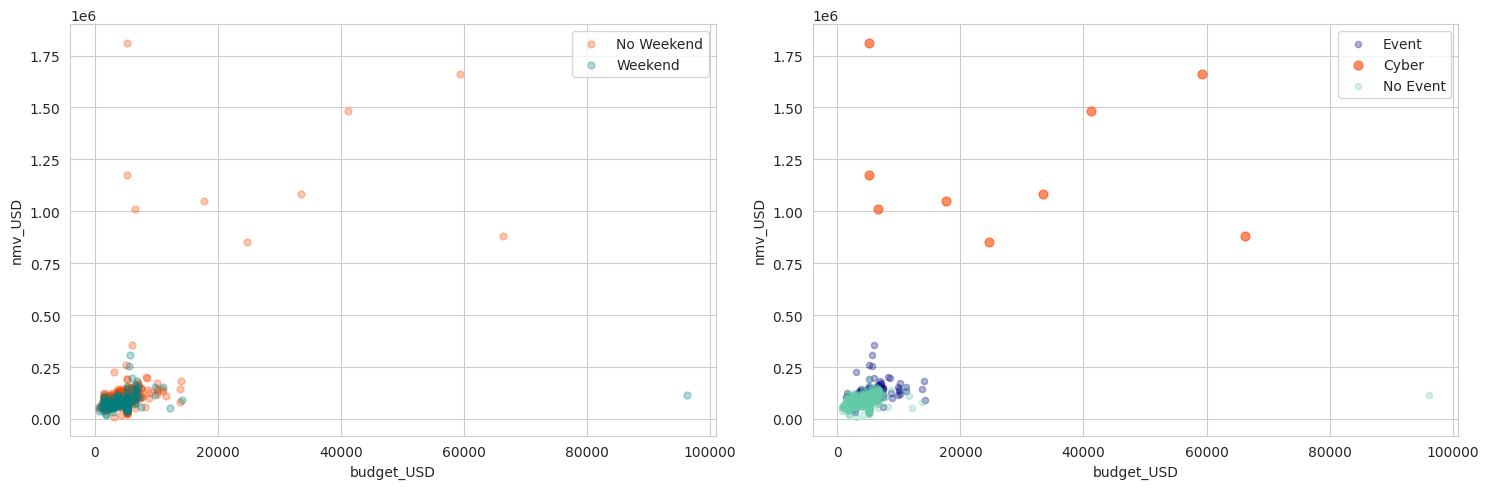

In [ ]:
x_ = 'budget_USD'
y_ = 'nmv_USD'

cols = 2
rows = 1

fig, axs = plt.subplots(rows, cols, figsize=(15,5))
fig.patch.set_facecolor('white')

df = df_g14
df.dropna(inplace=True)
dfnw=df[(df.is_week_day==1)]
dfw=df[(df.is_week_day==0)]

axs[0].scatter(dfnw[x_],dfnw[y_], s=25, color='orangered', alpha=0.3, label='No Weekend')
axs[0].scatter(dfw[x_],dfw[y_], s=25, color='teal', alpha=0.3, label='Weekend')
axs[0].legend()
axs[0].set_xlabel(f'{x_}')
axs[0].set_ylabel(f'{y_}')
axs[0].grid(True)


#### NMV vs budget for events/cyber/no-cyber

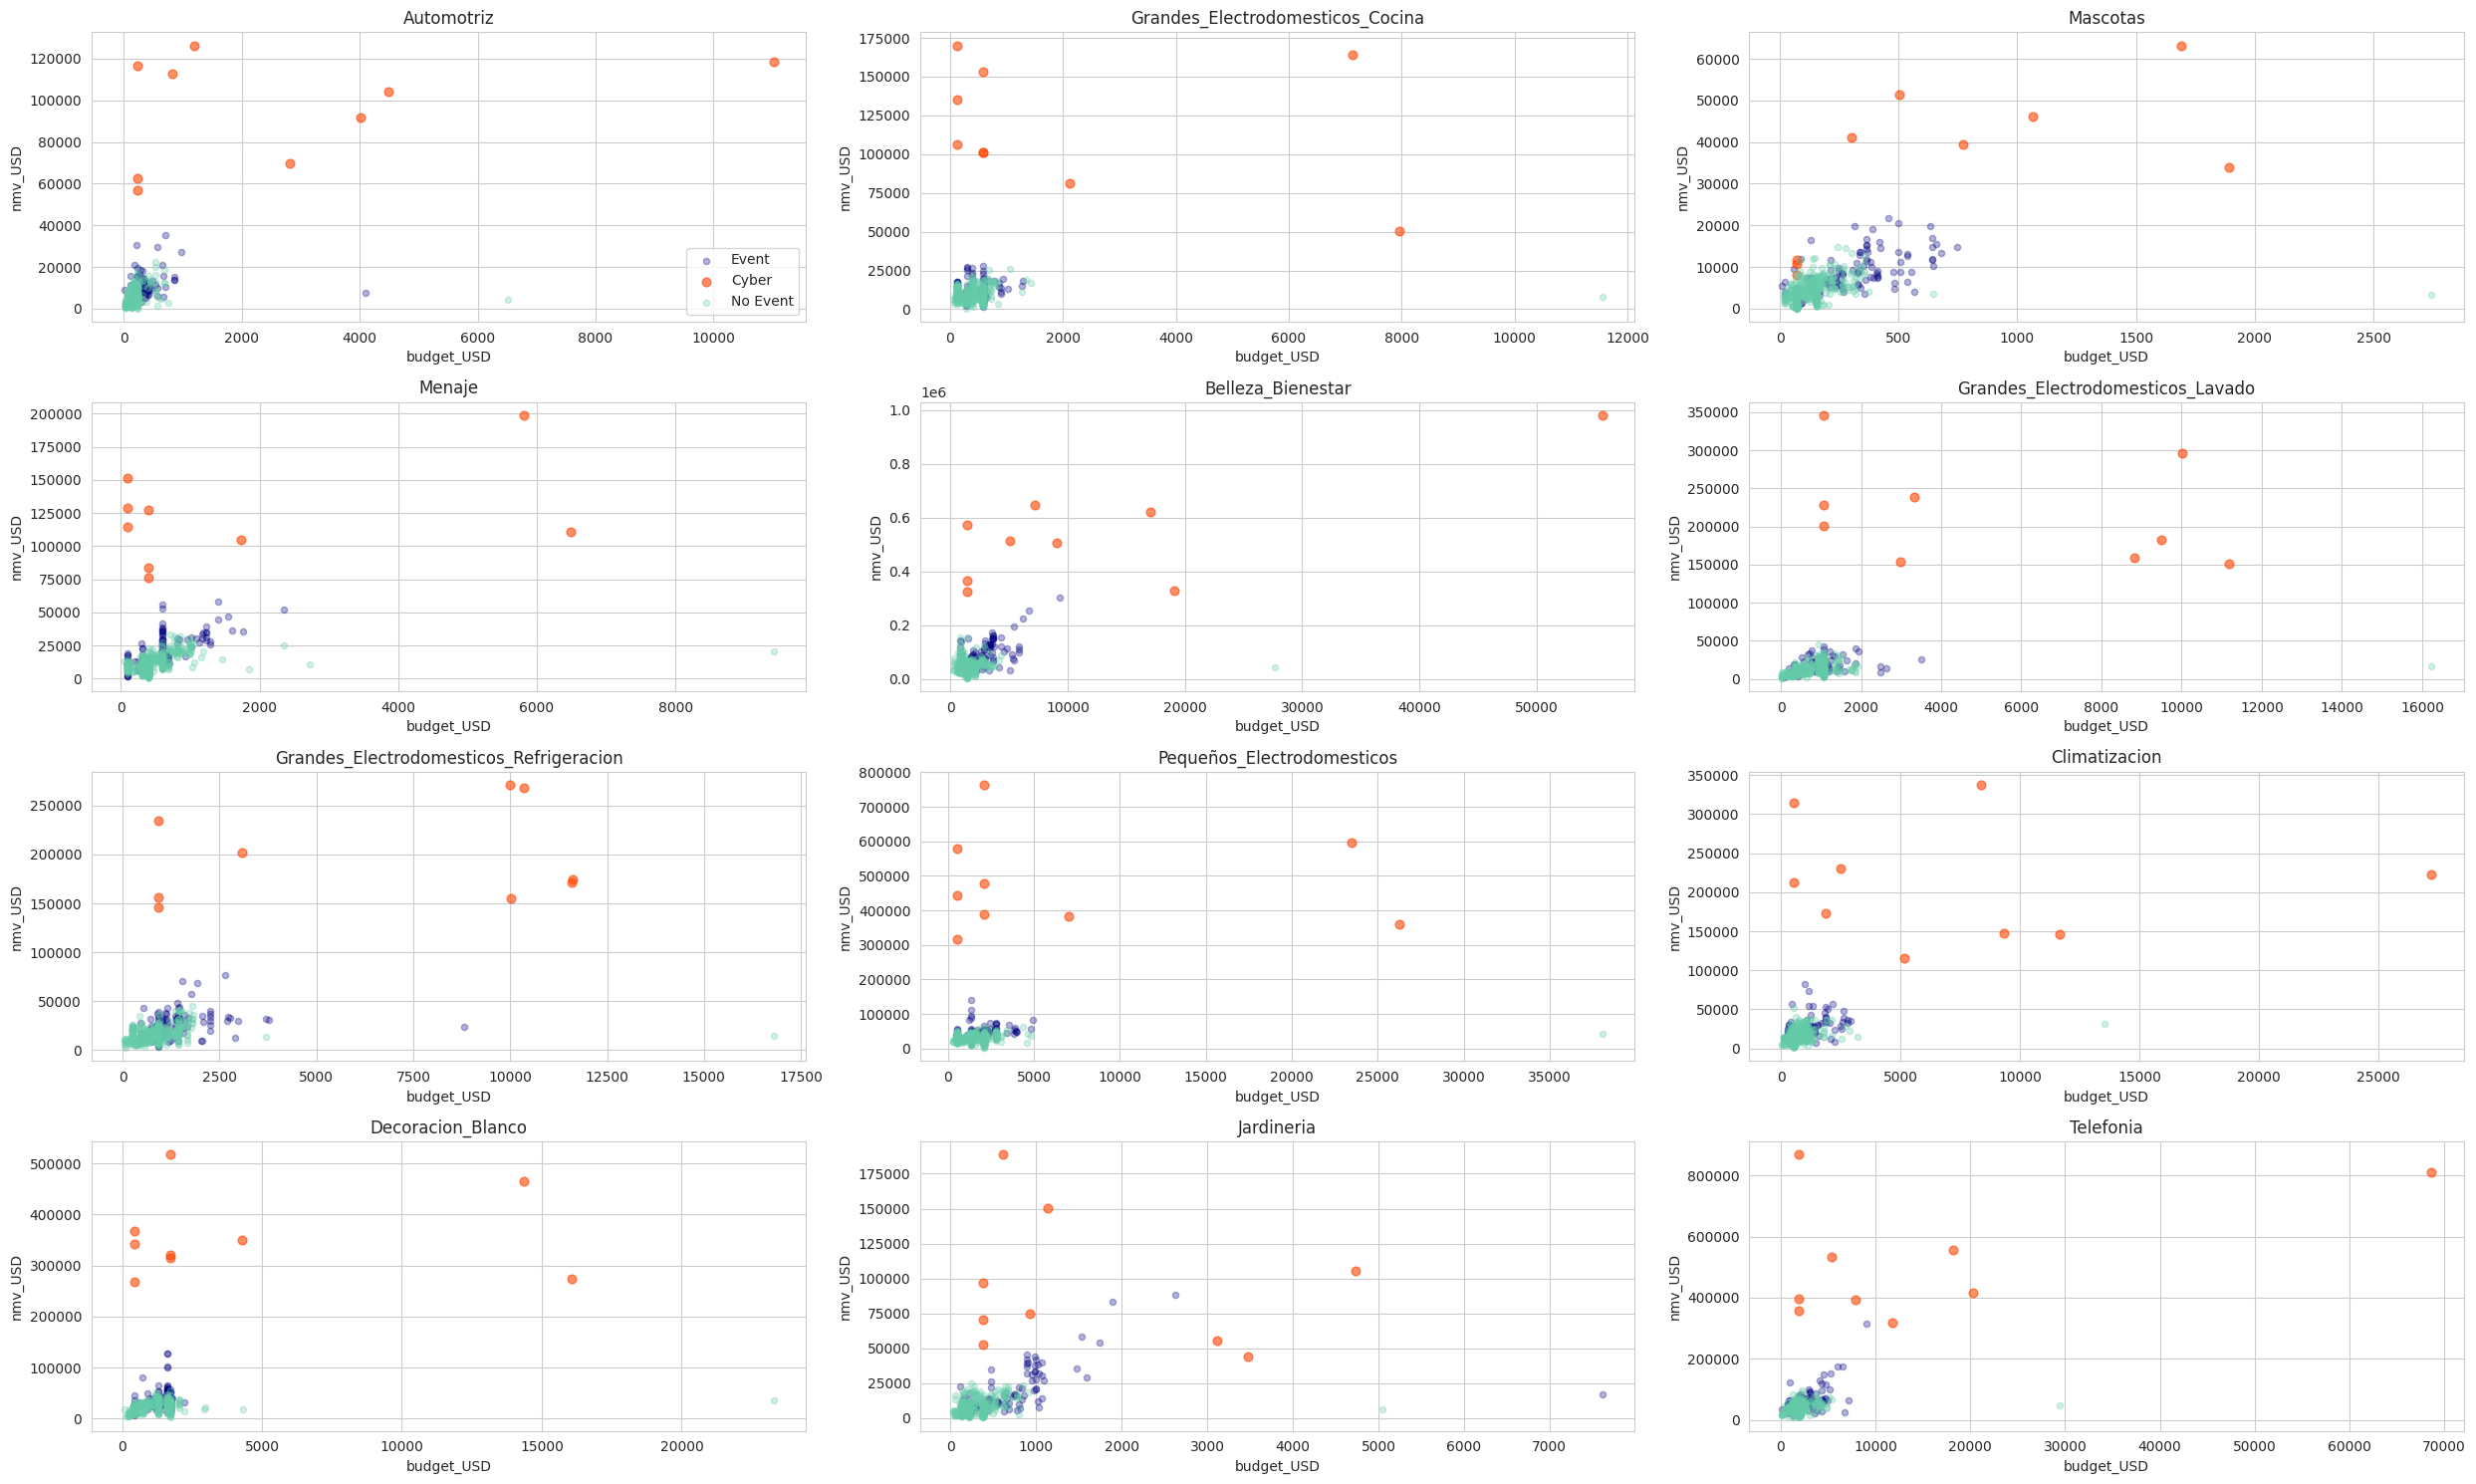

In [ ]:
x_ = 'budget_USD'
y_ = 'nmv_USD'

cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(25,15))
fig.patch.set_facecolor('white')
for i, category in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df = df_raw[(df_raw['campaign']==category)]
    df.reset_index(inplace=True)

    dfe=df[(df.is_event==1)&(df.is_cyber==0)]
    dfc=df[df.is_cyber==1]
    dfne=df[df.is_event==0]

    axs[j,k].set_title(category)
    if (j==0)&(k==0):
        axs[j,k].scatter(dfe[x_],dfe[y_], s=20, color='navy', alpha=0.3, label='Event')
        axs[j,k].scatter(dfc[x_],dfc[y_], s=40,  color='orangered', alpha=0.6, label='Cyber')
        axs[j,k].scatter(dfne[x_],dfne[y_], s=20, color='mediumaquamarine', alpha=0.3, label='No Event')
        axs[j,k].legend()
    else:
        axs[j,k].scatter(dfe[x_],dfe[y_], s=20, color='navy', alpha=0.3)
        axs[j,k].scatter(dfc[x_],dfc[y_], s=40, color='orangered', alpha=0.6)
        axs[j,k].scatter(dfne[x_],dfne[y_], s=20, color='mediumaquamarine', alpha=0.3)
    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel(f'{y_}')
    axs[j,k].grid(True)
plt.tight_layout()

#### NMV vs budget for weekend/no-weekend

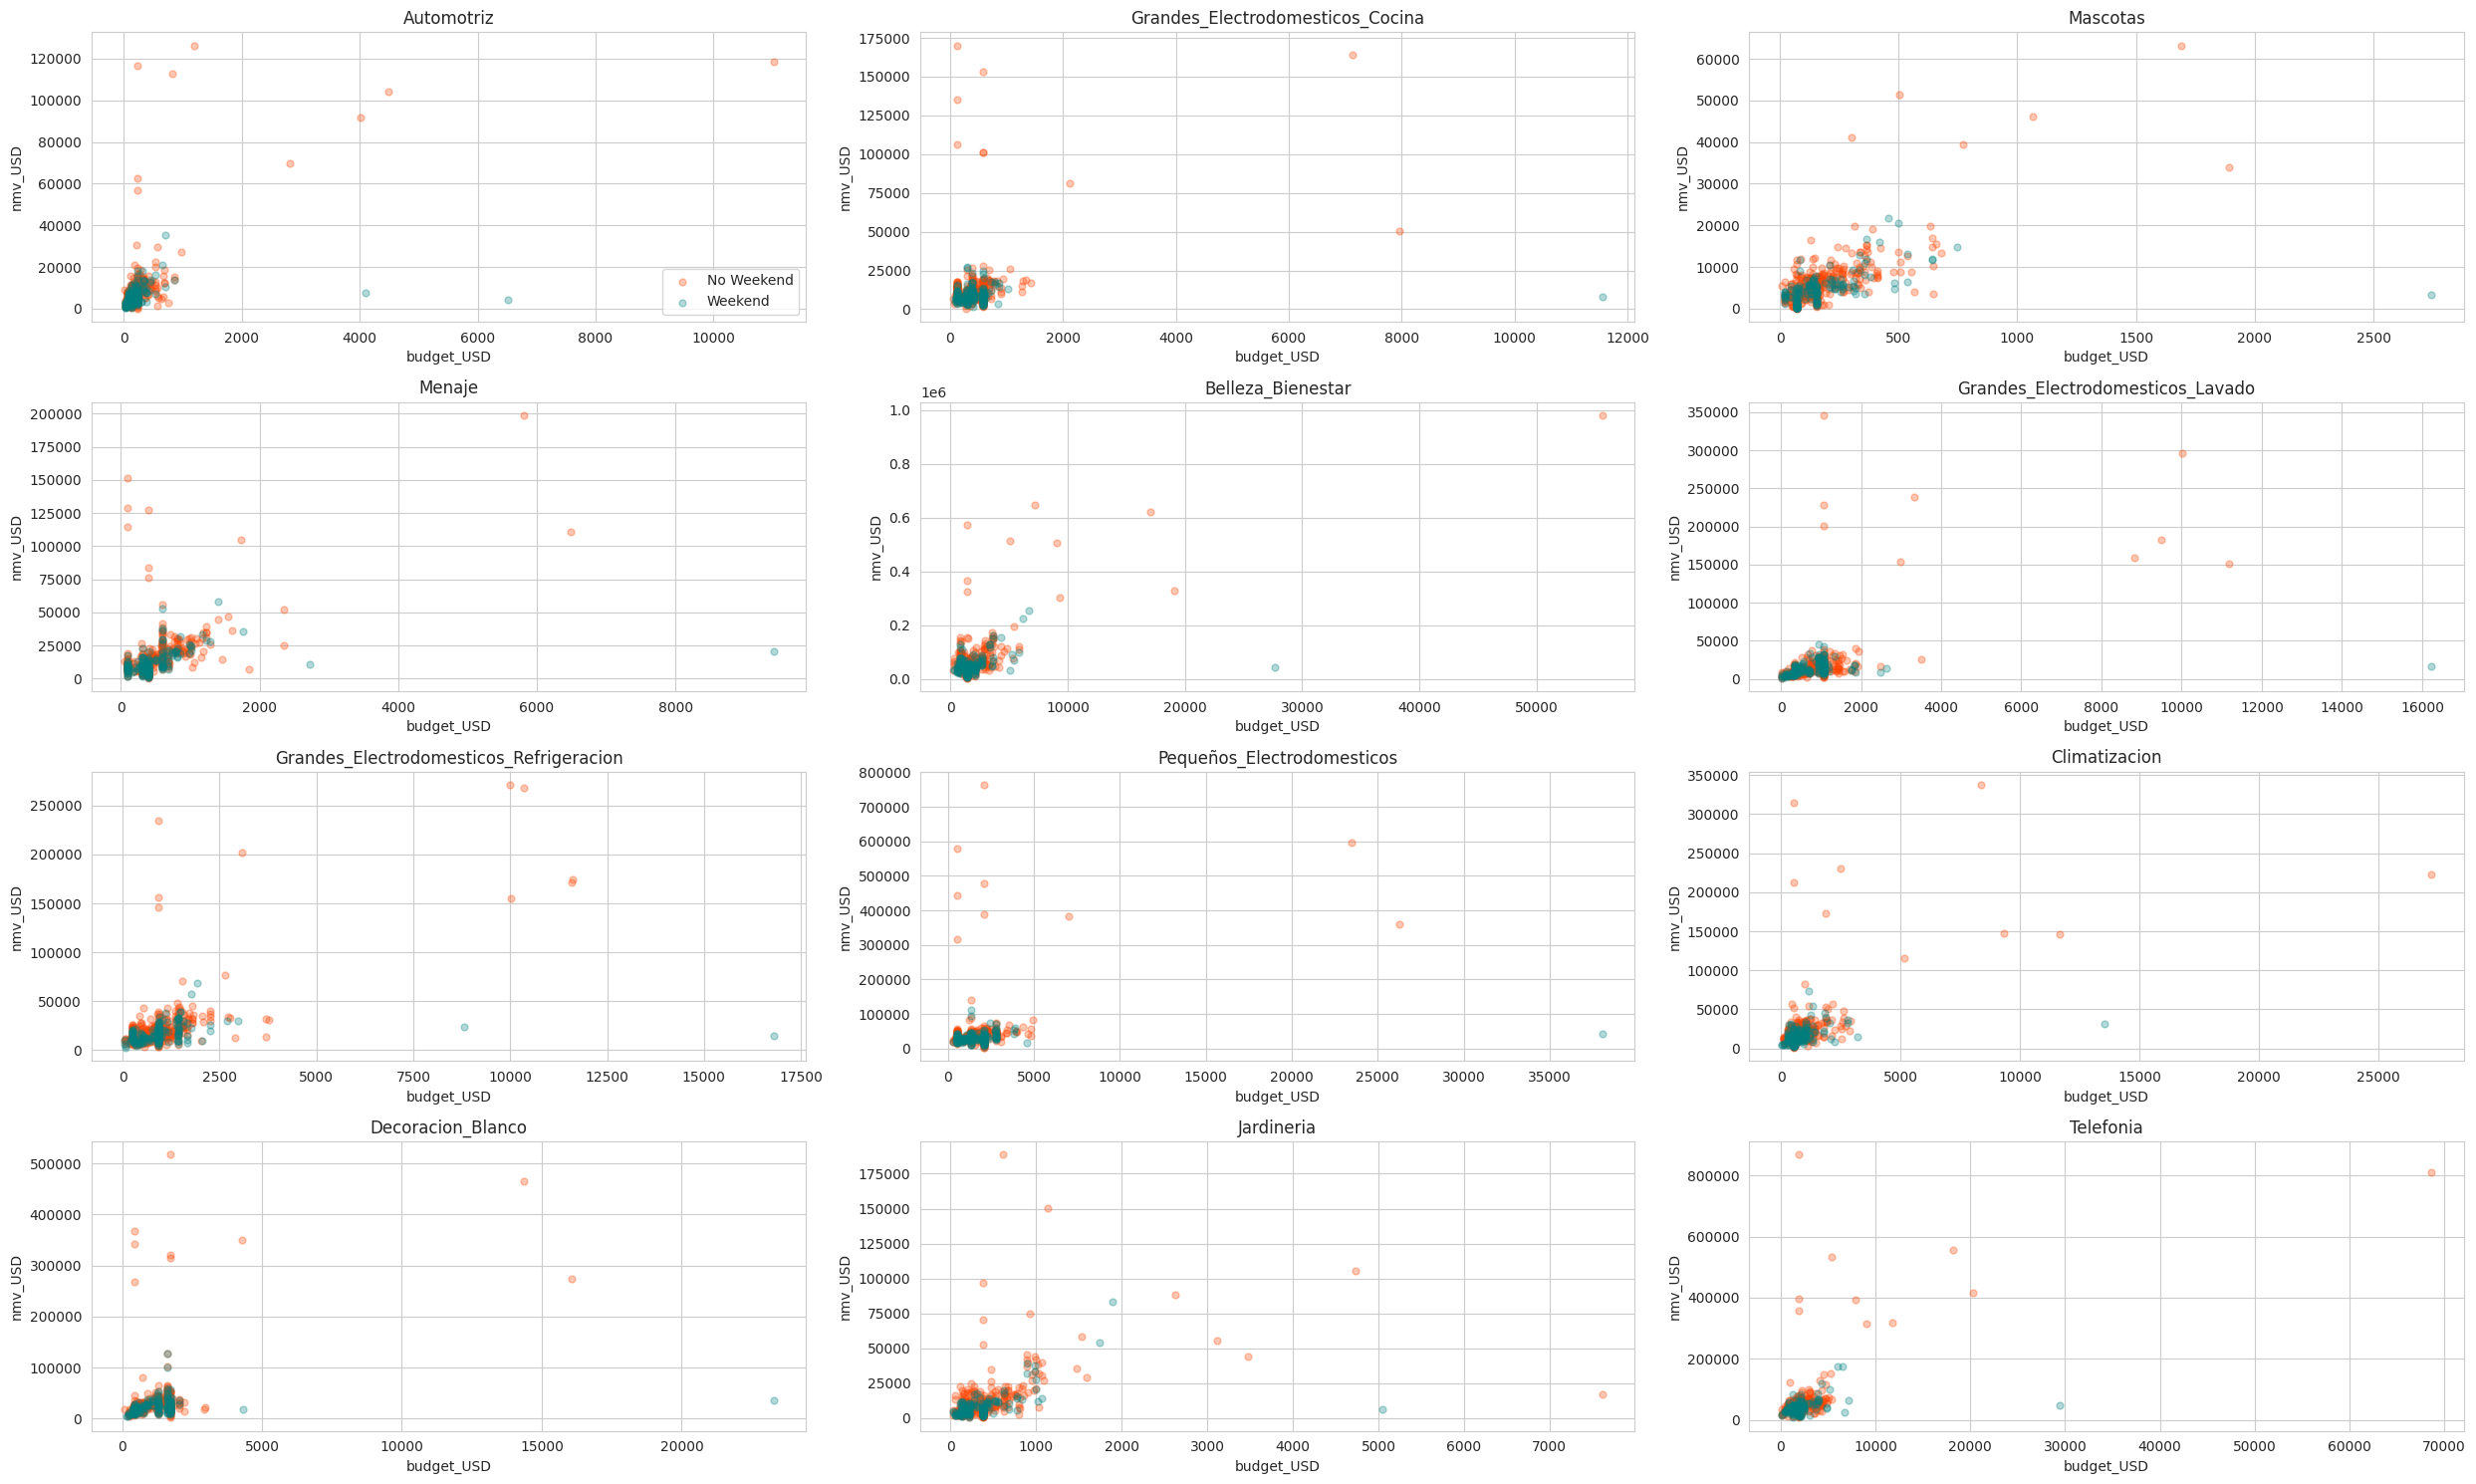

In [ ]:
x_ = 'budget_USD'
y_ = 'nmv_USD'

cols = 3
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(25,15))
fig.patch.set_facecolor('white')
for i, category in enumerate([*df_raw.campaign.unique()]):
    j = i%(rows)
    k = i%(cols)

    df = df_raw[(df_raw['campaign']==category)]
    df.reset_index(inplace=True)

    dfnw=df[(df.is_week_day==1)]  # week day
    dfw=df[(df.is_week_day==0)]   # weekend

    axs[j,k].set_title(category)
    if (j==0)&(k==0):
        axs[j,k].scatter(dfnw[x_],dfnw[y_], s=25, color='orangered', alpha=0.3, label='No Weekend')
        axs[j,k].scatter(dfw[x_],dfw[y_], s=25, color='teal', alpha=0.3, label='Weekend')
        axs[j,k].legend()
    else:
        axs[j,k].scatter(dfnw[x_],dfnw[y_], s=25, color='orangered', alpha=0.3, label='No Weekend')
        axs[j,k].scatter(dfw[x_],dfw[y_], s=25, color='teal', alpha=0.3, label='Weekend')

    axs[j,k].set_xlabel(f'{x_}')
    axs[j,k].set_ylabel(f'{y_}')
    axs[j,k].grid(True)
plt.tight_layout()

### Correlation analysis

In [ ]:
corr = df_raw.corr()
styled_corr = corr.style.background_gradient(cmap='coolwarm')
styled_corr.set_caption("<span style='font-size: 20px'>Correlation Matrix</span>")
styled_corr.set_properties(**{'font-size': '12px'})

In [ ]:
df_ = df_raw[df_raw.is_cyber == 0]
corr_nocyber = df_.corr()
styled_corr_ = corr_nocyber.style.background_gradient(cmap='coolwarm')
styled_corr_.set_caption("<span style='font-size: 20px'>Correlation Matrix for no-cyber days</span>")
styled_corr_.set_properties(**{'font-size': '12px'})

<Axes: title={'center': 'Correlarions (No cyber days)'}>

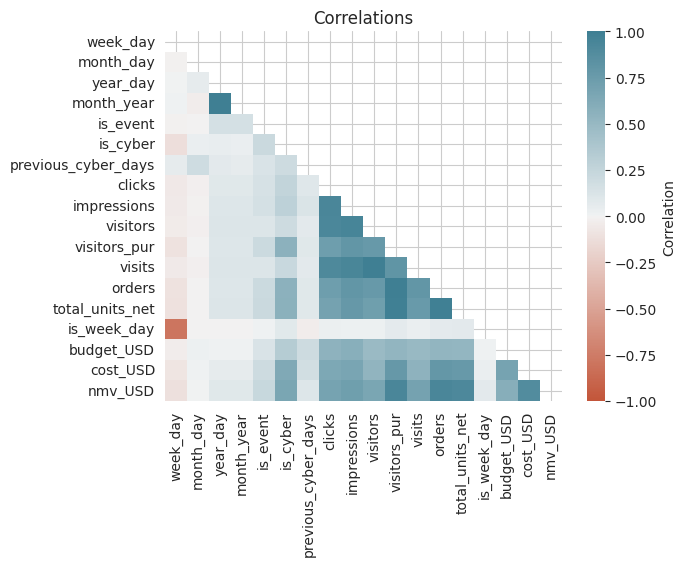

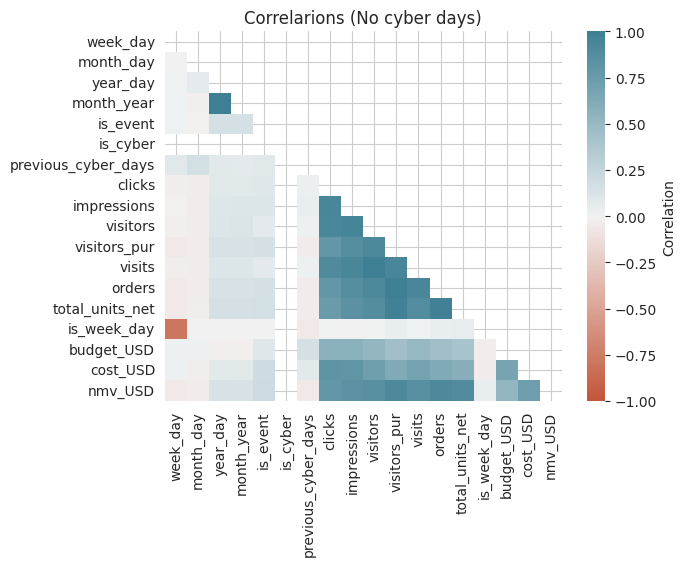

In [ ]:
df = df_raw
corrmat = df.corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
plt.title('Correlations')
sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=False, annot_kws={'fontsize':8},
            mask=mask,
            cmap=sns.diverging_palette(20,220,as_cmap=True),
            cbar_kws={'label': 'Correlation'},
            ax=ax)

df_ = df_raw[df_raw.is_cyber == 0]
corrmat_nout = df_.corr()
mask= np.zeros_like(corrmat_nout)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
plt.title('Correlarions (No cyber days)')
sns.heatmap(corrmat_nout,
            vmax=1, vmin=-1,
            annot=False, annot_kws={'fontsize':8},
            mask=mask,
            cmap=sns.diverging_palette(20,220,as_cmap=True),
            cbar_kws={'label': 'Correlation'},
            ax=ax)

### Export final data

This dataframe has new variables and transformations

In [ ]:
## Save parquet file for category G14 into temporary enviroment
df_raw.to_parquet('/content/drive/MyDrive/UNR_2023/01.Open data/data_NMV_GAds_manipulated.parquet', index=True)

In [ ]:
df_raw['is_event'].value_counts()

0    5171
1    1821
Name: is_event, dtype: int64